Program Flow:

- Generate a list of locations:
- Segment the entire time period into x day intervals.
- Last cycle will contain the remainder alone.
- Use a weighted greedy algorithm to find locations per interval.
- Count how many occurences there are of each location, assign value for top I_SIGMA locations, and tabulate.
- Tabulate total scores for all locations, sort from high to low, and choose top I_S locations for the entire period.
- Generate map based on these locations.

In [87]:
# Import Statements
import os
import json
import folium
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h3
from datetime import datetime, timedelta
from folium.plugins import HeatMap, Fullscreen, MeasureControl, MousePosition, MiniMap, LocateControl, Geocoder
from branca.colormap import linear

In [88]:
# Debug
# Setup pretty printer
pp = pprint.PrettyPrinter(indent=2)

Datasets

- This notebook optimises *station locations* using **ride end locations** (it does not require swaps, but you can load them for future extensions).
- `df_rides` must contain at least: `vehicle_id`, `start_time`, `end_time`, `end_lat`, `end_lng`.
- Timestamps should be parseable to datetimes (timezone handling is up to you; this notebook treats them as naive datetimes).

In [89]:
# Data to be read
# Set these paths to switch cities/datasets.
#RIDES_CSV_PATH = '/Users/santtoshmohan/Downloads/dott_nottingham_rides_(30_10).csv'
#SWAPS_CSV_PATH = '/Users/santtoshmohan/Downloads/dott_nottingham_swaps_(30_10).csv'
RIDES_CSV_PATH = '/Users/santtoshmohan/Desktop/standab data/Vasteras senaste 12 man.csv'
#RIDES_CSV_PATH ='/Users/santtoshmohan/Downloads/dott_nottingham_rides_(30_10).csv'
#(Vaasa):
#RIDES_CSV_PATH = '/Users/santtoshmohan/Downloads/dott_vaasa_rides_2025.csv'
SWAPS_CSV_PATH = '/Users/santtoshmohan/Downloads/dott_vaasa_swaps_2025.csv'

#RIDES_CSV_PATH = '/Users/santtoshmohan/Downloads/standab/javla_rides.csv'

df_rides = pd.read_csv(RIDES_CSV_PATH, engine="python")
df_swaps = pd.read_csv(SWAPS_CSV_PATH)

# --- Column normalization for javla_rides.csv ---
# Map known header variants to expected names.
_rename_direct = {
    'Vehicle ID': 'vehicle_id',
    'Start Time': 'start_time',
    'End Time': 'end_time',
}
for src, dst in _rename_direct.items():
    if src in df_rides.columns and dst not in df_rides.columns:
        df_rides = df_rides.rename(columns={src: dst})

# Extract lat/lng from Start Loc / End Loc JSON strings if present.
# Expected format: {"coordinates": [lng, lat], ...}
import json as _json_loc

def _extract_coords(val):
    try:
        if pd.isna(val):
            return (np.nan, np.nan)
        if isinstance(val, (dict, list)):
            obj = val
        else:
            obj = _json_loc.loads(val)
        coords = None
        if isinstance(obj, dict):
            coords = obj.get('coordinates')
        elif isinstance(obj, list):
            coords = obj
        if not coords or len(coords) < 2:
            return (np.nan, np.nan)
        lng, lat = float(coords[0]), float(coords[1])
        return (lat, lng)
    except Exception:
        return (np.nan, np.nan)

if 'Start Loc' in df_rides.columns and ('start_lat' not in df_rides.columns or 'start_lng' not in df_rides.columns):
    _start_coords = df_rides['Start Loc'].apply(_extract_coords)
    df_rides['start_lat'] = _start_coords.apply(lambda x: x[0])
    df_rides['start_lng'] = _start_coords.apply(lambda x: x[1])

if 'End Loc' in df_rides.columns and ('end_lat' not in df_rides.columns or 'end_lng' not in df_rides.columns):
    _end_coords = df_rides['End Loc'].apply(_extract_coords)
    df_rides['end_lat'] = _end_coords.apply(lambda x: x[0])
    df_rides['end_lng'] = _end_coords.apply(lambda x: x[1])

# --- Schema standardisation (robust to different exports) ---
# Downstream code expects:
# - vehicle_id, start_time, end_time, start_lat, start_lng, end_lat, end_lng
import warnings as _schema_warnings

def _pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Known variants (Vaasa vs Nottingham vs other exports)
_vehicle_id = _pick_col(df_rides, ['vehicle_id','vehicleId','vehicle','scooter_id','bike_id','vehicle_identifier'])
_start_time = _pick_col(df_rides, ['start_time','time_ride_start_local','time_ride_start','started_at','start_datetime','startTime'])
_end_time = _pick_col(df_rides, ['end_time','time_ride_end_local','time_ride_end','ended_at','end_datetime','endTime'])
_start_lat = _pick_col(df_rides, ['start_lat','lat_start','latStart','start_latitude','startLatitude','pickup_lat','latPickup'])
_start_lng = _pick_col(df_rides, ['start_lng','start_lon','start_long','lng_start','lngStart','start_longitude','startLongitude','pickup_lng','lon_start','lngPickup'])
_end_lat = _pick_col(df_rides, ['end_lat','lat_end','latEnd','end_latitude','endLatitude','dropoff_lat','latDropoff'])
_end_lng = _pick_col(df_rides, ['end_lng','end_lon','end_long','lng_end','lngEnd','end_longitude','endLongitude','dropoff_lng','lon_end','lngDropoff'])

# Optional H3 columns (some exports include precomputed H3 at fixed resolution)
_start_h3 = _pick_col(df_rides, ['start_h3','Start Loc H3 9','Start H3','start_h3_9'])
_end_h3 = _pick_col(df_rides, ['end_h3','End Loc H3 9','End H3','end_h3_9'])

rename_map = {}
if _vehicle_id and _vehicle_id != 'vehicle_id':
    rename_map[_vehicle_id] = 'vehicle_id'
if _start_time and _start_time != 'start_time':
    rename_map[_start_time] = 'start_time'
if _end_time and _end_time != 'end_time':
    rename_map[_end_time] = 'end_time'
if _start_lat and _start_lat != 'start_lat':
    rename_map[_start_lat] = 'start_lat'
if _start_lng and _start_lng != 'start_lng':
    rename_map[_start_lng] = 'start_lng'
if _end_lat and _end_lat != 'end_lat':
    rename_map[_end_lat] = 'end_lat'
if _end_lng and _end_lng != 'end_lng':
    rename_map[_end_lng] = 'end_lng'

# Prefer lat/lng-derived H3; only use provided H3 if lat/lng are missing.
if _start_h3 and _start_h3 != 'start_h3' and ('start_lat' not in df_rides.columns or 'start_lng' not in df_rides.columns):
    rename_map[_start_h3] = 'start_h3'
if _end_h3 and _end_h3 != 'end_h3' and ('end_lat' not in df_rides.columns or 'end_lng' not in df_rides.columns):
    rename_map[_end_h3] = 'end_h3'

if rename_map:
    df_rides = df_rides.rename(columns=rename_map)

missing = [c for c in ['vehicle_id','start_time','end_time','start_lat','start_lng','end_lat','end_lng'] if c not in df_rides.columns]
if missing:
    _schema_warnings.warn(
        f"df_rides is missing expected columns: {missing}. Available columns: {list(df_rides.columns)}"
    )


In [90]:
df_rides.head()

,Ride ID,start_time,end_time,Zone ID,Ride Duration,vehicle_id,Start Loc H3 9,End Loc H3 9,Start Loc,End Loc,start_lat,start_lng,end_lat,end_lng
0,4ffb8519-7add-4411-95f8-a867263dabbc,"May 29, 2024, 3:18 PM","May 29, 2024, 3:19 PM",171,1.33,53d1f84a-c675-4059-8253-fa45de948cc4,8908868648bffff,890886864c7ffff,"{\n ""coordinates"": [\n 1.655073300000000e+...","{\n ""coordinates"": [\n 1.655100900000000e+...",59.633675,16.550733,59.631164,16.551009
1,ccd7f003-0bb0-4480-b01f-bf8560b12be3,"May 29, 2024, 5:00 PM","May 29, 2024, 5:04 PM",171,3.58,a7ce3d4b-aa92-4061-96a3-76eff2bd4706,8908868644bffff,8908868668fffff,"{\n ""coordinates"": [\n 1.656961296600000e+...","{\n ""coordinates"": [\n 1.657508316600000e+...",59.624668,16.569613,59.620416,16.575083
2,a310d1d7-308f-4be5-b4ca-50aec1516006,"May 29, 2024, 1:05 PM","May 29, 2024, 1:19 PM",171,13.42,f183c651-172e-40d9-aa3e-c3aeaf69600a,89088687557ffff,89088687557ffff,"{\n ""coordinates"": [\n 1.660444660231076e+...","{\n ""coordinates"": [\n 1.660280491289311e+...",59.600093,16.604447,59.599387,16.602805
3,7840fc0c-c493-4e98-968c-7155b51433d9,"May 29, 2024, 6:45 PM","May 29, 2024, 7:09 PM",171,24.13,13ac33bd-d949-48c7-922c-1cbebe72474d,89088695b87ffff,89088694b53ffff,"{\n ""coordinates"": [\n 1.655139120000000e+...","{\n ""coordinates"": [\n 1.653800155000000e+...",59.607666,16.551391,59.641075,16.538002
4,d47fa627-c387-4931-8c71-e5628cbf8dbb,"May 29, 2024, 1:24 PM","May 29, 2024, 1:36 PM",171,12.23,92f3ce3f-add3-4c69-ab17-2d4642aeab7b,89088686443ffff,89088695b63ffff,"{\n ""coordinates"": [\n 1.656335929999999e+...","{\n ""coordinates"": [\n 1.657657810000000e+...",59.625792,16.563359,59.601305,16.576578


Processing conducted in memory, use the following code as an example and modify it as required. The following codeblock is the processing conducted for the ride and swap data for the Vaasa dataset from Dott.

In [91]:
# Convert time columns to datetime (robust to different formats / timezones)
# Works for strings like "2025-05-05 03:37:00.363 UTC" as well as plain "YYYY-mm-dd HH:MM".
import warnings

_raw_start_time = df_rides['start_time'].copy()
_raw_end_time = df_rides['end_time'].copy()

_df_st = pd.to_datetime(_raw_start_time, errors='coerce', utc=True)
_df_et = pd.to_datetime(_raw_end_time, errors='coerce', utc=True)

# Fallback parsing: pandas may infer a single format and fail on mixed strings.
# We do two steps:
# 1) strip a trailing " UTC" and retry
# 2) for any remaining NaT, parse just those rows (slower but robust)
if _df_st.isna().any():
    try:
        _df_st2 = pd.to_datetime(
            _raw_start_time.astype(str).str.replace(' UTC', '', regex=False),
            errors='coerce',
            utc=True,
        )
        _df_st = _df_st.fillna(_df_st2)
    except Exception:
        pass

    try:
        _mask = _df_st.isna()
        if bool(_mask.any()):
            _df_st.loc[_mask] = pd.to_datetime(
                _raw_start_time.loc[_mask].astype(str),
                errors='coerce',
                utc=True,
            )
    except Exception:
        pass

if _df_et.isna().any():
    try:
        _df_et2 = pd.to_datetime(
            _raw_end_time.astype(str).str.replace(' UTC', '', regex=False),
            errors='coerce',
            utc=True,
        )
        _df_et = _df_et.fillna(_df_et2)
    except Exception:
        pass

    try:
        _mask = _df_et.isna()
        if bool(_mask.any()):
            _df_et.loc[_mask] = pd.to_datetime(
                _raw_end_time.loc[_mask].astype(str),
                errors='coerce',
                utc=True,
            )
    except Exception:
        pass

# Warn loudly if anything still failed to parse (these rows will be dropped by time filters later)
_n_st_nat = int(_df_st.isna().sum())
_n_et_nat = int(_df_et.isna().sum())
if _n_st_nat or _n_et_nat:
    def _sample_bad(mask, raw_series, label):
        cols = [c for c in ['ride_id', 'vehicle_id'] if c in df_rides.columns]
        try:
            sample = df_rides.loc[mask, cols].copy() if cols else df_rides.loc[mask].iloc[0:0].copy()
            sample[label] = raw_series.loc[mask].astype(str).head(5).values
            return sample.head(5).to_dict(orient='records')
        except Exception:
            return []

    _samples = {
        'start_time': _sample_bad(_df_st.isna(), _raw_start_time, 'start_time_raw'),
        'end_time': _sample_bad(_df_et.isna(), _raw_end_time, 'end_time_raw'),
    }
    warnings.warn(
        f"Datetime parse failures: start_time NaT={_n_st_nat:,}, end_time NaT={_n_et_nat:,}. "
        f"These rows will be dropped by TIME_PERIOD filters. Samples: {_samples}"
    )

# Make naive timestamps (so they compare cleanly to TIME_PERIOD datetimes)
df_rides['start_time'] = _df_st.dt.tz_convert(None)
df_rides['end_time'] = _df_et.dt.tz_convert(None)

# Convenience: dataset max end timestamp (used to make TIME_PERIOD inclusive)
DATASET_END_MAX = df_rides['end_time'].max()

# Dwell time (minutes) from a ride's end to the same vehicle's next ride start
# NOTE: we later restrict "same-location dwell" to cases where the next start is within a radius.
df_rides = df_rides.sort_values(['vehicle_id', 'start_time']).reset_index(drop=True)

# Next ride for the SAME vehicle (anywhere)
df_rides['next_start_time'] = df_rides.groupby('vehicle_id')['start_time'].shift(-1)
if 'start_lat' in df_rides.columns:
    df_rides['next_start_lat'] = df_rides.groupby('vehicle_id')['start_lat'].shift(-1)
else:
    df_rides['next_start_lat'] = np.nan
if 'start_lng' in df_rides.columns:
    df_rides['next_start_lng'] = df_rides.groupby('vehicle_id')['start_lng'].shift(-1)
else:
    df_rides['next_start_lng'] = np.nan

df_rides['dwell_to_next_start_mins'] = (
    (df_rides['next_start_time'] - df_rides['end_time']).dt.total_seconds() / 60.0
)
# Guard against data issues (e.g., out-of-order timestamps)
df_rides.loc[df_rides['dwell_to_next_start_mins'] < 0, 'dwell_to_next_start_mins'] = np.nan

# Same-location dwell: require next start to be within radius of the end point; otherwise NaN
DWELL_SAME_LOC_RADIUS_M = 50

# Vectorized haversine distance (meters)
R = 6371000.0
lat1 = np.radians(pd.to_numeric(df_rides.get('end_lat', np.nan), errors='coerce').to_numpy())
lon1 = np.radians(pd.to_numeric(df_rides.get('end_lng', np.nan), errors='coerce').to_numpy())
lat2 = np.radians(pd.to_numeric(df_rides.get('next_start_lat', np.nan), errors='coerce').to_numpy())
lon2 = np.radians(pd.to_numeric(df_rides.get('next_start_lng', np.nan), errors='coerce').to_numpy())

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon / 2.0) ** 2)
# Clip for numerical stability
c = 2.0 * np.arcsin(np.minimum(1.0, np.sqrt(a)))
dist_m = R * c

within_radius = dist_m <= float(DWELL_SAME_LOC_RADIUS_M)

# Keep row but set dwell to NaN when next start isn't near the end (or if next_start_time missing)
within_radius = within_radius & df_rides['next_start_time'].notna().to_numpy()
df_rides['dwell_same_loc_mins'] = np.where(within_radius, df_rides['dwell_to_next_start_mins'], np.nan)

/var/folders/0t/ynb4l8vj1vg40pg0zwyfg46m0000gn/T/ipykernel_2263/3179621369.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _df_st = pd.to_datetime(_raw_start_time, errors='coerce', utc=True)
/var/folders/0t/ynb4l8vj1vg40pg0zwyfg46m0000gn/T/ipykernel_2263/3179621369.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _df_et = pd.to_datetime(_raw_end_time, errors='coerce', utc=True)


Spatial Setup (H3)

This notebook uses **H3 hexes** (not a custom grid) to bucket ride start/end coordinates.

- `MAP_SEARCH_AREA` is only used to *filter* points to a city bounding box.
- `H3_RESOLUTION` controls hex size (higher = smaller hexes).

In [92]:
# Parameters
# Spatial parameters
# - Analysis bounding box (used to filter points + define search area)
MAP_SEARCH_AREA = [
    62.841,      # min_lat (REPLACE WITH LAT LONG LIMITS OF TARGET CITY)
    63.242,      # max_lat
    21.152,       # min_long
    22.553        # max_long
]

# Set to "auto" to derive bounds from the dataset.
# Set to "manual" to use MAP_SEARCH_AREA_MANUAL below.
MAP_SEARCH_AREA_MODE = "auto"
MAP_SEARCH_AREA_MANUAL = [63.060, 63.120, 21.560, 21.680]

if MAP_SEARCH_AREA_MODE == "manual":
    MAP_SEARCH_AREA = MAP_SEARCH_AREA_MANUAL
else:
    _cols = []
    if 'end_lat' in df_rides.columns and 'end_lng' in df_rides.columns:
        _cols.append(df_rides[['end_lat', 'end_lng']].rename(columns={'end_lat': 'lat', 'end_lng': 'lng'}))
    if 'start_lat' in df_rides.columns and 'start_lng' in df_rides.columns:
        _cols.append(df_rides[['start_lat', 'start_lng']].rename(columns={'start_lat': 'lat', 'start_lng': 'lng'}))
    if not _cols:
        raise ValueError("No start/end lat/lng columns available to auto-derive MAP_SEARCH_AREA")
    _coords = pd.concat(_cols, axis=0, ignore_index=True)
    _coords = _coords[_coords['lat'].notna() & _coords['lng'].notna()]
    if _coords.empty:
        raise ValueError("No non-null coordinates available to auto-derive MAP_SEARCH_AREA")
    _pad = 0.001
    MAP_SEARCH_AREA = [
        float(_coords['lat'].min() - _pad),
        float(_coords['lat'].max() + _pad),
        float(_coords['lng'].min() - _pad),
        float(_coords['lng'].max() + _pad),
    ]

# H3 resolution controls hex size (higher = smaller hexes).
# Requirement: hex area <= 10,000 m²  (0.01 km²)
# H3 RES 11 is comfortably under that threshold (typical hex ~ a few thousand m²).
H3_RESOLUTION = 11
#H3_RESOLUTION = 9 # for vasteras

# Optional sanity print (approx area at the center of MAP_SEARCH_AREA)
# NOTE: exact areas vary slightly by location.
try:
    _lat_c = (MAP_SEARCH_AREA[0] + MAP_SEARCH_AREA[1]) / 2
    _lng_c = (MAP_SEARCH_AREA[2] + MAP_SEARCH_AREA[3]) / 2
    _hx_c = h3.latlng_to_cell(_lat_c, _lng_c, H3_RESOLUTION) if hasattr(h3, 'latlng_to_cell') else h3.geo_to_h3(_lat_c, _lng_c, H3_RESOLUTION)
    _area_m2 = h3.cell_area(_hx_c, unit='m^2') if hasattr(h3, 'cell_area') else (h3.hex_area(_hx_c, unit='m^2') if hasattr(h3, 'hex_area') else None)
    if _area_m2 is not None:
        print(f"Approx H3 hex area at res={H3_RESOLUTION}: {float(_area_m2):,.0f} m²")
except Exception:
    pass

Approx H3 hex area at res=11: 2,013 m²


Location Optimisation Parameters

In [93]:
# Location optimisation parameters
# - Per-interval index (Number of optimised stations to look for in an interval)
I_SIGMA = 50
# - Per-period index (Number of optimised stations to look for in the entire period)
I_S = 50
# - Algorithm weights
OPTIMISER_WEIGHTS = {
    'chargecount': 0.0,
    'fleetcoverage': 1.0
}
# Pricing model/function parameters
# - Time Period (datetime range)
# You can switch modes per dataset:
# - 'dataset': use dataset min/max (in-bounds) automatically
# - 'auto': use auto-start cutoff + dataset max end (recommended for noisy early days)
# - 'manual': use TIME_PERIOD_START_FIXED (and optional TIME_PERIOD_END_FIXED)
TIME_PERIOD_MODE = 'auto'

# Auto-start cutoff settings (used when TIME_PERIOD_MODE='auto')
AUTO_START = True
AUTO_START_P75_FRAC = 0.10  # threshold = this * P75(non-zero daily in-bounds ends)

# Manual start/end (used when TIME_PERIOD_MODE='manual')
# Default manual start for Nottingham
TIME_PERIOD_START_FIXED = datetime(2025, 3, 26)
# Optional fixed end (uncomment when using manual mode)
# TIME_PERIOD_END_FIXED = datetime(2025, 11, 21)

# Manual override (Vaasa / special cases) — uncomment + set AUTO_START=False
# TIME_PERIOD_START_FIXED = datetime(2025, 3, 20)
# TIME_PERIOD_END_FIXED = datetime(2025, 11, 21)

TIME_PERIOD_START = TIME_PERIOD_START_FIXED

import warnings as _tp_warnings

try:
    # Dataset max end (parsed)
    _dataset_end_max = globals().get('DATASET_END_MAX', None)
    if _dataset_end_max is None:
        _dataset_end_max = pd.to_datetime(df_rides.get('end_time', pd.NaT), errors='coerce').max()

    if pd.isna(_dataset_end_max):
        _tp_warnings.warn(
            "DATASET_END_MAX is NaT; falling back to fixed end date. "
            "(Check datetime parsing warnings above.)"
        )
        TIME_PERIOD_END = datetime(2025, 10, 30)
    else:
        # End-exclusive filtering is used everywhere (< period_end). Add 1 microsecond to include the max timestamp.
        TIME_PERIOD_END = _dataset_end_max + timedelta(microseconds=1)

    # Determine TIME_PERIOD_START based on TIME_PERIOD_MODE
    try:
        min_lat, max_lat, min_lng, max_lng = MAP_SEARCH_AREA
        _end_lat = pd.to_numeric(df_rides.get('end_lat', pd.Series([], dtype='float64')), errors='coerce')
        _end_lng = pd.to_numeric(df_rides.get('end_lng', pd.Series([], dtype='float64')), errors='coerce')
        _end_in_bounds = (
            _end_lat.notna() & _end_lng.notna() &
            (_end_lat >= min_lat) & (_end_lat <= max_lat) &
            (_end_lng >= min_lng) & (_end_lng <= max_lng)
        )
        _et = pd.to_datetime(df_rides.get('end_time', pd.NaT), errors='coerce')
        _df = pd.DataFrame({'end_time': _et, 'in_bounds': _end_in_bounds})
        _df = _df[_df['end_time'].notna() & _df['in_bounds']].copy()
        _df['day'] = _df['end_time'].dt.floor('D')
        daily = _df.groupby('day').size().sort_index()
        nonzero = daily[daily > 0]
    except Exception:
        daily = pd.Series([], dtype='int64')
        nonzero = pd.Series([], dtype='int64')

    if TIME_PERIOD_MODE == 'dataset':
        if len(nonzero):
            TIME_PERIOD_START = pd.Timestamp(nonzero.index.min()).to_pydatetime()
        else:
            TIME_PERIOD_START = TIME_PERIOD_START_FIXED
            _tp_warnings.warn("TIME_PERIOD_MODE='dataset': no non-zero in-bounds days; using TIME_PERIOD_START_FIXED")

    elif TIME_PERIOD_MODE == 'manual':
        TIME_PERIOD_START = TIME_PERIOD_START_FIXED
        if 'TIME_PERIOD_END_FIXED' in globals():
            TIME_PERIOD_END = globals()['TIME_PERIOD_END_FIXED']

    else:
        # TIME_PERIOD_MODE == 'auto'
        if AUTO_START and len(nonzero):
            p75 = float(nonzero.quantile(0.75))
            threshold = float(AUTO_START_P75_FRAC) * p75
            cand = nonzero[nonzero >= threshold]
            if len(cand):
                TIME_PERIOD_START = pd.Timestamp(cand.index.min()).to_pydatetime()
            else:
                TIME_PERIOD_START = pd.Timestamp(nonzero.index.min()).to_pydatetime()
                _tp_warnings.warn(
                    f"AUTO_START found no day >= threshold ({threshold:.2f}); using first non-zero day {TIME_PERIOD_START.date()}"
                )
            _tp_warnings.warn(
                f"AUTO_START enabled. P75(non-zero daily ends)={p75:.1f}, threshold={threshold:.1f}. "
                f"Chosen TIME_PERIOD_START={TIME_PERIOD_START.date()}."
            )
        else:
            TIME_PERIOD_START = TIME_PERIOD_START_FIXED
            _tp_warnings.warn("AUTO_START: insufficient data; using TIME_PERIOD_START_FIXED")

    TIME_PERIOD = (TIME_PERIOD_START, TIME_PERIOD_END)

except Exception as _e:
    _tp_warnings.warn(f"Failed to set TIME_PERIOD from dataset: {_e}. Falling back to fixed dates.")
    TIME_PERIOD = (TIME_PERIOD_START_FIXED, datetime(2025, 10, 30))

# - Cycle duration (days)
CYCLE_DURATION = 5

/var/folders/0t/ynb4l8vj1vg40pg0zwyfg46m0000gn/T/ipykernel_2263/3369227847.py:98: UserWarning: AUTO_START enabled. P75(non-zero daily ends)=2063.0, threshold=206.3. Chosen TIME_PERIOD_START=2024-04-01.
  _tp_warnings.warn(


Core Functions (H3)

In [94]:
# Functions (H3)
# NOTE: This notebook used to use a custom lat/lng grid. After the H3 migration,
# we no longer need grid mapping utilities; H3 gives us both indexing and geometry.

# - Takes in a list, deducts the values in visited, and finds unique entries
#   (fast path: treat visited as a set if possible)
def get_unique_vehicles(ridelist, visited):
    visited_set = visited if isinstance(visited, set) else set(visited)
    seen = set()
    uniquelist = []
    for x in ridelist:
        if x not in seen and x not in visited_set:
            seen.add(x)
            uniquelist.append(x)
    return uniquelist

# Optimisation helpers
def reward_function(optimiser_weights):
    return lambda a, b: a * optimiser_weights['chargecount'] + b * optimiser_weights['fleetcoverage']

def populate_list_intervals(time_period, cycle_duration):
    result = []
    interval_starttime = time_period[0]
    interval_endtime = time_period[0] + timedelta(days=cycle_duration)
    while interval_starttime < time_period[1]:
        result.append((interval_starttime, interval_endtime))
        interval_starttime = interval_endtime
        interval_endtime = interval_endtime + timedelta(days=cycle_duration)
    result[-1] = (result[-1][0], time_period[1])
    return result

Object Initialisation

In [95]:
# Object initialisation
list_time_intervals = populate_list_intervals(TIME_PERIOD, CYCLE_DURATION)
F_r = reward_function(OPTIMISER_WEIGHTS)

# H3 precomputation for start/end points (used for ranking + metrics)
for col in ['start_lat', 'start_lng', 'end_lat', 'end_lng']:
    if col in df_rides.columns:
        df_rides[col] = pd.to_numeric(df_rides[col], errors='coerce')

min_lat, max_lat, min_lng, max_lng = MAP_SEARCH_AREA

def _in_bounds(lat, lng):
    return (
        lat is not None and lng is not None and
        not (pd.isna(lat) or pd.isna(lng)) and
        (lat >= min_lat) and (lat <= max_lat) and
        (lng >= min_lng) and (lng <= max_lng)
    )

# H3 API compatibility helpers (supports both newer and older h3-py versions)
def h3_latlng_to_cell(lat, lng, res):
    if hasattr(h3, 'latlng_to_cell'):
        return h3.latlng_to_cell(lat, lng, res)
    return h3.geo_to_h3(lat, lng, res)

def h3_cell_to_latlng(cell):
    if hasattr(h3, 'cell_to_latlng'):
        return h3.cell_to_latlng(cell)
    return h3.h3_to_geo(cell)

def h3_cell_to_boundary(cell):
    if hasattr(h3, 'cell_to_boundary'):
        return h3.cell_to_boundary(cell)
    return h3.h3_to_geo_boundary(cell)

# End hex
if 'end_lat' in df_rides.columns and 'end_lng' in df_rides.columns:
    df_rides['end_in_bounds'] = [
        _in_bounds(lat, lng) for lat, lng in zip(df_rides['end_lat'].tolist(), df_rides['end_lng'].tolist())
    ]
    df_rides['end_h3'] = None
    end_idx = df_rides['end_in_bounds']
    df_rides.loc[end_idx, 'end_h3'] = [
        h3_latlng_to_cell(lat, lng, H3_RESOLUTION)
        for lat, lng in zip(df_rides.loc[end_idx, 'end_lat'], df_rides.loc[end_idx, 'end_lng'])
    ]
else:
    print('Warning: end_lat/end_lng not found; interval metrics will be limited.')

# Start hex
if 'start_lat' in df_rides.columns and 'start_lng' in df_rides.columns:
    df_rides['start_in_bounds'] = [
        _in_bounds(lat, lng) for lat, lng in zip(df_rides['start_lat'].tolist(), df_rides['start_lng'].tolist())
    ]
    df_rides['start_h3'] = None
    start_idx = df_rides['start_in_bounds']
    df_rides.loc[start_idx, 'start_h3'] = [
        h3_latlng_to_cell(lat, lng, H3_RESOLUTION)
        for lat, lng in zip(df_rides.loc[start_idx, 'start_lat'], df_rides.loc[start_idx, 'start_lng'])
    ]
else:
    print('Warning: start_lat/start_lng not found; net-accumulation metrics will be limited.')

In [96]:
# Same-hex travel across full dataset (start and end in same hex)
import os as _os

_df_same = df_rides.copy()

# Ensure start_h3/end_h3 exist; derive from lat/lng if missing.
if 'start_h3' not in _df_same.columns:
    if 'start_lat' in _df_same.columns and 'start_lng' in _df_same.columns:
        _df_same['start_h3'] = [
            h3_latlng_to_cell(lat, lng, H3_RESOLUTION)
            if (lat is not None and lng is not None and not (pd.isna(lat) or pd.isna(lng)))
            else None
            for lat, lng in zip(_df_same['start_lat'], _df_same['start_lng'])
        ]
    else:
        raise ValueError('start_h3 missing and start_lat/start_lng not available')

if 'end_h3' not in _df_same.columns:
    if 'end_lat' in _df_same.columns and 'end_lng' in _df_same.columns:
        _df_same['end_h3'] = [
            h3_latlng_to_cell(lat, lng, H3_RESOLUTION)
            if (lat is not None and lng is not None and not (pd.isna(lat) or pd.isna(lng)))
            else None
            for lat, lng in zip(_df_same['end_lat'], _df_same['end_lng'])
        ]
    else:
        raise ValueError('end_h3 missing and end_lat/end_lng not available')

_df_all = _df_same[_df_same['start_h3'].notna()].copy()
_df_same = _df_same[_df_same['start_h3'].notna() & _df_same['end_h3'].notna()].copy()
_df_same = _df_same[_df_same['start_h3'].astype(str) == _df_same['end_h3'].astype(str)]

same_hex = (
    _df_same.groupby('start_h3')
    .size()
    .reset_index(name='same_hex_trips')
    .sort_values('same_hex_trips', ascending=False)
)

_total_by_hex = (
    _df_all.groupby('end_h3')
    .size()
    .rename('total_trips_for_hex')
)

_unique_by_hex = None
if 'vehicle_id' in _df_all.columns:
    _unique_by_hex = (
        _df_all.groupby('end_h3')['vehicle_id']
        .nunique(dropna=True)
        .rename('unique_vehicles')
    )

_rank_map = {}
if 'df_hex_metrics_all' in globals():
    _rank_map = (
        df_hex_metrics_all[['h3', 'rank']]
        .dropna(subset=['h3'])
        .assign(h3=lambda d: d['h3'].astype(str))
        .set_index('h3')['rank']
        .to_dict()
    )

same_hex['rank'] = same_hex['start_h3'].astype(str).map(_rank_map)
same_hex['rank'] = same_hex['rank'].apply(lambda x: int(x) if pd.notna(x) else 'unranked')

same_hex['total_trips_for_hex'] = same_hex['start_h3'].map(_total_by_hex)
if _unique_by_hex is not None:
    same_hex['unique_vehicles'] = same_hex['start_h3'].map(_unique_by_hex)
else:
    same_hex['unique_vehicles'] = None
same_hex['share_of_total_pct'] = (
    same_hex['same_hex_trips'] / same_hex['total_trips_for_hex'] * 100.0
).fillna(0.0)

_out_dir = _os.path.abspath('validation')
_os.makedirs(_out_dir, exist_ok=True)
_out_path = _os.path.join(_out_dir, 'same_hex_trips.csv')

same_hex.to_csv(_out_path, index=False)
print(f"Saved same-hex trips CSV to: {_out_path}")
print(same_hex.head(10))


Saved same-hex trips CSV to: /Users/santtoshmohan/Downloads/standab/validation/same_hex_trips.csv
             start_h3  same_hex_trips  rank  total_trips_for_hex  \
4366  8b088695b868fff             219     2                 4822   
4552  8b088695bb36fff             168     1                 4198   
4367  8b088695b869fff             160     6                 4974   
3283  8b0886959420fff             137    12                 2384   
4129  8b088695b304fff             129    13                 2579   
3337  8b0886959472fff             118    10                 2645   
3295  8b088695942efff             107    14                 2469   
3415  8b08869594f1fff              90    11                 2373   
3039  8b0886959153fff              86    17                 2253   
3292  8b088695942bfff              81    21                 1777   

      unique_vehicles  share_of_total_pct  
4366             1259            4.541684  
4552             1225            4.001906  
4367             1258

Station Optimisation

In [97]:
# Station Optimisation (H3)
# Same greedy ranking logic as before, but using H3 hexes instead of a custom grid.
from collections import defaultdict

# Track scores over the entire time period: h3_index -> score
dict_scores = defaultdict(int)

# Assign weightage to each location by rank within an interval
score_weights = range(1, I_SIGMA + 1)[::-1]

for interval in list_time_intervals:
    print(f"Checking datetime interval {interval}")
    starttime = interval[0]
    endtime = interval[1]

    df_interval = df_rides[(df_rides['end_time'] >= starttime) & (df_rides['end_time'] < endtime)]

    # Group rides by END hex (ignore out-of-bounds ends)
    if 'end_h3' in df_interval.columns and 'end_in_bounds' in df_interval.columns:
        df_end = df_interval[df_interval['end_in_bounds'] & df_interval['end_h3'].notna()]
        dict_rides_interval = df_end.groupby('end_h3')['vehicle_id'].apply(list).to_dict()
    else:
        dict_rides_interval = {}

    unique_vehicles_count_interval = int(df_interval['vehicle_id'].nunique())

    ID_visited = set()
    ordered_locations = []

    for i in range(I_SIGMA):
        highest = {'location': None, 'value': 0, 'visited': []}
        for hex_id, vehicle_ids in dict_rides_interval.items():
            chargecount = len(vehicle_ids)
            unique_vehicles = get_unique_vehicles(vehicle_ids, ID_visited)
            if unique_vehicles_count_interval == 0:
                fleetcoverage = 0
            else:
                fleetcoverage = len(unique_vehicles) / unique_vehicles_count_interval * 100
            value = F_r(chargecount, fleetcoverage)
            if value > highest['value']:
                highest['location'] = hex_id
                highest['value'] = value
                highest['visited'] = unique_vehicles

        if highest['location'] is not None:
            ordered_locations.append(highest)
            ID_visited.update(highest['visited'])
            dict_rides_interval[highest['location']] = []

    for i in range(len(ordered_locations)):
        dict_scores[ordered_locations[i]['location']] += score_weights[i]

list_optimised_locations = [(hex_id, score) for hex_id, score in dict_scores.items() if score != 0]
list_sorted_optimisedlocations = sorted(list_optimised_locations, key=lambda x: -x[1])[:I_S]

# Final set of selected hexes
predefined_locations_h3 = [x[0] for x in list_sorted_optimisedlocations]

Checking datetime interval (datetime.datetime(2024, 4, 1, 0, 0), datetime.datetime(2024, 4, 6, 0, 0))
Checking datetime interval (datetime.datetime(2024, 4, 6, 0, 0), datetime.datetime(2024, 4, 11, 0, 0))
Checking datetime interval (datetime.datetime(2024, 4, 11, 0, 0), datetime.datetime(2024, 4, 16, 0, 0))
Checking datetime interval (datetime.datetime(2024, 4, 16, 0, 0), datetime.datetime(2024, 4, 21, 0, 0))
Checking datetime interval (datetime.datetime(2024, 4, 21, 0, 0), datetime.datetime(2024, 4, 26, 0, 0))
Checking datetime interval (datetime.datetime(2024, 4, 26, 0, 0), datetime.datetime(2024, 5, 1, 0, 0))
Checking datetime interval (datetime.datetime(2024, 5, 1, 0, 0), datetime.datetime(2024, 5, 6, 0, 0))
Checking datetime interval (datetime.datetime(2024, 5, 6, 0, 0), datetime.datetime(2024, 5, 11, 0, 0))
Checking datetime interval (datetime.datetime(2024, 5, 11, 0, 0), datetime.datetime(2024, 5, 16, 0, 0))
Checking datetime interval (datetime.datetime(2024, 5, 16, 0, 0), datet

Actual Fleet Coverage Computation, with optimised locations

Checking datetime interval (datetime.datetime(2024, 4, 1, 0, 0), datetime.datetime(2024, 4, 6, 0, 0))
Overall coverage (%): 54.534606205250604
Checking datetime interval (datetime.datetime(2024, 4, 6, 0, 0), datetime.datetime(2024, 4, 11, 0, 0))
Overall coverage (%): 58.21989528795811
Checking datetime interval (datetime.datetime(2024, 4, 11, 0, 0), datetime.datetime(2024, 4, 16, 0, 0))
Overall coverage (%): 62.59711431742508
Checking datetime interval (datetime.datetime(2024, 4, 16, 0, 0), datetime.datetime(2024, 4, 21, 0, 0))
Overall coverage (%): 63.32958380202475
Checking datetime interval (datetime.datetime(2024, 4, 21, 0, 0), datetime.datetime(2024, 4, 26, 0, 0))
Overall coverage (%): 61.91616766467066
Checking datetime interval (datetime.datetime(2024, 4, 26, 0, 0), datetime.datetime(2024, 5, 1, 0, 0))
Overall coverage (%): 66.270783847981
Checking datetime interval (datetime.datetime(2024, 5, 1, 0, 0), datetime.datetime(2024, 5, 6, 0, 0))
Overall coverage (%): 67.06443914081146

/Users/santtoshmohan/Downloads/standab/.venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


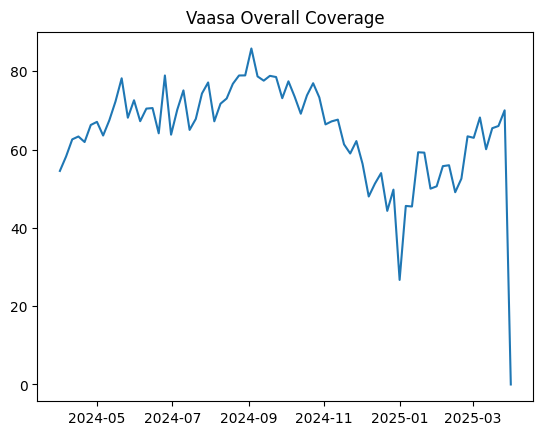

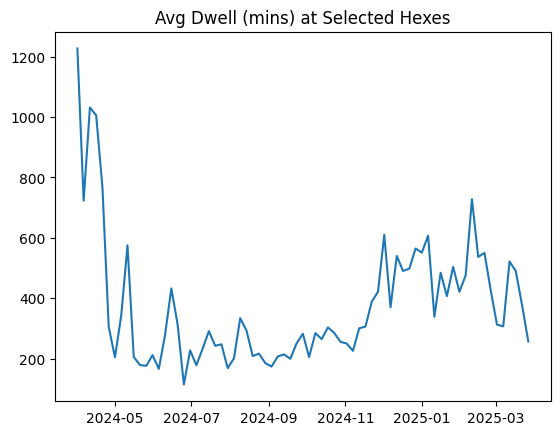

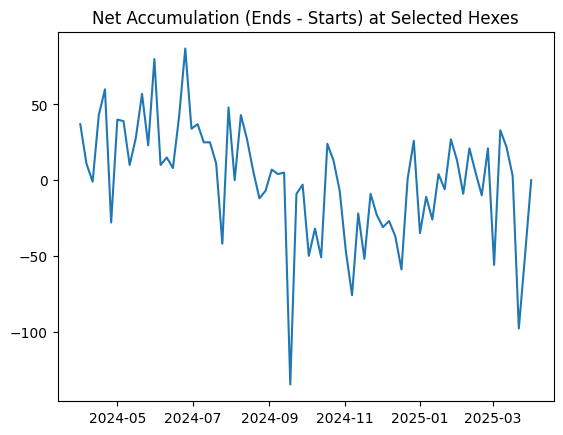

In [98]:
# Fleet coverage + operational metrics (H3)
# This section keeps the same "overall coverage" definition (unique vehicles touched by selected hexes)
# and adds dwell/net-accumulation metrics.

dict_scores_verification = {x: 0 for x in predefined_locations_h3}
dict_periodiccoverage = {}

selected_cells = set(predefined_locations_h3)

for interval in list_time_intervals:
    print(f"Checking datetime interval {interval}")
    starttime = interval[0]
    endtime = interval[1]

    df_interval = df_rides[(df_rides['end_time'] >= starttime) & (df_rides['end_time'] < endtime)]

    # Build END-hex -> [vehicle_ids] for this interval
    if 'end_h3' in df_interval.columns and 'end_in_bounds' in df_interval.columns:
        df_end = df_interval[df_interval['end_in_bounds'] & df_interval['end_h3'].notna()]
        dict_rides_interval = df_end.groupby('end_h3')['vehicle_id'].apply(list).to_dict()
    else:
        dict_rides_interval = {}

    unique_vehicles_count_interval = int(df_interval['vehicle_id'].nunique())

    # --- Existing coverage verification logic (same greedy logic, restricted to selected hexes) ---
    ID_visited = set()
    ordered_locations = []

    # Copy lists so we can blank out chosen cells without mutating original groupings
    dict_rides_interval = {k: list(v) for k, v in dict_rides_interval.items()}

    for i in range(len(predefined_locations_h3)):
        highest = {'location': None, 'value': 0, 'visited': []}
        for hex_id in predefined_locations_h3:
            vehicle_ids = dict_rides_interval.get(hex_id, [])
            chargecount = len(vehicle_ids)
            unique_vehicles = get_unique_vehicles(vehicle_ids, ID_visited)
            if unique_vehicles_count_interval == 0:
                fleetcoverage = 0
            else:
                fleetcoverage = len(unique_vehicles) / unique_vehicles_count_interval * 100
            value = F_r(chargecount, fleetcoverage)
            if value > highest['value']:
                highest['location'] = hex_id
                highest['value'] = value
                highest['visited'] = unique_vehicles

        if highest['location'] is not None:
            ordered_locations.append(highest)
            ID_visited.update(highest['visited'])
            dict_rides_interval[highest['location']] = []

    for i in range(len(ordered_locations)):
        dict_scores_verification[ordered_locations[i]['location']] += score_weights[i]

    list_uniquevehicleids = df_interval['vehicle_id'].unique().tolist()
    if len(list_uniquevehicleids) != 0:
        overallcoverage = len(ID_visited) / len(list_uniquevehicleids) * 100
    else:
        overallcoverage = 0

    # --- Added operational metrics (per time bucket) ---
    dwell_total = df_interval['dwell_to_next_start_mins'] if 'dwell_to_next_start_mins' in df_interval.columns else pd.Series([], dtype='float64')

    end_rides_total = len(df_interval)
    avg_dwell_total = float(dwell_total.mean()) if len(dwell_total) else np.nan
    median_dwell_total = float(dwell_total.median()) if len(dwell_total) else np.nan
    dwells_ge_30_total = int((dwell_total >= 30).sum()) if len(dwell_total) else 0
    dwells_ge_60_total = int((dwell_total >= 60).sum()) if len(dwell_total) else 0
    dwells_ge_120_total = int((dwell_total >= 120).sum()) if len(dwell_total) else 0

    # Metrics at the selected station hexes (I_S hexes)
    if 'end_h3' in df_interval.columns:
        end_mask = df_interval['end_in_bounds'] if 'end_in_bounds' in df_interval.columns else pd.Series(True, index=df_interval.index)
        df_interval_end_in_bounds = df_interval[end_mask & df_interval['end_h3'].notna()]
        ends_selected = df_interval_end_in_bounds[df_interval_end_in_bounds['end_h3'].isin(selected_cells)]
    else:
        ends_selected = df_interval.iloc[0:0]

    dwell_selected = ends_selected['dwell_to_next_start_mins'] if 'dwell_to_next_start_mins' in ends_selected.columns else pd.Series([], dtype='float64')
    end_rides_selected = len(ends_selected)
    avg_dwell_selected = float(dwell_selected.mean()) if len(dwell_selected) else np.nan
    median_dwell_selected = float(dwell_selected.median()) if len(dwell_selected) else np.nan
    dwells_ge_30_selected = int((dwell_selected >= 30).sum()) if len(dwell_selected) else 0
    dwells_ge_60_selected = int((dwell_selected >= 60).sum()) if len(dwell_selected) else 0
    dwells_ge_120_selected = int((dwell_selected >= 120).sum()) if len(dwell_selected) else 0

    # Net accumulation at selected hexes: ends - starts (same time bucket)
    if 'start_h3' in df_interval.columns:
        start_mask = df_interval['start_in_bounds'] if 'start_in_bounds' in df_interval.columns else pd.Series(True, index=df_interval.index)
        df_interval_start_in_bounds = df_interval[start_mask & df_interval['start_h3'].notna()]
        starts_selected = df_interval_start_in_bounds[df_interval_start_in_bounds['start_h3'].isin(selected_cells)]
        start_rides_selected = len(starts_selected)
        net_accum_selected = end_rides_selected - start_rides_selected
    else:
        start_rides_selected = np.nan
        net_accum_selected = np.nan

    dict_periodiccoverage[interval] = {
        'overallcoverage': overallcoverage,
        'end_rides_total': end_rides_total,
        'avg_dwell_mins_total': avg_dwell_total,
        'median_dwell_mins_total': median_dwell_total,
        'dwells_ge_30_total': dwells_ge_30_total,
        'dwells_ge_60_total': dwells_ge_60_total,
        'dwells_ge_120_total': dwells_ge_120_total,
        'end_rides_selected': end_rides_selected,
        'avg_dwell_mins_selected': avg_dwell_selected,
        'median_dwell_mins_selected': median_dwell_selected,
        'dwells_ge_30_selected': dwells_ge_30_selected,
        'dwells_ge_60_selected': dwells_ge_60_selected,
        'dwells_ge_120_selected': dwells_ge_120_selected,
        'start_rides_selected': start_rides_selected,
        'net_accum_selected': net_accum_selected,
    }
    print(f"Overall coverage (%): {overallcoverage}")

# Display the per-bucket metrics as a table
rows = []
for interval, metrics in dict_periodiccoverage.items():
    rows.append({
        'interval_start': interval[0],
        'interval_end': interval[1],
        **metrics,
    })

df_bucket_metrics = pd.DataFrame(rows).sort_values('interval_start')
df_bucket_metrics

# Existing coverage chart
x_time = df_bucket_metrics['interval_start'].tolist()
y_overallcoverage = df_bucket_metrics['overallcoverage'].tolist()
plt.plot(x_time, y_overallcoverage)
plt.title("Vaasa Overall Coverage")
plt.show()

# Optional: quick charts for added metrics
plt.plot(x_time, df_bucket_metrics['avg_dwell_mins_selected'].tolist())
plt.title("Avg Dwell (mins) at Selected Hexes")
plt.show()

plt.plot(x_time, df_bucket_metrics['net_accum_selected'].tolist())
plt.title("Net Accumulation (Ends - Starts) at Selected Hexes")
plt.show()

In [99]:
# Metrics for ALL hexes within TIME_PERIOD (used for map tooltips)
# We compute per-hex end/start/dwell/net-accumulation metrics + daily end-ride distribution.
# Then we attach a station score (from the greedy optimiser) and compute a rank for every hex.

selected_cells = set(predefined_locations_h3)
period_start, period_end = TIME_PERIOD

# Filter to TIME_PERIOD
_df_end_tp = df_rides[(df_rides['end_time'] >= period_start) & (df_rides['end_time'] < period_end)].copy()
_df_start_tp = df_rides[(df_rides['start_time'] >= period_start) & (df_rides['start_time'] < period_end)].copy()

# --- End-based metrics (for ALL hexes with end activity) ---
if 'end_h3' in _df_end_tp.columns:
    end_mask = _df_end_tp['end_in_bounds'] if 'end_in_bounds' in _df_end_tp.columns else pd.Series(True, index=_df_end_tp.index)
    df_end_all = _df_end_tp[end_mask & _df_end_tp['end_h3'].notna()].copy()
else:
    df_end_all = _df_end_tp.iloc[0:0].copy()

if len(df_end_all):
    g_end = df_end_all.groupby('end_h3')
    end_counts = g_end.size().rename('end_rides')

    # Dwell metrics are based on SAME-LOCATION dwell only (within DWELL_SAME_LOC_RADIUS_M);
    # rows outside radius have dwell_same_loc_mins = NaN and are excluded.
    dwell_col = 'dwell_same_loc_mins' if 'dwell_same_loc_mins' in df_end_all.columns else 'dwell_to_next_start_mins'

    avg_dwell = g_end[dwell_col].mean().rename('avg_dwell_mins')
    med_dwell = g_end[dwell_col].median().rename('median_dwell_mins')
    ge_30 = g_end[dwell_col].apply(lambda s: (s >= 30).sum()).rename('dwells_ge_30')
    ge_60 = g_end[dwell_col].apply(lambda s: (s >= 60).sum()).rename('dwells_ge_60')
    ge_120 = g_end[dwell_col].apply(lambda s: (s >= 120).sum()).rename('dwells_ge_120')
    p90_dwell = g_end[dwell_col].quantile(0.9).rename('p90_dwell_mins')

    # Denominator for shares is ONLY ends with defined same-location dwell
    dwell_defined = g_end[dwell_col].apply(lambda s: s.notna().sum()).rename('dwells_defined')

    df_hex_metrics_all = pd.concat([end_counts, avg_dwell, med_dwell, p90_dwell, ge_30, ge_60, ge_120, dwell_defined], axis=1)

    df_hex_metrics_all['share_dwells_ge_60_pct'] = np.where(
        df_hex_metrics_all['dwells_defined'] > 0,
        (df_hex_metrics_all['dwells_ge_60'] / df_hex_metrics_all['dwells_defined']) * 100.0,
        np.nan,
    )

    # Daily end-ride stats per hex within TIME_PERIOD (include 0 days)
    _df_daily = df_end_all[['end_h3', 'end_time', dwell_col]].copy()
    _df_daily = _df_daily.rename(columns={dwell_col: 'dwell_mins'})
    _df_daily['end_day'] = _df_daily['end_time'].dt.floor('D')

    # Expose radius (meters) in the metrics table for UI labeling
    try:
        df_hex_metrics_all['dwell_same_loc_radius_m'] = float(globals().get('DWELL_SAME_LOC_RADIUS_M', np.nan))
    except Exception:
        df_hex_metrics_all['dwell_same_loc_radius_m'] = np.nan

    start_day = pd.Timestamp(period_start).floor('D')
    end_day_exclusive = pd.Timestamp(period_end).floor('D')
    all_days = pd.date_range(start_day, end_day_exclusive - pd.Timedelta(days=1), freq='D')
    weekday_days = [d for d in all_days if d.dayofweek < 5]
    weekend_days = [d for d in all_days if d.dayofweek >= 5]

    # Daily dwell stats (TOTAL dwell minutes per day; include 0-days)
    # For each (hex, day): total_dwell_minutes = sum(dwell_mins)
    # Then across all days in TIME_PERIOD, compute min/median/mean/max of that daily total.
    dwell_pivot = None
    try:
        daily_dwell_sum = (
            _df_daily.groupby(['end_h3', 'end_day'])['dwell_mins']
            .sum()
            .rename('daily_dwell_sum')
            .reset_index()
        )

        if len(all_days):
            dwell_pivot = (
                daily_dwell_sum.pivot(index='end_h3', columns='end_day', values='daily_dwell_sum')
                .reindex(index=df_hex_metrics_all.index)
                .reindex(columns=all_days)
                .fillna(0)
            )

            df_hex_metrics_all['dwell_day_min'] = dwell_pivot.min(axis=1)
            df_hex_metrics_all['dwell_day_max'] = dwell_pivot.max(axis=1)
            df_hex_metrics_all['dwell_day_median'] = dwell_pivot.median(axis=1)
            df_hex_metrics_all['dwell_day_avg'] = dwell_pivot.mean(axis=1)
        else:
            df_hex_metrics_all['dwell_day_min'] = np.nan
            df_hex_metrics_all['dwell_day_max'] = np.nan
            df_hex_metrics_all['dwell_day_median'] = np.nan
            df_hex_metrics_all['dwell_day_avg'] = np.nan
    except Exception:
        df_hex_metrics_all['dwell_day_min'] = np.nan
        df_hex_metrics_all['dwell_day_max'] = np.nan
        df_hex_metrics_all['dwell_day_median'] = np.nan
        df_hex_metrics_all['dwell_day_avg'] = np.nan

    if len(all_days):
        daily_counts = (
            _df_daily.groupby(['end_h3', 'end_day'])
            .size()
            .rename('end_rides_day')
            .reset_index()
        )

        daily_pivot = (
            daily_counts.pivot(index='end_h3', columns='end_day', values='end_rides_day')
            .reindex(index=df_hex_metrics_all.index)
            .reindex(columns=all_days)
            .fillna(0)
        )

        end_daily_pivot = daily_pivot

        df_daily_stats = pd.DataFrame({
            'end_rides_day_min': end_daily_pivot.min(axis=1),
            'end_rides_day_max': end_daily_pivot.max(axis=1),
            'end_rides_day_median': end_daily_pivot.median(axis=1),
            'end_rides_day_avg': end_daily_pivot.mean(axis=1),
        })

        df_hex_metrics_all = df_hex_metrics_all.join(df_daily_stats, how='left')

        # Weekday vs weekend daily end stats (day-weighted; include 0-days within each subset)
        try:
            if len(weekday_days):
                _wd = end_daily_pivot[weekday_days]
                df_hex_metrics_all['weekday_end_day_min'] = _wd.min(axis=1)
                df_hex_metrics_all['weekday_end_day_max'] = _wd.max(axis=1)
                df_hex_metrics_all['weekday_end_day_median'] = _wd.median(axis=1)
                df_hex_metrics_all['weekday_end_day_avg'] = _wd.mean(axis=1)
            else:
                df_hex_metrics_all['weekday_end_day_min'] = np.nan
                df_hex_metrics_all['weekday_end_day_max'] = np.nan
                df_hex_metrics_all['weekday_end_day_median'] = np.nan
                df_hex_metrics_all['weekday_end_day_avg'] = np.nan

            if len(weekend_days):
                _we = end_daily_pivot[weekend_days]
                df_hex_metrics_all['weekend_end_day_min'] = _we.min(axis=1)
                df_hex_metrics_all['weekend_end_day_max'] = _we.max(axis=1)
                df_hex_metrics_all['weekend_end_day_median'] = _we.median(axis=1)
                df_hex_metrics_all['weekend_end_day_avg'] = _we.mean(axis=1)
            else:
                df_hex_metrics_all['weekend_end_day_min'] = np.nan
                df_hex_metrics_all['weekend_end_day_max'] = np.nan
                df_hex_metrics_all['weekend_end_day_median'] = np.nan
                df_hex_metrics_all['weekend_end_day_avg'] = np.nan
        except Exception:
            df_hex_metrics_all['weekday_end_day_min'] = np.nan
            df_hex_metrics_all['weekday_end_day_max'] = np.nan
            df_hex_metrics_all['weekday_end_day_median'] = np.nan
            df_hex_metrics_all['weekday_end_day_avg'] = np.nan
            df_hex_metrics_all['weekend_end_day_min'] = np.nan
            df_hex_metrics_all['weekend_end_day_max'] = np.nan
            df_hex_metrics_all['weekend_end_day_median'] = np.nan
            df_hex_metrics_all['weekend_end_day_avg'] = np.nan

        # Parked minutes per end (day-weighted median)
        # For each day with ends>0: (daily total dwell minutes) / (daily ends)
        # Then take the median across days.
        try:
            if dwell_pivot is not None:
                denom = end_daily_pivot.replace(0, np.nan)
                per_end = dwell_pivot / denom
                df_hex_metrics_all['dwell_per_end_day_median'] = per_end.median(axis=1, skipna=True)
            else:
                df_hex_metrics_all['dwell_per_end_day_median'] = np.nan
        except Exception:
            df_hex_metrics_all['dwell_per_end_day_median'] = np.nan
    else:
        df_hex_metrics_all['end_rides_day_min'] = np.nan
        df_hex_metrics_all['end_rides_day_max'] = np.nan
        df_hex_metrics_all['end_rides_day_median'] = np.nan
        df_hex_metrics_all['end_rides_day_avg'] = np.nan

    # Ensure daily stat columns exist even if something above short-circuited
    for _c in [
        'dwell_day_min', 'dwell_day_max', 'dwell_day_median', 'dwell_day_avg', 'dwell_per_end_day_median',
        'weekday_end_day_min', 'weekday_end_day_max', 'weekday_end_day_median', 'weekday_end_day_avg',
        'weekend_end_day_min', 'weekend_end_day_max', 'weekend_end_day_median', 'weekend_end_day_avg',
        'dwells_defined', 'dwell_same_loc_radius_m',
    ]:
        if _c not in df_hex_metrics_all.columns:
            df_hex_metrics_all[_c] = np.nan

    # --- Monthly vehicle presence (daily unique vehicles present per hex) ---
    # Definition: for each (hex, day), count unique vehicles that either STARTED or ENDED in this hex that day.
    # For each month in TIME_PERIOD, compute min/median/mean/max across days in that month (including 0-activity days).
    try:
        # Build (hex, day) end events (non-unique)
        df_ends_ev = df_end_all[['end_h3', 'end_time', 'vehicle_id']].copy()
        df_ends_ev = df_ends_ev.rename(columns={'end_h3': 'h3', 'end_time': 't'})
        df_ends_ev['day'] = df_ends_ev['t'].dt.floor('D')
        df_ends_ev = df_ends_ev[['h3', 'day', 'vehicle_id']].dropna()

        # Daily end events per (hex, day)
        # (counts ride ends; same vehicle can end multiple rides in a day)
        daily_present = (
            df_ends_ev.groupby(['h3', 'day'])['vehicle_id']
            .size()
            .rename('end_events')
            .reset_index()
        )

        # Months spanned by TIME_PERIOD (include partial start/end months)
        _last_obs_day = (end_day_exclusive - pd.Timedelta(days=1))
        month0 = pd.Timestamp(start_day).replace(day=1)
        monthN = pd.Timestamp(_last_obs_day).replace(day=1)
        month_starts = pd.date_range(month0, monthN, freq='MS')
        month_labels = [d.strftime('%Y-%m') for d in month_starts]

        monthly_html = {}
        for m_start, m_label in zip(month_starts, month_labels):
            m_end = (m_start + pd.offsets.MonthBegin(1))

            days_full = pd.date_range(m_start, m_end - pd.Timedelta(days=1), freq='D')
            days_obs = [d for d in days_full if (d >= start_day) and (d < end_day_exclusive)]

            is_first_edge = (m_start.year == start_day.year and m_start.month == start_day.month and start_day.day != 1)
            is_last_edge = (m_start.year == _last_obs_day.year and m_start.month == _last_obs_day.month and _last_obs_day.day != _last_obs_day.days_in_month)
            use_full = bool(is_first_edge or is_last_edge)

            days_in_month = days_full if use_full else pd.date_range(max(start_day, m_start), min(end_day_exclusive, m_end) - pd.Timedelta(days=1), freq='D')
            if not len(days_in_month):
                continue

            # Subset for this month and pivot
            m_sub = daily_present[(daily_present['day'] >= days_in_month.min()) & (daily_present['day'] <= days_in_month.max())]
            if len(m_sub):
                pivot = (
                    m_sub.pivot(index='h3', columns='day', values='end_events')
                    .reindex(index=df_hex_metrics_all.index)
                    .reindex(columns=days_in_month)
                )
            else:
                pivot = pd.DataFrame(np.nan, index=df_hex_metrics_all.index, columns=days_in_month)

            # Impute ONLY outside-period days for edge months with observed month mean per hex
            if use_full and len(days_obs):
                outside_cols = [d for d in days_in_month if d not in set(days_obs)]
                try:
                    row_mean = pivot[days_obs].mean(axis=1, skipna=True)
                except Exception:
                    row_mean = pd.Series(0.0, index=pivot.index)
                if len(outside_cols):
                    pivot[outside_cols] = pivot[outside_cols].T.fillna(row_mean).T
                # Observed days missing in the pivot are true zeros
                pivot[days_obs] = pivot[days_obs].fillna(0)
                pivot = pivot.fillna(0)
            else:
                pivot = pivot.fillna(0)

            # Weekday/weekend medians within this month
            _wd_cols = [d for d in days_in_month if d.dayofweek < 5]
            _we_cols = [d for d in days_in_month if d.dayofweek >= 5]

            monthly_html[m_label] = {
                'min': pivot.min(axis=1),
                'max': pivot.max(axis=1),
                'median': pivot.median(axis=1),
                'avg': pivot.mean(axis=1),
                'weekday_median': (pivot[_wd_cols].median(axis=1) if len(_wd_cols) else pd.Series(np.nan, index=pivot.index)),
                'weekend_median': (pivot[_we_cols].median(axis=1) if len(_we_cols) else pd.Series(np.nan, index=pivot.index)),
            }

        # Build monthly tables per hex + a dual-line sparkline for weekday vs weekend MONTHLY MEDIAN ends/day
        rows = []
        weekpart_rows = []
        sparklines = []
        all_median_sparklines = []

        def _sparkline_svg_one(values, labels=None, width=170, height=34, stroke='#2563eb'):
            vals = [float(v) for v in values]
            labs = [str(x) for x in labels] if labels else []
            if not len(vals):
                return ''
            if labs and len(labs) != len(vals):
                labs = [f"pt{i+1}" for i in range(len(vals))]
            vmin = min(vals)
            vmax = max(vals)
            if vmax == vmin:
                vmax = vmin + 1.0

            pad_x = 2
            pad_y = 4
            w = max(10, int(width))
            h = max(10, int(height))
            if labs:
                h = max(h, 42)
            inner_w = w - 2 * pad_x
            inner_h = h - 2 * pad_y

            pts = []
            for i, v in enumerate(vals):
                x = pad_x + (inner_w * i / (len(vals) - 1 if len(vals) > 1 else 1))
                y = pad_y + (inner_h * (1.0 - (v - vmin) / (vmax - vmin)))
                pts.append((x, y))

            def _label_stride(n):
                if n <= 8:
                    return 1
                if n <= 14:
                    return 2
                if n <= 24:
                    return 3
                return max(1, n // 8)

            label_svg = ''
            label_pad = 12 if labs else 0
            if labs:
                stride = _label_stride(len(labs))
                for i, (x, _) in enumerate(pts):
                    if i % stride != 0:
                        continue
                    lab = labs[i]
                    if len(lab) >= 7 and lab[4] == '-':
                        lab = lab[2:]
                    safe_lab = (lab.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;'))
                    label_svg += (
                        f"<text x='{x:.2f}' y='{h + label_pad - 2}' text-anchor='middle' "
                        f"font-size='9' fill='#6B7280'>{safe_lab}</text>"
                    )

            points_attr = ' '.join([f"{x:.2f},{y:.2f}" for x, y in pts])
            base_y = pad_y + inner_h
            svg_h = h + label_pad
            return (
                f"<svg width='{w}' height='{svg_h}' viewBox='0 0 {w} {svg_h}' xmlns='http://www.w3.org/2000/svg' style='display:block;'>"
                f"<polyline fill='none' stroke='{stroke}' stroke-width='2' stroke-linecap='round' stroke-linejoin='round' points='{points_attr}' />"
                f"<line x1='{pad_x}' y1='{base_y:.2f}' x2='{w-pad_x}' y2='{base_y:.2f}' stroke='#E5E7EB' stroke-width='1' />"
                f"{label_svg}"
                f"</svg>"
            )

        def _sparkline_svg_one_with_titles(values, labels, width=170, height=34, stroke='#2563eb'):
            vals = [float(v) for v in values]
            labs = [str(x) for x in labels]
            if not len(vals):
                return ''
            if len(labs) != len(vals):
                labs = [f"pt{i+1}" for i in range(len(vals))]

            vmin = min(vals)
            vmax = max(vals)
            if vmax == vmin:
                vmax = vmin + 1.0

            pad_x = 2
            pad_y = 4
            w = max(10, int(width))
            h = max(10, int(height))
            if labs:
                h = max(h, 42)
            inner_w = w - 2 * pad_x
            inner_h = h - 2 * pad_y

            pts = []
            for i, v in enumerate(vals):
                x = pad_x + (inner_w * i / (len(vals) - 1 if len(vals) > 1 else 1))
                y = pad_y + (inner_h * (1.0 - (v - vmin) / (vmax - vmin)))
                pts.append((x, y))

            def _label_stride(n):
                if n <= 8:
                    return 1
                if n <= 14:
                    return 2
                if n <= 24:
                    return 3
                return max(1, n // 8)

            label_svg = ''
            label_pad = 12 if labs else 0
            if labs:
                stride = _label_stride(len(labs))
                for i, (x, _) in enumerate(pts):
                    if i % stride != 0:
                        continue
                    lab = labs[i]
                    if len(lab) >= 7 and lab[4] == '-':
                        lab = lab[2:]
                    safe_lab = (lab.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;'))
                    label_svg += (
                        f"<text x='{x:.2f}' y='{h + label_pad - 2}' text-anchor='middle' "
                        f"font-size='9' fill='#6B7280'>{safe_lab}</text>"
                    )

            points_attr = ' '.join([f"{x:.2f},{y:.2f}" for x, y in pts])
            base_y = pad_y + inner_h

            # Invisible thicker polyline for easier hover
            circles = []
            for (x, y), lab, v in zip(pts, labs, vals):
                safe_lab = (lab.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;'))
                circles.append(
                    f"<circle cx='{x:.2f}' cy='{y:.2f}' r='4' fill='{stroke}' opacity='0.0' pointer-events='all'>"
                    f"<title>{safe_lab}: {v:.2f}</title></circle>"
                )

            svg_h = h + label_pad
            return (
                f"<svg width='{w}' height='{svg_h}' viewBox='0 0 {w} {svg_h}' xmlns='http://www.w3.org/2000/svg' style='display:block;'>"
                f"<polyline fill='none' stroke='{stroke}' stroke-width='2' stroke-linecap='round' stroke-linejoin='round' points='{points_attr}' />"
                f"<polyline fill='none' stroke='{stroke}' stroke-width='10' stroke-linecap='round' stroke-linejoin='round' points='{points_attr}' opacity='0.0' pointer-events='stroke'/>"
                + ''.join(circles) +
                f"<line x1='{pad_x}' y1='{base_y:.2f}' x2='{w-pad_x}' y2='{base_y:.2f}' stroke='#E5E7EB' stroke-width='1' />"
                f"{label_svg}"
                f"</svg>"
            )

        def _sparkline_svg_two(values_a, values_b, labels=None, width=170, height=34, stroke_a='#2563eb', stroke_b='#f97316'):
            a = [float(v) for v in values_a]
            b = [float(v) for v in values_b]
            labs = [str(x) for x in labels] if labels else []
            if not (len(a) and len(b)):
                return ''
            if labs and len(labs) != len(a):
                labs = [f"pt{i+1}" for i in range(len(a))]

            vmin = min(min(a), min(b))
            vmax = max(max(a), max(b))
            if vmax == vmin:
                vmax = vmin + 1.0

            pad_x = 2
            pad_y = 4
            w = max(10, int(width))
            h = max(10, int(height))
            if labs:
                h = max(h, 42)
            inner_w = w - 2 * pad_x
            inner_h = h - 2 * pad_y

            def _pts(vals):
                pts = []
                for i, v in enumerate(vals):
                    x = pad_x + (inner_w * i / (len(vals) - 1 if len(vals) > 1 else 1))
                    y = pad_y + (inner_h * (1.0 - (v - vmin) / (vmax - vmin)))
                    pts.append((x, y))
                return pts, ' '.join([f"{x:.2f},{y:.2f}" for x, y in pts])

            pts_a, points_a = _pts(a)
            pts_b, points_b = _pts(b)
            base_y = pad_y + inner_h

            def _label_stride(n):
                if n <= 8:
                    return 1
                if n <= 14:
                    return 2
                if n <= 24:
                    return 3
                return max(1, n // 8)

            label_svg = ''
            label_pad = 12 if labs else 0
            if labs:
                stride = _label_stride(len(labs))
                for i, (x, _) in enumerate(pts_a):
                    if i % stride != 0:
                        continue
                    lab = labs[i]
                    if len(lab) >= 7 and lab[4] == '-':
                        lab = lab[2:]
                    safe_lab = (lab.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;'))
                    label_svg += (
                        f"<text x='{x:.2f}' y='{h + label_pad - 2}' text-anchor='middle' "
                        f"font-size='9' fill='#6B7280'>{safe_lab}</text>"
                    )

            # Dots + tooltips for each month point
            dots = []
            for i, ((x1, y1), (x2, y2)) in enumerate(zip(pts_a, pts_b)):
                lab = labs[i] if i < len(labs) else f"pt{i+1}"
                safe_lab = (lab.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;'))
                dots.append(
                    f"<circle cx='{x1:.2f}' cy='{y1:.2f}' r='2.6' fill='{stroke_a}' opacity='0.9' pointer-events='none'/>"
                )
                dots.append(
                    f"<circle cx='{x2:.2f}' cy='{y2:.2f}' r='2.6' fill='{stroke_b}' opacity='0.9' pointer-events='none'/>"
                )
                # Bigger invisible hit areas for hover
                dots.append(
                    f"<circle class='hx-sparkpt' data-label='{safe_lab} • Weekday: {a[i]:.2f}' cx='{x1:.2f}' cy='{y1:.2f}' r='7' fill='{stroke_a}' opacity='0.0' pointer-events='all'/>"
                )
                dots.append(
                    f"<circle class='hx-sparkpt' data-label='{safe_lab} • Weekend: {b[i]:.2f}' cx='{x2:.2f}' cy='{y2:.2f}' r='7' fill='{stroke_b}' opacity='0.0' pointer-events='all'/>"
                )

            svg_h = h + label_pad
            return (
                f"<svg width='100%' height='{svg_h}' viewBox='0 0 {w} {svg_h}' xmlns='http://www.w3.org/2000/svg' style='display:block;'>"
                f"<polyline fill='none' stroke='{stroke_a}' stroke-width='2' stroke-linecap='round' stroke-linejoin='round' points='{points_a}' />"
                f"<polyline fill='none' stroke='{stroke_b}' stroke-width='2' stroke-linecap='round' stroke-linejoin='round' points='{points_b}' />"
                + ''.join(dots) +
                f"<line x1='{pad_x}' y1='{base_y:.2f}' x2='{w-pad_x}' y2='{base_y:.2f}' stroke='#E5E7EB' stroke-width='1' />"
                f"{label_svg}"
                f"</svg>"
            )

        # --- Peak 15-min continuous presence (vehicles) ---
        # For each day: maximum number of vehicles continuously present in the END hex over any 15-minute window.
        # Presence is assumed for the interval [end_time, next_start_time) regardless of where the next start occurs.
        monthly_peak15m = None
        try:
            _need_cols = ['end_h3', 'end_time', 'next_start_time']
            if all([c in df_end_all.columns for c in _need_cols]) and len(all_days):
                _pres = df_end_all[_need_cols].copy()
                _pres = _pres[_pres['next_start_time'].notna()]
                _pres = _pres[_pres['end_time'].notna()]

                # Eligible window-start range per interval: w in [t0, t1-15m]
                _pres['w0'] = _pres['end_time']
                _pres['w1'] = _pres['next_start_time'] - pd.Timedelta(minutes=15)
                _pres = _pres[_pres['w1'] >= _pres['w0']]

                if len(_pres):
                    _pres['d0'] = _pres['w0'].dt.floor('D')
                    _pres['d1'] = _pres['w1'].dt.floor('D')

                    # Build per-day eligible window-start intervals, splitting only when an interval spans days.
                    _rows = []

                    _single = _pres[_pres['d0'] == _pres['d1']].copy()
                    if len(_single):
                        _day = _single['d0']
                        _day_last = _day + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
                        _single['day'] = _day
                        _single['ws'] = _single[['w0', 'd0']].max(axis=1)
                        _single['we'] = pd.concat([_single['w1'], _day_last], axis=1).min(axis=1)
                        _single = _single[_single['we'] >= _single['ws']]
                        _rows.append(_single[['end_h3', 'day', 'ws', 'we']])

                    _multi = _pres[_pres['d0'] != _pres['d1']]
                    if len(_multi):
                        for r in _multi.itertuples(index=False):
                            h = getattr(r, 'end_h3')
                            w0 = getattr(r, 'w0')
                            w1 = getattr(r, 'w1')
                            d = getattr(r, 'd0')
                            d1 = getattr(r, 'd1')
                            # iterate day by day (rare; only for long dwells)
                            while d <= d1:
                                day_last = d + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
                                ws = max(w0, d)
                                we = min(w1, day_last)
                                if we >= ws:
                                    _rows.append(pd.DataFrame({'end_h3': [h], 'day': [d], 'ws': [ws], 'we': [we]}))
                                d = d + pd.Timedelta(days=1)

                    if len(_rows):
                        _win = pd.concat(_rows, ignore_index=True)

                        import numpy as _np
                        def _peak_overlap(g):
                            s = g['ws'].to_numpy()
                            e = g['we'].to_numpy()
                            t = _np.concatenate([s, e])
                            dlt = _np.concatenate([_np.ones(len(s), dtype=_np.int32), -_np.ones(len(e), dtype=_np.int32)])
                            # sort by time asc; for ties, +1 before -1 (so end is treated as inclusive)
                            order = _np.lexsort((-dlt, t))
                            c = _np.cumsum(dlt[order])
                            return int(c.max()) if len(c) else 0

                        peaks = _win.groupby(['end_h3', 'day'], sort=False).apply(_peak_overlap, include_groups=False)
                        daily_peak = (
                            peaks.unstack('day')
                            .reindex(index=df_hex_metrics_all.index)
                            .reindex(columns=all_days)
                            .fillna(0)
                        )

                        # Monthly average of daily peaks (all days, weekdays only, weekends only)
                        monthly_peak15m = {}
                        monthly_peak15m_wd = {}
                        monthly_peak15m_we = {}
                        for m_start, m_label in zip(month_starts, month_labels):
                            m_end = (m_start + pd.offsets.MonthBegin(1))

                            days_full = pd.date_range(m_start, m_end - pd.Timedelta(days=1), freq='D')
                            days_obs = [d for d in days_full if (d >= start_day) and (d < end_day_exclusive)]

                            is_first_edge = (m_start.year == start_day.year and m_start.month == start_day.month and start_day.day != 1)
                            is_last_edge = (m_start.year == _last_obs_day.year and m_start.month == _last_obs_day.month and _last_obs_day.day != _last_obs_day.days_in_month)
                            use_full = bool(is_first_edge or is_last_edge)

                            cols = days_full if use_full else days_obs
                            if not len(cols):
                                continue

                            # All-days monthly mean with edge-month imputation
                            dp = daily_peak.reindex(columns=cols)
                            if use_full and len(days_obs):
                                outside_cols = [d for d in cols if d not in set(days_obs)]
                                try:
                                    row_mean = dp[days_obs].mean(axis=1, skipna=True)
                                except Exception:
                                    row_mean = pd.Series(0.0, index=dp.index)
                                if len(outside_cols):
                                    dp[outside_cols] = dp[outside_cols].T.fillna(row_mean).T
                                dp[days_obs] = dp[days_obs].fillna(0)
                                dp = dp.fillna(0)
                            else:
                                dp = dp.fillna(0)
                            monthly_peak15m[m_label] = dp.mean(axis=1)

                            # Weekday/weekend monthly means with edge-month imputation
                            cols_wd = [d for d in cols if d.dayofweek < 5]
                            cols_we = [d for d in cols if d.dayofweek >= 5]
                            obs_wd = [d for d in days_obs if d.dayofweek < 5]
                            obs_we = [d for d in days_obs if d.dayofweek >= 5]

                            dp_wd = daily_peak.reindex(columns=cols_wd)
                            if use_full and len(obs_wd):
                                outside_wd = [d for d in cols_wd if d not in set(obs_wd)]
                                try:
                                    row_mean_wd = dp_wd[obs_wd].mean(axis=1, skipna=True)
                                except Exception:
                                    row_mean_wd = pd.Series(0.0, index=dp_wd.index)
                                if len(outside_wd):
                                    dp_wd[outside_wd] = dp_wd[outside_wd].T.fillna(row_mean_wd).T
                                dp_wd[obs_wd] = dp_wd[obs_wd].fillna(0)
                                dp_wd = dp_wd.fillna(0)
                            else:
                                dp_wd = dp_wd.fillna(0)
                            monthly_peak15m_wd[m_label] = dp_wd.mean(axis=1) if len(cols_wd) else pd.Series(0.0, index=df_hex_metrics_all.index)

                            dp_we = daily_peak.reindex(columns=cols_we)
                            if use_full and len(obs_we):
                                outside_we = [d for d in cols_we if d not in set(obs_we)]
                                try:
                                    row_mean_we = dp_we[obs_we].mean(axis=1, skipna=True)
                                except Exception:
                                    row_mean_we = pd.Series(0.0, index=dp_we.index)
                                if len(outside_we):
                                    dp_we[outside_we] = dp_we[outside_we].T.fillna(row_mean_we).T
                                dp_we[obs_we] = dp_we[obs_we].fillna(0)
                                dp_we = dp_we.fillna(0)
                            else:
                                dp_we = dp_we.fillna(0)
                            monthly_peak15m_we[m_label] = dp_we.mean(axis=1) if len(cols_we) else pd.Series(0.0, index=df_hex_metrics_all.index)
        except Exception:
            monthly_peak15m = None

        # --- Peak 1-min continuous presence (vehicles) ---
        # For each day: maximum number of vehicles continuously present in the END hex over any 1-minute window.
        # Presence is assumed for the interval [end_time, next_start_time) regardless of where the next start occurs.
        monthly_peak1m = None
        try:
            _need_cols = ['end_h3', 'end_time', 'next_start_time']
            if all([c in df_end_all.columns for c in _need_cols]) and len(all_days):
                _pres = df_end_all[_need_cols].copy()
                _pres = _pres[_pres['next_start_time'].notna()]
                _pres = _pres[_pres['end_time'].notna()]

                # Eligible window-start range per interval: w in [t0, t1-1m]
                _pres['w0'] = _pres['end_time']
                _pres['w1'] = _pres['next_start_time'] - pd.Timedelta(minutes=1)
                _pres = _pres[_pres['w1'] >= _pres['w0']]

                if len(_pres):
                    _pres['d0'] = _pres['w0'].dt.floor('D')
                    _pres['d1'] = _pres['w1'].dt.floor('D')

                    # Build per-day eligible window-start intervals, splitting only when an interval spans days.
                    _rows = []

                    _single = _pres[_pres['d0'] == _pres['d1']].copy()
                    if len(_single):
                        _day = _single['d0']
                        _day_last = _day + pd.Timedelta(days=1) - pd.Timedelta(minutes=1)
                        _single['day'] = _day
                        _single['ws'] = _single[['w0', 'd0']].max(axis=1)
                        _single['we'] = pd.concat([_single['w1'], _day_last], axis=1).min(axis=1)
                        _single = _single[_single['we'] >= _single['ws']]
                        _rows.append(_single[['end_h3', 'day', 'ws', 'we']])

                    _multi = _pres[_pres['d0'] != _pres['d1']]
                    if len(_multi):
                        for r in _multi.itertuples(index=False):
                            h = getattr(r, 'end_h3')
                            w0 = getattr(r, 'w0')
                            w1 = getattr(r, 'w1')
                            d = getattr(r, 'd0')
                            d1 = getattr(r, 'd1')
                            # iterate day by day (rare; only for long dwells)
                            while d <= d1:
                                day_last = d + pd.Timedelta(days=1) - pd.Timedelta(minutes=1)
                                ws = max(w0, d)
                                we = min(w1, day_last)
                                if we >= ws:
                                    _rows.append(pd.DataFrame({'end_h3': [h], 'day': [d], 'ws': [ws], 'we': [we]}))
                                d = d + pd.Timedelta(days=1)

                    if len(_rows):
                        _win = pd.concat(_rows, ignore_index=True)

                        import numpy as _np
                        def _peak_overlap(g):
                            s = g['ws'].to_numpy()
                            e = g['we'].to_numpy()
                            t = _np.concatenate([s, e])
                            dlt = _np.concatenate([_np.ones(len(s), dtype=_np.int32), -_np.ones(len(e), dtype=_np.int32)])
                            # sort by time asc; for ties, +1 before -1 (so end is treated as inclusive)
                            order = _np.lexsort((-dlt, t))
                            c = _np.cumsum(dlt[order])
                            return int(c.max()) if len(c) else 0

                        peaks = _win.groupby(['end_h3', 'day'], sort=False).apply(_peak_overlap, include_groups=False)
                        daily_peak = (
                            peaks.unstack('day')
                            .reindex(index=df_hex_metrics_all.index)
                            .reindex(columns=all_days)
                            .fillna(0)
                        )

                        # Monthly average of daily peaks (all days, weekdays only, weekends only)
                        monthly_peak1m = {}
                        monthly_peak1m_wd = {}
                        monthly_peak1m_we = {}
                        for m_start, m_label in zip(month_starts, month_labels):
                            m_end = (m_start + pd.offsets.MonthBegin(1))

                            days_full = pd.date_range(m_start, m_end - pd.Timedelta(days=1), freq='D')
                            days_obs = [d for d in days_full if (d >= start_day) and (d < end_day_exclusive)]

                            is_first_edge = (m_start.year == start_day.year and m_start.month == start_day.month and start_day.day != 1)
                            is_last_edge = (m_start.year == _last_obs_day.year and m_start.month == _last_obs_day.month and _last_obs_day.day != _last_obs_day.days_in_month)
                            use_full = bool(is_first_edge or is_last_edge)

                            cols = days_full if use_full else days_obs
                            if not len(cols):
                                continue

                            # All-days monthly mean with edge-month imputation
                            dp = daily_peak.reindex(columns=cols)
                            if use_full and len(days_obs):
                                outside_cols = [d for d in cols if d not in set(days_obs)]
                                try:
                                    row_mean = dp[days_obs].mean(axis=1, skipna=True)
                                except Exception:
                                    row_mean = pd.Series(0.0, index=dp.index)
                                if len(outside_cols):
                                    dp[outside_cols] = dp[outside_cols].T.fillna(row_mean).T
                                dp[days_obs] = dp[days_obs].fillna(0)
                                dp = dp.fillna(0)
                            else:
                                dp = dp.fillna(0)
                            monthly_peak1m[m_label] = dp.mean(axis=1)

                            # Weekday/weekend monthly means with edge-month imputation
                            cols_wd = [d for d in cols if d.dayofweek < 5]
                            cols_we = [d for d in cols if d.dayofweek >= 5]
                            obs_wd = [d for d in days_obs if d.dayofweek < 5]
                            obs_we = [d for d in days_obs if d.dayofweek >= 5]

                            dp_wd = daily_peak.reindex(columns=cols_wd)
                            if use_full and len(obs_wd):
                                outside_wd = [d for d in cols_wd if d not in set(obs_wd)]
                                try:
                                    row_mean_wd = dp_wd[obs_wd].mean(axis=1, skipna=True)
                                except Exception:
                                    row_mean_wd = pd.Series(0.0, index=dp_wd.index)
                                if len(outside_wd):
                                    dp_wd[outside_wd] = dp_wd[outside_wd].T.fillna(row_mean_wd).T
                                dp_wd[obs_wd] = dp_wd[obs_wd].fillna(0)
                                dp_wd = dp_wd.fillna(0)
                            else:
                                dp_wd = dp_wd.fillna(0)
                            monthly_peak1m_wd[m_label] = dp_wd.mean(axis=1) if len(cols_wd) else pd.Series(0.0, index=df_hex_metrics_all.index)

                            dp_we = daily_peak.reindex(columns=cols_we)
                            if use_full and len(obs_we):
                                outside_we = [d for d in cols_we if d not in set(obs_we)]
                                try:
                                    row_mean_we = dp_we[obs_we].mean(axis=1, skipna=True)
                                except Exception:
                                    row_mean_we = pd.Series(0.0, index=dp_we.index)
                                if len(outside_we):
                                    dp_we[outside_we] = dp_we[outside_we].T.fillna(row_mean_we).T
                                dp_we[obs_we] = dp_we[obs_we].fillna(0)
                                dp_we = dp_we.fillna(0)
                            else:
                                dp_we = dp_we.fillna(0)
                            monthly_peak1m_we[m_label] = dp_we.mean(axis=1) if len(cols_we) else pd.Series(0.0, index=df_hex_metrics_all.index)
        except Exception:
            monthly_peak1m = None

        peak15_labels = list(month_labels)
        peak15_rows = []
        peak15_sparklines = []
        peak15_weekpart_rows = []
        peak15_weekpart_sparklines = []
        peak1_labels = list(month_labels)
        peak1_rows = []
        peak1_sparklines = []
        peak1_weekpart_rows = []
        peak1_weekpart_sparklines = []
        for hx in df_hex_metrics_all.index:
            parts = []
            wp_parts = []
            wd_vals = []
            we_vals = []
            all_med_vals = []
            peak15_vals = []
            peak15_parts = []
            peak15_wd_vals = []
            peak15_we_vals = []
            peak15_weekpart_parts = []
            peak1_vals = []
            peak1_parts = []
            peak1_wd_vals = []
            peak1_we_vals = []
            peak1_weekpart_parts = []

            for m_label in month_labels:
                if m_label not in monthly_html:
                    continue
                mm = monthly_html[m_label]

                parts.append(
                    f"<tr><td style='padding:2px 6px; font-weight:700; color:#374151;'>{m_label}</td>"
                    f"<td style='padding:2px 6px; text-align:right;'>{float(mm['min'].get(hx, 0)):.0f}/"
                    f"{float(mm['median'].get(hx, 0)):.0f}/"
                    f"{float(mm['avg'].get(hx, 0)):.1f}/"
                    f"{float(mm['max'].get(hx, 0)):.0f}</td></tr>"
                )

                all_m = float(mm['median'].get(hx, 0.0))
                all_med_vals.append(all_m)

                wd = float(mm['weekday_median'].get(hx, np.nan))
                we = float(mm['weekend_median'].get(hx, np.nan))
                wd_vals.append(0.0 if np.isnan(wd) else wd)
                we_vals.append(0.0 if np.isnan(we) else we)
                wp_parts.append(
                    f"<tr><td style='padding:2px 6px; font-weight:700; color:#374151;'>{m_label}</td>"
                    f"<td style='padding:2px 6px; text-align:right;'>{(wd if not np.isnan(wd) else 0):.1f} / {(we if not np.isnan(we) else 0):.1f}</td></tr>"
                )

                _p15 = 0.0
                try:
                    if monthly_peak15m is not None and m_label in monthly_peak15m:
                        _p15 = float(monthly_peak15m[m_label].get(hx, 0.0))
                except Exception:
                    _p15 = 0.0
                peak15_vals.append(_p15)
                peak15_parts.append(
                    f"<tr><td style='padding:2px 6px; font-weight:700; color:#374151;'>{m_label}</td>"
                    f"<td style='padding:2px 6px; text-align:right;'>{_p15:.2f}</td></tr>"
                )

                _p15_wd = 0.0
                _p15_we = 0.0
                try:
                    if monthly_peak15m is not None and m_label in monthly_peak15m_wd:
                        _p15_wd = float(monthly_peak15m_wd[m_label].get(hx, 0.0))
                    if monthly_peak15m is not None and m_label in monthly_peak15m_we:
                        _p15_we = float(monthly_peak15m_we[m_label].get(hx, 0.0))
                except Exception:
                    _p15_wd = 0.0
                    _p15_we = 0.0
                if np.isnan(_p15_wd):
                    _p15_wd = 0.0
                if np.isnan(_p15_we):
                    _p15_we = 0.0
                peak15_wd_vals.append(_p15_wd)
                peak15_we_vals.append(_p15_we)
                peak15_weekpart_parts.append(
                    f"<tr><td style='padding:2px 6px; font-weight:700; color:#374151;'>{m_label}</td>"
                    f"<td style='padding:2px 6px; text-align:right;'>{_p15_wd:.2f}</td>"
                    f"<td style='padding:2px 6px; text-align:right;'>{_p15_we:.2f}</td></tr>"
                )

                _p1 = 0.0
                try:
                    if monthly_peak1m is not None and m_label in monthly_peak1m:
                        _p1 = float(monthly_peak1m[m_label].get(hx, 0.0))
                except Exception:
                    _p1 = 0.0
                peak1_vals.append(_p1)
                peak1_parts.append(
                    f"<tr><td style='padding:2px 6px; font-weight:700; color:#374151;'>{m_label}</td>"
                    f"<td style='padding:2px 6px; text-align:right;'>{_p1:.2f}</td></tr>"
                )

                _p1_wd = 0.0
                _p1_we = 0.0
                try:
                    if monthly_peak1m is not None and m_label in monthly_peak1m_wd:
                        _p1_wd = float(monthly_peak1m_wd[m_label].get(hx, 0.0))
                    if monthly_peak1m is not None and m_label in monthly_peak1m_we:
                        _p1_we = float(monthly_peak1m_we[m_label].get(hx, 0.0))
                except Exception:
                    _p1_wd = 0.0
                    _p1_we = 0.0
                if np.isnan(_p1_wd):
                    _p1_wd = 0.0
                if np.isnan(_p1_we):
                    _p1_we = 0.0
                peak1_wd_vals.append(_p1_wd)
                peak1_we_vals.append(_p1_we)
                peak1_weekpart_parts.append(
                    f"<tr><td style='padding:2px 6px; font-weight:700; color:#374151;'>{m_label}</td>"
                    f"<td style='padding:2px 6px; text-align:right;'>{_p1_wd:.2f}</td>"
                    f"<td style='padding:2px 6px; text-align:right;'>{_p1_we:.2f}</td></tr>"
                )

            rows.append(''.join(parts) if len(parts) else '')
            weekpart_rows.append(''.join(wp_parts) if len(wp_parts) else '')
            sparklines.append(_sparkline_svg_two(wd_vals, we_vals, labels=month_labels, width=240) if len(wd_vals) else '')
            all_median_sparklines.append(_sparkline_svg_one(all_med_vals, labels=month_labels) if len(all_med_vals) else '')
            peak15_rows.append(''.join(peak15_parts) if len(peak15_parts) else '')
            peak15_sparklines.append(_sparkline_svg_one_with_titles(peak15_vals, peak15_labels, stroke='#7c3aed') if len(peak15_vals) else '')

            peak15_weekpart_rows.append(''.join(peak15_weekpart_parts) if len(peak15_weekpart_parts) else '')
            peak15_weekpart_sparklines.append(_sparkline_svg_two(peak15_wd_vals, peak15_we_vals, labels=peak15_labels) if len(peak15_wd_vals) else '')

            peak1_rows.append(''.join(peak1_parts) if len(peak1_parts) else '')
            peak1_sparklines.append(_sparkline_svg_one_with_titles(peak1_vals, peak1_labels, stroke='#10b981') if len(peak1_vals) else '')
            peak1_weekpart_rows.append(''.join(peak1_weekpart_parts) if len(peak1_weekpart_parts) else '')
            peak1_weekpart_sparklines.append(_sparkline_svg_two(peak1_wd_vals, peak1_we_vals, labels=peak1_labels) if len(peak1_wd_vals) else '')

        df_hex_metrics_all['monthly_vehicle_events_html'] = rows
        df_hex_metrics_all['monthly_weekpart_medians_html'] = weekpart_rows
        df_hex_metrics_all['monthly_median_endrides_sparkline_svg'] = sparklines
        df_hex_metrics_all['monthly_all_median_endrides_sparkline_svg'] = all_median_sparklines
        df_hex_metrics_all['monthly_peak15m_presence_html'] = peak15_rows
        df_hex_metrics_all['monthly_peak15m_presence_sparkline_svg'] = peak15_sparklines
        df_hex_metrics_all['monthly_peak15m_weekpart_html'] = peak15_weekpart_rows
        df_hex_metrics_all['monthly_peak15m_weekpart_sparkline_svg'] = peak15_weekpart_sparklines
        df_hex_metrics_all['monthly_peak1m_presence_html'] = peak1_rows
        df_hex_metrics_all['monthly_peak1m_presence_sparkline_svg'] = peak1_sparklines
        df_hex_metrics_all['monthly_peak1m_weekpart_html'] = peak1_weekpart_rows
        df_hex_metrics_all['monthly_peak1m_weekpart_sparkline_svg'] = peak1_weekpart_sparklines
    except Exception:
        df_hex_metrics_all['monthly_vehicle_events_html'] = ''
        df_hex_metrics_all['monthly_weekpart_medians_html'] = ''
        df_hex_metrics_all['monthly_median_endrides_sparkline_svg'] = ''
        df_hex_metrics_all['monthly_all_median_endrides_sparkline_svg'] = ''
        df_hex_metrics_all['monthly_peak15m_presence_html'] = ''
        df_hex_metrics_all['monthly_peak15m_presence_sparkline_svg'] = ''
        df_hex_metrics_all['monthly_peak15m_weekpart_html'] = ''
        df_hex_metrics_all['monthly_peak15m_weekpart_sparkline_svg'] = ''
else:
    df_hex_metrics_all = pd.DataFrame()

# --- Start-based metrics (starts per hex) ---
if not df_hex_metrics_all.empty and 'start_h3' in _df_start_tp.columns:
    start_mask = _df_start_tp['start_in_bounds'] if 'start_in_bounds' in _df_start_tp.columns else pd.Series(True, index=_df_start_tp.index)
    df_start_all = _df_start_tp[start_mask & _df_start_tp['start_h3'].notna()].copy()
    start_counts = df_start_all.groupby('start_h3').size().rename('start_rides')
    df_hex_metrics_all = df_hex_metrics_all.join(start_counts, how='left').fillna({'start_rides': 0})
    df_hex_metrics_all['net_accum'] = df_hex_metrics_all['end_rides'] - df_hex_metrics_all['start_rides']

    # Daily start rides stats per hex within TIME_PERIOD (include 0-days)
    try:
        start_day = pd.Timestamp(period_start).floor('D')
        end_day_exclusive = pd.Timestamp(period_end).floor('D')
        all_days = pd.date_range(start_day, end_day_exclusive - pd.Timedelta(days=1), freq='D')
        weekday_days = [d for d in all_days if d.dayofweek < 5]
        weekend_days = [d for d in all_days if d.dayofweek >= 5]

        if len(all_days):
            df_start_daily = df_start_all[['start_h3', 'start_time']].copy()
            df_start_daily['start_day'] = df_start_daily['start_time'].dt.floor('D')
            start_daily_counts = (
                df_start_daily.groupby(['start_h3', 'start_day'])
                .size()
                .rename('start_rides_day')
                .reset_index()
            )
            start_daily_pivot = (
                start_daily_counts.pivot(index='start_h3', columns='start_day', values='start_rides_day')
                .reindex(index=df_hex_metrics_all.index)
                .reindex(columns=all_days)
                .fillna(0)
            )
            df_hex_metrics_all['start_rides_day_min'] = start_daily_pivot.min(axis=1)
            df_hex_metrics_all['start_rides_day_max'] = start_daily_pivot.max(axis=1)
            df_hex_metrics_all['start_rides_day_median'] = start_daily_pivot.median(axis=1)
            df_hex_metrics_all['start_rides_day_avg'] = start_daily_pivot.mean(axis=1)

            # Weekday vs weekend daily start stats (day-weighted; include 0-days within each subset)
            try:
                if len(weekday_days):
                    _wd = start_daily_pivot[weekday_days]
                    df_hex_metrics_all['weekday_start_day_min'] = _wd.min(axis=1)
                    df_hex_metrics_all['weekday_start_day_max'] = _wd.max(axis=1)
                    df_hex_metrics_all['weekday_start_day_median'] = _wd.median(axis=1)
                    df_hex_metrics_all['weekday_start_day_avg'] = _wd.mean(axis=1)
                else:
                    df_hex_metrics_all['weekday_start_day_min'] = np.nan
                    df_hex_metrics_all['weekday_start_day_max'] = np.nan
                    df_hex_metrics_all['weekday_start_day_median'] = np.nan
                    df_hex_metrics_all['weekday_start_day_avg'] = np.nan

                if len(weekend_days):
                    _we = start_daily_pivot[weekend_days]
                    df_hex_metrics_all['weekend_start_day_min'] = _we.min(axis=1)
                    df_hex_metrics_all['weekend_start_day_max'] = _we.max(axis=1)
                    df_hex_metrics_all['weekend_start_day_median'] = _we.median(axis=1)
                    df_hex_metrics_all['weekend_start_day_avg'] = _we.mean(axis=1)
                else:
                    df_hex_metrics_all['weekend_start_day_min'] = np.nan
                    df_hex_metrics_all['weekend_start_day_max'] = np.nan
                    df_hex_metrics_all['weekend_start_day_median'] = np.nan
                    df_hex_metrics_all['weekend_start_day_avg'] = np.nan

                # Net flow split (avg)
                df_hex_metrics_all['weekday_net_flow_day_avg'] = df_hex_metrics_all['weekday_end_day_avg'] - df_hex_metrics_all['weekday_start_day_avg']
                df_hex_metrics_all['weekend_net_flow_day_avg'] = df_hex_metrics_all['weekend_end_day_avg'] - df_hex_metrics_all['weekend_start_day_avg']
            except Exception:
                df_hex_metrics_all['weekday_start_day_min'] = np.nan
                df_hex_metrics_all['weekday_start_day_max'] = np.nan
                df_hex_metrics_all['weekday_start_day_median'] = np.nan
                df_hex_metrics_all['weekday_start_day_avg'] = np.nan
                df_hex_metrics_all['weekend_start_day_min'] = np.nan
                df_hex_metrics_all['weekend_start_day_max'] = np.nan
                df_hex_metrics_all['weekend_start_day_median'] = np.nan
                df_hex_metrics_all['weekend_start_day_avg'] = np.nan
                df_hex_metrics_all['weekday_net_flow_day_avg'] = np.nan
                df_hex_metrics_all['weekend_net_flow_day_avg'] = np.nan

            # Net trips/day (avg) = avg over days of (ends - starts)
            try:
                df_end_daily_tmp = df_end_all[['end_h3', 'end_time']].copy()
                df_end_daily_tmp['end_day'] = df_end_daily_tmp['end_time'].dt.floor('D')
                end_daily_counts_tmp = (
                    df_end_daily_tmp.groupby(['end_h3', 'end_day'])
                    .size()
                    .rename('end_rides_day')
                    .reset_index()
                )
                end_daily_pivot_tmp = (
                    end_daily_counts_tmp.pivot(index='end_h3', columns='end_day', values='end_rides_day')
                    .reindex(index=df_hex_metrics_all.index)
                    .reindex(columns=all_days)
                    .fillna(0)
                )
                net_daily = end_daily_pivot_tmp - start_daily_pivot
                df_hex_metrics_all['net_trips_day_avg'] = net_daily.mean(axis=1)
            except Exception:
                df_hex_metrics_all['net_trips_day_avg'] = np.nan
        else:
            df_hex_metrics_all['start_rides_day_min'] = np.nan
            df_hex_metrics_all['start_rides_day_max'] = np.nan
            df_hex_metrics_all['start_rides_day_median'] = np.nan
            df_hex_metrics_all['start_rides_day_avg'] = np.nan
            df_hex_metrics_all['net_trips_day_avg'] = np.nan
    except Exception:
        df_hex_metrics_all['start_rides_day_min'] = np.nan
        df_hex_metrics_all['start_rides_day_max'] = np.nan
        df_hex_metrics_all['start_rides_day_median'] = np.nan
        df_hex_metrics_all['start_rides_day_avg'] = np.nan
        df_hex_metrics_all['net_trips_day_avg'] = np.nan
elif not df_hex_metrics_all.empty:
    df_hex_metrics_all['start_rides'] = 0
    df_hex_metrics_all['net_accum'] = df_hex_metrics_all['end_rides']
    df_hex_metrics_all['start_rides_day_min'] = np.nan
    df_hex_metrics_all['start_rides_day_max'] = np.nan
    df_hex_metrics_all['start_rides_day_median'] = np.nan
    df_hex_metrics_all['start_rides_day_avg'] = np.nan
    df_hex_metrics_all['net_trips_day_avg'] = np.nan

# --- Station score + rank ---
if not df_hex_metrics_all.empty:
    # Attach station score from greedy optimiser (default 0)
    _score_map = dict(dict_scores) if 'dict_scores' in globals() else {}
    df_hex_metrics_all['station_score'] = [float(_score_map.get(hx, 0)) for hx in df_hex_metrics_all.index]
    df_hex_metrics_all['is_selected'] = [hx in selected_cells for hx in df_hex_metrics_all.index]

    # Rank across ALL hexes: by station_score desc, then end_rides desc
    _rank_df = df_hex_metrics_all[['station_score', 'end_rides']].copy()
    _rank_df = _rank_df.sort_values(['station_score', 'end_rides'], ascending=[False, False])
    df_hex_metrics_all['rank'] = _rank_df.reset_index().reset_index().set_index('end_h3')['index'] + 1

    # Cumulative coverage by rank within TIME_PERIOD
    # coverage(k) = % of unique vehicles (within MAP_SEARCH_AREA / in-bounds ends) whose ride-ends fall in any of the top-k hexes.
    try:
        total_vehicles_period = int(df_end_all['vehicle_id'].nunique())
        if total_vehicles_period <= 0:
            df_hex_metrics_all['incremental_coverage_pct'] = 0.0
            df_hex_metrics_all['cumulative_coverage_pct'] = 0.0
        else:
            hex_to_vehicles = (
                df_end_all.groupby('end_h3')['vehicle_id']
                .apply(lambda s: set(s.dropna().tolist()))
                .to_dict()
            )

            ranked_hexes = _rank_df.index.tolist()  # rank order
            inc_cov = {}
            cum_cov = {}
            covered = set()

            for hx in ranked_hexes:
                vehs = hex_to_vehicles.get(hx, set())
                new = vehs - covered
                covered |= vehs
                inc_cov[hx] = (len(new) / total_vehicles_period) * 100.0
                cum_cov[hx] = (len(covered) / total_vehicles_period) * 100.0

            df_hex_metrics_all['incremental_coverage_pct'] = [float(inc_cov.get(hx, 0.0)) for hx in df_hex_metrics_all.index]
            df_hex_metrics_all['cumulative_coverage_pct'] = [float(cum_cov.get(hx, 0.0)) for hx in df_hex_metrics_all.index]
    except Exception:
        df_hex_metrics_all['incremental_coverage_pct'] = np.nan
        df_hex_metrics_all['cumulative_coverage_pct'] = np.nan

    # Avg 5-day unique vehicle coverage per hex (aligned with CYCLE_DURATION buckets)
    # For each 5-day interval i: coverage_i(h) = % of unique vehicles in interval whose ride-ends are in hex h.
    # Then average across ALL intervals in TIME_PERIOD (empty intervals contribute 0).
    try:
        intervals = populate_list_intervals(TIME_PERIOD, CYCLE_DURATION)
        n_intervals = max(len(intervals), 1)
        sum_cov = {}

        for (a, b) in intervals:
            df_i = df_end_all[(df_end_all['end_time'] >= a) & (df_end_all['end_time'] < b)]
            total_i = int(df_i['vehicle_id'].nunique())
            if total_i <= 0:
                continue

            per_hex_i = df_i.groupby('end_h3')['vehicle_id'].nunique()
            for hx, n in per_hex_i.items():
                sum_cov[hx] = sum_cov.get(hx, 0.0) + (float(n) / total_i) * 100.0

        df_hex_metrics_all['avg_5day_vehicle_coverage_pct'] = [
            float(sum_cov.get(hx, 0.0)) / n_intervals for hx in df_hex_metrics_all.index
        ]
    except Exception:
        df_hex_metrics_all['avg_5day_vehicle_coverage_pct'] = np.nan

    # Add center coords
    df_hex_metrics_all = df_hex_metrics_all.reset_index().rename(columns={'end_h3': 'h3'})
    centres = df_hex_metrics_all['h3'].apply(lambda hx: h3_cell_to_latlng(hx) if pd.notna(hx) else (np.nan, np.nan))
    df_hex_metrics_all['centre_lat'] = centres.apply(lambda x: x[0])
    df_hex_metrics_all['centre_lng'] = centres.apply(lambda x: x[1])

# Convenience table: selected hexes only
if 'df_hex_metrics_all' in globals() and isinstance(df_hex_metrics_all, pd.DataFrame) and not df_hex_metrics_all.empty:
    df_selected_summary = df_hex_metrics_all[df_hex_metrics_all['is_selected']].copy()
else:
    df_selected_summary = pd.DataFrame()

df_selected_summary

,h3,end_rides,avg_dwell_mins,median_dwell_mins,p90_dwell_mins,dwells_ge_30,dwells_ge_60,dwells_ge_120,dwells_defined,share_dwells_ge_60_pct,...,weekend_net_flow_day_avg,net_trips_day_avg,station_score,is_selected,rank,incremental_coverage_pct,cumulative_coverage_pct,avg_5day_vehicle_coverage_pct,centre_lat,centre_lng
1197,8b088686404bfff,900,287.139429,56.0,1078.8,572,427,303,875,48.800000,...,0.144231,0.084932,568.0,True,41,0.000000,98.360656,1.456060,59.635860,16.567390
1532,8b08868643a0fff,1275,174.112269,20.0,431.6,539,429,317,1247,34.402566,...,0.201923,0.104110,1336.0,True,19,0.000000,96.903461,2.048904,59.635592,16.568636
2285,8b088686496bfff,1330,353.657895,16.0,1111.9,503,430,369,1292,33.281734,...,0.096154,0.057534,2206.0,True,8,0.121433,94.656952,1.973516,59.637593,16.545061
2657,8b0886864d63fff,1045,242.320000,15.0,924.6,441,371,307,1025,36.195122,...,0.028846,0.016438,960.0,True,27,0.000000,97.692775,1.643332,59.630521,16.546566
2745,8b0886865498fff,888,1211.630938,445.0,2065.0,783,750,696,821,91.352010,...,0.086538,0.232877,854.0,True,31,0.000000,98.057073,1.353797,59.640013,16.589912
3115,8b08868661a8fff,1100,435.451914,184.0,933.0,919,791,651,1071,73.856209,...,-0.115385,-0.115068,754.0,True,37,0.000000,98.299939,1.784808,59.617066,16.579633
3267,8b08868662defff,828,282.730061,18.0,834.4,375,325,266,815,39.877301,...,-0.076923,-0.079452,903.0,True,30,0.060716,98.057073,1.255624,59.622751,16.601680
3383,8b0886866399fff,778,221.226737,32.0,643.4,390,321,237,763,42.070773,...,-0.134615,-0.490411,500.0,True,44,0.000000,98.360656,1.237100,59.620946,16.593915
4253,8b0886866a51fff,934,516.574398,335.0,1078.7,810,745,639,914,81.509847,...,0.115385,0.049315,514.0,True,43,0.000000,98.360656,1.358092,59.626483,16.583405
4281,8b0886866a71fff,2716,233.539098,15.0,843.2,1149,1005,806,2660,37.781955,...,0.134615,0.041096,2959.0,True,4,2.003643,90.953248,4.083985,59.626724,16.581335


Map Generation

In [101]:
# - Map initialisation
stationmap = folium.Map(
    location=[63.07977535, 21.80700592],
    tiles='Cartodb Positron',
    zoom_start=11,
    control_scale=True,
)

# --- Modern UI theme (CSS) ---
_ui_css = """
<style>
  :root {
    --hx-bg: rgba(255,255,255,0.92);
    --hx-bg-solid: rgba(255,255,255,0.98);
    --hx-border: rgba(17,24,39,0.10);
    --hx-shadow: 0 10px 30px rgba(0,0,0,0.14);
    --hx-shadow-sm: 0 6px 18px rgba(0,0,0,0.12);
    --hx-text: #111827;
    --hx-muted: #6B7280;
    --hx-green: #16A34A;
    --hx-green-weak: #DCFCE7;
    --hx-chip: rgba(255,255,255,0.96);
  }

  /* Layer control */
  .leaflet-control-layers {
    background: var(--hx-bg) !important;
    border: 1px solid var(--hx-border) !important;
    border-radius: 14px !important;
    box-shadow: var(--hx-shadow) !important;
    backdrop-filter: blur(10px);
    -webkit-backdrop-filter: blur(10px);
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial, sans-serif !important;
    color: var(--hx-text) !important;
  }
  .leaflet-control-layers-expanded {
    padding: 10px 12px !important;
  }
  .leaflet-control-layers label {
    font-size: 12.5px !important;
    line-height: 1.25 !important;
  }
  .leaflet-control-layers-separator {
    margin: 8px 0 !important;
    border-top: 1px solid rgba(17,24,39,0.10) !important;
  }

  /* Tooltips */
  .leaflet-tooltip {
    background: transparent !important;
    border: none !important;
    box-shadow: none !important;
    padding: 0 !important;
  }

  .hx-tooltip {
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial, sans-serif !important;
    background: var(--hx-bg-solid) !important;
    border: 1px solid var(--hx-border) !important;
    border-radius: 14px !important;
    box-shadow: var(--hx-shadow) !important;
    color: var(--hx-text) !important;
    overflow: hidden;
    min-width: 280px;
  }
  .hx-tooltip__header {
    padding: 10px 12px;
    background: linear-gradient(180deg, rgba(22,163,74,0.10), rgba(255,255,255,0.0));
    border-bottom: 1px solid rgba(17,24,39,0.08);
  }
  .hx-tooltip__title {
    font-weight: 900;
    font-size: 13px;
    letter-spacing: -0.2px;
    color: var(--hx-text);
    display: flex;
    align-items: center;
    gap: 8px;
    flex-wrap: wrap;
  }
  .hx-tooltip__subtitle {
    margin-top: 4px;
    font-size: 11.5px;
    color: var(--hx-muted);
  }
  .hx-chip {
    display: inline-flex;
    align-items: center;
    justify-content: center;
    padding: 2px 8px;
    border-radius: 999px;
    border: 1px solid rgba(17,24,39,0.12);
    background: var(--hx-chip);
    font-weight: 800;
    font-size: 11px;
    line-height: 1;
  }
  .hx-chip--selected {
    background: var(--hx-green-weak);
    border-color: rgba(22,163,74,0.35);
    color: #166534;
  }

  .hx-tooltip table {
    width: 100% !important;
    border-collapse: collapse !important;
  }
  .hx-tooltip td {
    padding: 4px 10px !important;
    font-size: 12px !important;
    border-top: 1px solid rgba(17,24,39,0.06) !important;
  }
  .hx-tooltip tr:first-child td {
    border-top: none !important;
  }
  .hx-tooltip td:first-child {
    color: #374151 !important;
    font-weight: 700 !important;
  }
  .hx-tooltip td:last-child {
    text-align: right !important;
    font-variant-numeric: tabular-nums;
  }
  .hx-section {
    padding: 8px 10px;
    background: rgba(17,24,39,0.04);
    border-top: 1px solid rgba(17,24,39,0.06);
    font-weight: 900;
    color: var(--hx-text);
    font-size: 12px;
  }

  /* Header cards / toast */
  .hx-card {
    background: var(--hx-bg);
    border: 1px solid var(--hx-border);
    border-radius: 14px;
    box-shadow: var(--hx-shadow);
    backdrop-filter: blur(10px);
    -webkit-backdrop-filter: blur(10px);
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial, sans-serif;
    color: var(--hx-text);
  }
  .hx-card__title {
    font-weight: 900;
    font-size: 14px;
    letter-spacing: -0.2px;
  }
  .hx-card__row {
    margin-top: 6px;
    font-size: 12.5px;
    color: var(--hx-muted);
  }
  .hx-badge {
    display: inline-flex;
    align-items: center;
    gap: 6px;
    padding: 3px 8px;
    border-radius: 999px;
    border: 1px solid rgba(17,24,39,0.12);
    background: rgba(255,255,255,0.70);
    color: var(--hx-text);
    font-weight: 800;
    font-size: 11px;
    line-height: 1;
  }
  .hx-badge--green {
    border-color: rgba(22,163,74,0.35);
    background: rgba(220,252,231,0.85);
    color: #166534;
  }

  /* Side panel layout */
  .hx-kpi-grid {
    display: grid;
    grid-template-columns: 1fr 1fr;
    gap: 10px;
  }
  .hx-kpi-card {
    background: rgba(255,255,255,0.72);
    border: 1px solid rgba(17,24,39,0.10);
    border-radius: 14px;
    padding: 10px 10px;
    box-shadow: var(--hx-shadow-sm);
  }
  .hx-kpi-label {
    font-size: 11.5px;
    color: var(--hx-muted);
    font-weight: 800;
    letter-spacing: -0.1px;
  }
  .hx-kpi-value {
    margin-top: 6px;
    font-size: 18px;
    font-weight: 950;
    color: var(--hx-text);
    font-variant-numeric: tabular-nums;
    letter-spacing: -0.3px;
  }
  .hx-panel-section {
    margin-top: 14px;
  }
  .hx-panel-title {
    font-weight: 950;
    color: var(--hx-text);
    font-size: 12px;
    margin-bottom: 8px;
    letter-spacing: -0.1px;
  }
  .hx-mini-table {
    width: 100%;
    display: block;
    max-width: 100%;
    overflow-x: auto;
    border-collapse: collapse;
    background: rgba(255,255,255,0.60);
    border: 1px solid rgba(17,24,39,0.08);
    border-radius: 12px;
    box-shadow: var(--hx-shadow-sm);
  }
  .hx-mini-table td {
    padding: 6px 10px;
    font-size: 12px;
    border-top: 1px solid rgba(17,24,39,0.06);
  }
  .hx-mini-table tr:first-child td { border-top: none; }
  .hx-mini-table td:first-child { font-weight: 800; color: #374151; }
  .hx-mini-table td:last-child { text-align: right; font-variant-numeric: tabular-nums; }
  .hx-empty {
    padding: 10px 10px;
    border: 1px dashed rgba(17,24,39,0.14);
    border-radius: 12px;
    color: var(--hx-muted);
    background: rgba(255,255,255,0.55);
    font-size: 12px;
  }

</style>
"""
stationmap.get_root().header.add_child(folium.Element(_ui_css))
stationmap.get_root().header.add_child(folium.Element("<script src='https://cdnjs.cloudflare.com/ajax/libs/pako/2.1.0/pako.min.js'></script>"))

# Helpful controls
Fullscreen(position='topleft').add_to(stationmap)
MeasureControl(position='topleft', primary_length_unit='meters').add_to(stationmap)
LocateControl(position='topleft', flyTo=True, keepCurrentZoomLevel=True).add_to(stationmap)
Geocoder(collapsed=True, position='topleft', add_marker=False).add_to(stationmap)
MiniMap(toggle_display=True, zoom_level_offset=-5).add_to(stationmap)
MousePosition(
    position='bottomright',
    separator=' | ',
    prefix='Lat/Lng:',
    num_digits=6,
).add_to(stationmap)

# Map header (shows active TIME_PERIOD + H3 resolution)
period_start, period_end = TIME_PERIOD
_header_html = f"""
<div class="hx-card" style="position: fixed; top: 12px; left: 60px; z-index: 9999; padding: 12px 14px;">
  <div class="hx-card__title">Optimised station hexes</div>
  <div class="hx-card__row">
    <span class="hx-badge">TIME_PERIOD</span>
    <span style="margin-left:6px; font-variant-numeric: tabular-nums;">{period_start:%Y-%m-%d} → {period_end:%Y-%m-%d}</span>
  </div>
  <div class="hx-card__row">
    <span class="hx-badge">H3</span>
    <span style="margin-left:6px; font-variant-numeric: tabular-nums;">{H3_RESOLUTION}</span>
    <span style="margin:0 8px; color: rgba(17,24,39,0.18);">•</span>
    <span class="hx-badge hx-badge--green">Selected</span>
    <span style="margin-left:6px; font-variant-numeric: tabular-nums;">{len(list_sorted_optimisedlocations)}</span>
  </div>
</div>
"""
stationmap.get_root().html.add_child(folium.Element(_header_html))

# Build a lookup of per-hex metrics for tooltip display
# Prefer the full-period hex table (df_hex_metrics_all) so *every* hex can show rank + metrics.
metrics_by_hex = {}

df_tooltip = None
if 'df_hex_metrics_all' in globals() and isinstance(df_hex_metrics_all, pd.DataFrame) and not df_hex_metrics_all.empty:
    df_tooltip = df_hex_metrics_all
elif 'df_selected_summary' in globals() and isinstance(df_selected_summary, pd.DataFrame) and not df_selected_summary.empty:
    df_tooltip = df_selected_summary

if df_tooltip is not None:
    for _, r in df_tooltip.iterrows():
        key = r.get('h3')
        if key is None or (isinstance(key, float) and np.isnan(key)):
            continue
        metrics_by_hex[str(key)] = {
            'rank': r.get('rank', np.nan),
            'station_score': r.get('station_score', np.nan),
            'is_selected': r.get('is_selected', False),

            # Coverage (avg across 5-day buckets)
            'avg_5day_vehicle_coverage_pct': r.get('avg_5day_vehicle_coverage_pct', np.nan),

            # Period totals
            'end_rides': r.get('end_rides', np.nan),
            'start_rides': r.get('start_rides', np.nan),
            'net_accum': r.get('net_accum', np.nan),

            # Per-end dwell distribution (ride-weighted)
            'avg_dwell_mins': r.get('avg_dwell_mins', np.nan),
            'median_dwell_mins': r.get('median_dwell_mins', np.nan),
            'p90_dwell_mins': r.get('p90_dwell_mins', np.nan),
            'dwells_ge_30': r.get('dwells_ge_30', np.nan),
            'dwells_ge_60': r.get('dwells_ge_60', np.nan),
            'dwells_ge_120': r.get('dwells_ge_120', np.nan),
            'share_dwells_ge_60_pct': r.get('share_dwells_ge_60_pct', np.nan),

            # Daily ride counts
            'end_rides_day_min': r.get('end_rides_day_min', np.nan),
            'end_rides_day_max': r.get('end_rides_day_max', np.nan),
            'end_rides_day_median': r.get('end_rides_day_median', np.nan),
            'end_rides_day_avg': r.get('end_rides_day_avg', np.nan),
            'start_rides_day_min': r.get('start_rides_day_min', np.nan),
            'start_rides_day_max': r.get('start_rides_day_max', np.nan),
            'start_rides_day_median': r.get('start_rides_day_median', np.nan),
            'start_rides_day_avg': r.get('start_rides_day_avg', np.nan),
            'net_trips_day_avg': r.get('net_trips_day_avg', np.nan),

            # Weekday vs weekend split (day-weighted)
            'weekday_end_day_min': r.get('weekday_end_day_min', np.nan),
            'weekday_end_day_max': r.get('weekday_end_day_max', np.nan),
            'weekday_end_day_median': r.get('weekday_end_day_median', np.nan),
            'weekday_end_day_avg': r.get('weekday_end_day_avg', np.nan),
            'weekend_end_day_min': r.get('weekend_end_day_min', np.nan),
            'weekend_end_day_max': r.get('weekend_end_day_max', np.nan),
            'weekend_end_day_median': r.get('weekend_end_day_median', np.nan),
            'weekend_end_day_avg': r.get('weekend_end_day_avg', np.nan),
            'weekday_net_flow_day_avg': r.get('weekday_net_flow_day_avg', np.nan),
            'weekend_net_flow_day_avg': r.get('weekend_net_flow_day_avg', np.nan),

            # Daily dwell totals (day-weighted)
            'dwell_day_min': r.get('dwell_day_min', np.nan),
            'dwell_day_max': r.get('dwell_day_max', np.nan),
            'dwell_day_median': r.get('dwell_day_median', np.nan),
            'dwell_day_avg': r.get('dwell_day_avg', np.nan),
            'dwell_per_end_day_median': r.get('dwell_per_end_day_median', np.nan),

            # Monthly end rides per day
            'monthly_vehicle_events_html': r.get('monthly_vehicle_events_html', ''),
            'monthly_weekpart_medians_html': r.get('monthly_weekpart_medians_html', ''),
            'monthly_median_endrides_sparkline_svg': r.get('monthly_median_endrides_sparkline_svg', ''),
            'monthly_all_median_endrides_sparkline_svg': r.get('monthly_all_median_endrides_sparkline_svg', ''),

            # Monthly avg daily peak 15-min continuous presence (vehicles)
            'monthly_peak15m_presence_sparkline_svg': r.get('monthly_peak15m_presence_sparkline_svg', ''),
            'monthly_peak15m_presence_html': r.get('monthly_peak15m_presence_html', ''),
            'monthly_peak15m_weekpart_sparkline_svg': r.get('monthly_peak15m_weekpart_sparkline_svg', ''),
            'monthly_peak15m_weekpart_html': r.get('monthly_peak15m_weekpart_html', ''),

            # Monthly avg daily peak 1-min continuous presence (vehicles)
            'monthly_peak1m_presence_sparkline_svg': r.get('monthly_peak1m_presence_sparkline_svg', ''),
            'monthly_peak1m_presence_html': r.get('monthly_peak1m_presence_html', ''),
            'monthly_peak1m_weekpart_sparkline_svg': r.get('monthly_peak1m_weekpart_sparkline_svg', ''),
            'monthly_peak1m_weekpart_html': r.get('monthly_peak1m_weekpart_html', ''),
        }

def _fmt(x, nd=1):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return 'NA'
    try:
        return f"{float(x):.{nd}f}"
    except Exception:
        return str(x)

# Color scale by station score (higher = hotter)
scores = [float(x[1]) for x in list_sorted_optimisedlocations] if len(list_sorted_optimisedlocations) else [0.0]
score_min, score_max = min(scores), max(scores)
if score_min == score_max:
    score_max = score_min + 1.0
colormap = linear.YlOrRd_09.scale(score_min, score_max)
colormap.caption = 'Station score (higher = better)'
colormap.add_to(stationmap)

# Show the analysis/search boundary (MAP_SEARCH_AREA)
min_lat, max_lat, min_lng, max_lng = MAP_SEARCH_AREA
boundary_layer = folium.FeatureGroup(name='Search area boundary', show=True)
folium.Rectangle(
    bounds=[[min_lat, min_lng], [max_lat, max_lng]],
    color='#22c55e',
    weight=2.5,
    fill=False,
    dash_array='8,6',
    tooltip=folium.Tooltip('MAP_SEARCH_AREA boundary')
).add_to(boundary_layer)
boundary_layer.add_to(stationmap)

# (Legacy) Selected-only layer kept for reference; all hexes are drawn below.
hex_layer = folium.FeatureGroup(name='Selected hexes (legacy)', show=False)

# All-hex layer (interactive): click hex to open panel + charts
# NOTE: For client-side interactivity (no backend) keep cap moderate for performance.
MAX_RENDER_HEXES = 5000

# Empty layers (Leaflet LayerControl toggles). We populate them in JS.
selected_hexes_layer = folium.FeatureGroup(name='Hexes: selected', show=True)
unselected_hexes_layer = folium.FeatureGroup(name='Hexes: unselected', show=True)
weekpart_details_layer = folium.FeatureGroup(name='Weekday/weekend details', show=False)
selected_hexes_layer.add_to(stationmap)
unselected_hexes_layer.add_to(stationmap)
weekpart_details_layer.add_to(stationmap)

# Build GeoJSON (one feature per hex) with all properties needed for charts/scoring.
hex_fc = {"type": "FeatureCollection", "features": []}

if 'df_hex_metrics_all' in globals() and isinstance(df_hex_metrics_all, pd.DataFrame) and not df_hex_metrics_all.empty:
    # Build per-hex unique vehicle-id sets (compressed) for greedy selection in JS
    period_start, period_end = TIME_PERIOD
    _df_end_tp = df_rides[(df_rides['end_time'] >= period_start) & (df_rides['end_time'] < period_end)].copy()
    if 'end_in_bounds' in _df_end_tp.columns:
        _df_end_tp = _df_end_tp[_df_end_tp['end_in_bounds']]
    if 'end_h3' in _df_end_tp.columns:
        _df_end_tp = _df_end_tp[_df_end_tp['end_h3'].notna()].copy()
    else:
        _df_end_tp = _df_end_tp.iloc[0:0].copy()

    # Exact speed-up: only render hexes with >=1 end-event in TIME_PERIOD.
    # This preserves selection because hexes with 0 end-events can never win a greedy step.
    active_h3 = set(_df_end_tp['end_h3'].astype(str).unique().tolist()) if len(_df_end_tp) and 'end_h3' in _df_end_tp.columns else set()

    df_draw = df_hex_metrics_all.copy()
    if 'h3' not in df_draw.columns:
        df_draw = df_draw.reset_index()
        if 'index' in df_draw.columns and 'h3' not in df_draw.columns:
            df_draw = df_draw.rename(columns={'index': 'h3'})
    if 'h3' in df_draw.columns and len(active_h3):
        df_draw = df_draw[df_draw['h3'].astype(str).isin(active_h3)].copy()
    if df_draw.empty:
        # Fallback in case the active_h3 filter removed everything
        df_draw = df_hex_metrics_all.copy()
        if 'h3' not in df_draw.columns:
            df_draw = df_draw.reset_index()
            if 'index' in df_draw.columns and 'h3' not in df_draw.columns:
                df_draw = df_draw.rename(columns={'index': 'h3'})

    if df_draw.empty:
        stationmap.get_root().html.add_child(folium.Element(
            f"""
            <div class='hx-card' style='position:fixed; top:92px; left:60px; z-index:9999; padding:8px 10px;'>
              <span class='hx-badge'>No hexes</span>
              <span style='margin-left:8px; font-size:12.5px; color:#374151; font-variant-numeric:tabular-nums;'>No end rides in TIME_PERIOD after filters (end_in_bounds/H3). Check time range and bounds.</span>
            </div>
            """
        ))

    if len(df_draw) and len(df_draw) < len(df_hex_metrics_all):
        stationmap.get_root().html.add_child(folium.Element(
            f"""
            <div class='hx-card' style='position:fixed; top:92px; left:60px; z-index:9999; padding:8px 10px;'>
              <span class='hx-badge'>Rendering</span>
              <span style='margin-left:8px; font-size:12.5px; color:#374151; font-variant-numeric:tabular-nums;'>Rendered {len(df_draw):,} active hexes of {len(df_hex_metrics_all):,} total</span>
            </div>
            """
        ))

    # Keep payload aligned with rendered set
    _h3_set = set(df_draw['h3'].astype(str).tolist()) if 'h3' in df_draw.columns else set()
    if len(_h3_set) and len(_df_end_tp):
        _df_end_tp = _df_end_tp[_df_end_tp['end_h3'].astype(str).isin(_h3_set)].copy()

    # Factorize vehicle IDs to compact ints for HTML payload
    if len(_df_end_tp) and 'vehicle_id' in _df_end_tp.columns:
        _codes, _uniques = pd.factorize(_df_end_tp['vehicle_id'].astype(str), sort=False)
        _df_end_tp['_vid'] = _codes.astype(int)
        veh_by_h3 = (
            _df_end_tp.groupby(_df_end_tp['end_h3'].astype(str))['_vid']
            .unique()
            .apply(lambda a: a.tolist())
            .to_dict()
        )
    else:
        veh_by_h3 = {}

    # Global compact vehicle IDs so START_EVENTS works
    try:
        if 'vehicle_id' in df_rides.columns and '_vid_all' not in df_rides.columns:
            _codes_all, _uniques_all = pd.factorize(df_rides['vehicle_id'].astype(str), sort=False)
            df_rides['_vid_all'] = _codes_all.astype(int)
    except Exception:
        df_rides['_vid_all'] = pd.Series(np.nan, index=df_rides.index)

    # Also build compressed end/start-events for bucketed greedy selection in JS.
    # Each row: [day_index_since_dataset_start, h3, vid_int, count]
    # We build these across the FULL dataset (in-bounds + has H3), so the HTML UI can change TIME_PERIOD client-side.

    # Dataset day-0 is the earliest in-bounds end day (fallback to earliest end_time day).
    try:
        _ds_base_day = pd.Timestamp(period_start).normalize()
        if 'end_time' in df_rides.columns:
            _tmp_et = pd.to_datetime(df_rides['end_time'], errors='coerce')
            if 'end_in_bounds' in df_rides.columns:
                _tmp_et = _tmp_et[df_rides['end_in_bounds']]
            _tmp_et = _tmp_et.dropna()
            if len(_tmp_et):
                _ds_base_day = pd.Timestamp(_tmp_et.min()).normalize()
    except Exception:
        _ds_base_day = pd.Timestamp(period_start).normalize()

    # Ends
    _df_end_all = df_rides.copy()
    if 'end_in_bounds' in _df_end_all.columns:
        _df_end_all = _df_end_all[_df_end_all['end_in_bounds']]
    if 'end_h3' in _df_end_all.columns:
        _df_end_all = _df_end_all[_df_end_all['end_h3'].notna()].copy()

    if len(_df_end_all) and '_vid_all' in _df_end_all.columns and 'end_time' in _df_end_all.columns and 'end_h3' in _df_end_all.columns:
        _df_end_all['_day'] = (pd.to_datetime(_df_end_all['end_time'], errors='coerce').dt.normalize() - _ds_base_day).dt.days
        _df_end_all = _df_end_all[_df_end_all['_day'].notna()].copy()
        _df_end_all['_h3s'] = _df_end_all['end_h3'].astype(str)
        _ev_end = (
            _df_end_all.groupby(['_day', '_h3s', '_vid_all'])
            .size()
            .reset_index(name='cnt')
        )
        end_events = [
            [int(d), str(h), int(v), int(c)]
            for d, h, v, c in _ev_end[['_day', '_h3s', '_vid_all', 'cnt']].itertuples(index=False, name=None)
        ]
    else:
        end_events = []

    # Starts (for dyn Net/day in the panel)
    _df_start_all = df_rides.copy()
    if 'start_in_bounds' in _df_start_all.columns:
        _df_start_all = _df_start_all[_df_start_all['start_in_bounds']]
    if 'start_h3' in _df_start_all.columns:
        _df_start_all = _df_start_all[_df_start_all['start_h3'].notna()].copy()

    if len(_df_start_all) and '_vid_all' in _df_start_all.columns and 'start_time' in _df_start_all.columns and 'start_h3' in _df_start_all.columns:
        _df_start_all['_day'] = (pd.to_datetime(_df_start_all['start_time'], errors='coerce').dt.normalize() - _ds_base_day).dt.days
        _df_start_all = _df_start_all[_df_start_all['_day'].notna()].copy()
        _df_start_all['_h3s'] = _df_start_all['start_h3'].astype(str)
        _ev_start = (
            _df_start_all.groupby(['_day', '_h3s', '_vid_all'])
            .size()
            .reset_index(name='cnt')
        )
        start_events = [
            [int(d), str(h), int(v), int(c)]
            for d, h, v, c in _ev_start[['_day', '_h3s', '_vid_all', 'cnt']].itertuples(index=False, name=None)
        ]
    else:
        start_events = []

    # OD flow events: [day_idx, hour, h3_o, h3_d, trips, uniq_veh, dist_km]
    od_events = []
    try:
        _need_od = ['start_h3', 'end_h3', 'start_time', 'vehicle_id']
        if all([c in df_rides.columns for c in _need_od]) and len(df_rides):
            _df_od = df_rides.copy()
            if 'start_in_bounds' in _df_od.columns:
                _df_od = _df_od[_df_od['start_in_bounds']]
            if 'end_in_bounds' in _df_od.columns:
                _df_od = _df_od[_df_od['end_in_bounds']]
            _df_od = _df_od[_df_od['start_h3'].notna() & _df_od['end_h3'].notna()]
            _df_od = _df_od[_df_od['start_time'].notna()]

            _df_od['_day'] = (pd.to_datetime(_df_od['start_time'], errors='coerce').dt.normalize() - _ds_base_day).dt.days
            _df_od['_hour'] = pd.to_datetime(_df_od['start_time'], errors='coerce').dt.hour
            _df_od = _df_od[_df_od['_day'].notna()].copy()
            _df_od['_h3o'] = _df_od['start_h3'].astype(str)
            _df_od['_h3d'] = _df_od['end_h3'].astype(str)

            _ev_od = (
                _df_od.groupby(['_day', '_hour', '_h3o', '_h3d'])
                .agg(trips=('vehicle_id', 'size'), uniq_veh=('vehicle_id', 'nunique'))
                .reset_index()
            )
            if len(_ev_od):
                # precompute centroids for distance
                _h3_all = pd.unique(_ev_od[['_h3o', '_h3d']].values.ravel('K'))
                _cent = {}
                for _h in _h3_all:
                    try:
                        _lat, _lng = h3_cell_to_latlng(_h)
                        _cent[_h] = (float(_lat), float(_lng))
                    except Exception:
                        _cent[_h] = (np.nan, np.nan)

                def _dist_km(h1, h2):
                    try:
                        (la1, lo1) = _cent.get(h1, (np.nan, np.nan))
                        (la2, lo2) = _cent.get(h2, (np.nan, np.nan))
                        if np.isnan(la1) or np.isnan(la2):
                            return np.nan
                        r = 6371.0088
                        dlat = np.radians(la2 - la1)
                        dlon = np.radians(lo2 - lo1)
                        a = np.sin(dlat/2)**2 + np.cos(np.radians(la1)) * np.cos(np.radians(la2)) * np.sin(dlon/2)**2
                        return 2 * r * np.arcsin(np.sqrt(a))
                    except Exception:
                        return np.nan

                _ev_od['dist_km'] = _ev_od.apply(lambda r: _dist_km(r['_h3o'], r['_h3d']), axis=1)

                od_events = [
                    [int(r['_day']), int(r['_hour']), str(r['_h3o']), str(r['_h3d']), int(r['trips']), int(r['uniq_veh']), float(r['dist_km']) if pd.notna(r['dist_km']) else None]
                    for _, r in _ev_od.iterrows()
                ]
    except Exception:
        od_events = []

    # Expose dataset day-0 and length for client-side date labels
    try:
        _dataset_days = 0
        if len(end_events):
            _dataset_days = max((e[0] for e in end_events), default=-1) + 1
        elif len(start_events):
            _dataset_days = max((e[0] for e in start_events), default=-1) + 1
        else:
            _dataset_days = int((_ds_base_day - _ds_base_day).days)
    except Exception:
        _dataset_days = 0

    for _, r in df_draw.iterrows():
        hx = r.get('h3')
        if hx is None or (isinstance(hx, float) and np.isnan(hx)):
            continue

        m = metrics_by_hex.get(str(hx), {})
        centre_lat, centre_lng = h3_cell_to_latlng(hx)
        boundary = h3_cell_to_boundary(hx)

        # GeoJSON uses [lng, lat]
        coords = [[lng, lat] for lat, lng in boundary]
        if len(coords) and coords[0] != coords[-1]:
            coords.append(coords[0])

        props = {
            "h3": str(hx),
            "center_lat": float(centre_lat),
            "center_lng": float(centre_lng),
            "rank": None if (isinstance(m.get('rank', None), float) and np.isnan(m.get('rank', np.nan))) else m.get('rank', None),
            "station_score": None if (isinstance(m.get('station_score', None), float) and np.isnan(m.get('station_score', np.nan))) else m.get('station_score', None),
            "is_selected_initial": bool(m.get('is_selected', False)),

            # Core metrics
            "avg_5day_vehicle_coverage_pct": m.get('avg_5day_vehicle_coverage_pct', None),
            "end_rides": m.get('end_rides', None),
            "start_rides": m.get('start_rides', None),
            "net_accum": m.get('net_accum', None),

            # Vehicle set for greedy fleetcoverage (compressed int ids)
            "veh": veh_by_h3.get(str(hx), []),

            # Day-weighted daily stats (include 0-activity days in TIME_PERIOD)
            "end_rides_day_min": m.get('end_rides_day_min', None),
            "end_rides_day_median": m.get('end_rides_day_median', None),
            "end_rides_day_avg": m.get('end_rides_day_avg', None),
            "end_rides_day_max": m.get('end_rides_day_max', None),

            "start_rides_day_min": m.get('start_rides_day_min', None),
            "start_rides_day_median": m.get('start_rides_day_median', None),
            "start_rides_day_avg": m.get('start_rides_day_avg', None),
            "start_rides_day_max": m.get('start_rides_day_max', None),

            "net_trips_day_avg": m.get('net_trips_day_avg', None),

            # Weekpart
            "weekday_end_day_avg": m.get('weekday_end_day_avg', None),
            "weekend_end_day_avg": m.get('weekend_end_day_avg', None),
            "weekday_net_flow_day_avg": m.get('weekday_net_flow_day_avg', None),
            "weekend_net_flow_day_avg": m.get('weekend_net_flow_day_avg', None),

            # Dwell
            "avg_dwell_mins": m.get('avg_dwell_mins', None),
            "median_dwell_mins": m.get('median_dwell_mins', None),
            "p90_dwell_mins": m.get('p90_dwell_mins', None),
            "share_dwells_ge_60_pct": m.get('share_dwells_ge_60_pct', None),
            "dwell_same_loc_radius_m": float(globals().get('DWELL_SAME_LOC_RADIUS_M', np.nan)) if 'DWELL_SAME_LOC_RADIUS_M' in globals() else None,

            # Precomputed visuals
            "monthly_median_endrides_sparkline_svg": m.get('monthly_median_endrides_sparkline_svg', ''),
            "monthly_all_median_endrides_sparkline_svg": m.get('monthly_all_median_endrides_sparkline_svg', ''),
            "monthly_peak15m_presence_sparkline_svg": m.get('monthly_peak15m_presence_sparkline_svg', ''),
            "monthly_peak15m_presence_html": m.get('monthly_peak15m_presence_html', ''),
            "monthly_peak15m_weekpart_sparkline_svg": m.get('monthly_peak15m_weekpart_sparkline_svg', ''),
            "monthly_peak15m_weekpart_html": m.get('monthly_peak15m_weekpart_html', ''),
            "monthly_weekpart_medians_html": m.get('monthly_weekpart_medians_html', ''),
            "monthly_vehicle_events_html": m.get('monthly_vehicle_events_html', ''),
        }

        hex_fc["features"].append({
            "type": "Feature",
            "geometry": {"type": "Polygon", "coordinates": [coords]},
            "properties": props,
        })

# Side panel + controls UI
stationmap.get_root().html.add_child(folium.Element("""
<div id='hxPanel' class='hx-card' style='position:fixed; top:12px; right:12px; width:360px; max-height:calc(100vh - 24px); z-index:9999; overflow:hidden; display:none;'>
  <div data-drag-handle='panel' style='padding:12px 14px; border-bottom:1px solid rgba(17,24,39,0.10); display:flex; align-items:flex-start; justify-content:space-between; gap:10px; cursor:move;'>
    <div>
      <div id='hxPanelTitle' class='hx-card__title'>Hex details</div>
      <div id='hxPanelSubtitle' class='hx-card__row' style='margin-top:4px; font-variant-numeric:tabular-nums;'></div>
    </div>
    <button id='hxPanelClose' style='appearance:none; border:1px solid rgba(17,24,39,0.12); background:rgba(255,255,255,0.7); border-radius:10px; padding:6px 8px; cursor:pointer; color:#111827; font-weight:800;'>✕</button>
  </div>
  <div id='hxPanelBody' style='padding:12px 14px; overflow:auto; max-height:calc(100vh - 90px);'></div>
</div>

<div id='hxControls' class='hx-card' style='position:fixed; top:12px; right:384px; z-index:9999; padding:10px 12px; width:300px;'>
  <div data-drag-handle='controls' style='display:flex; align-items:center; justify-content:space-between; gap:10px; cursor:move;'>
    <div class='hx-card__title' style='font-size:13px;'>Selection controls</div>
    <button id='hxControlsToggle' title='Minimise / expand' style='appearance:none; border:1px solid rgba(17,24,39,0.10); background:rgba(255,255,255,0.70); border-radius:10px; padding:4px 8px; cursor:pointer; color:#111827; font-weight:1000; font-size:12px; line-height:1;'>–</button>
  </div>
  <div class='hx-card__row'>Bucketed greedy selection (matches optimiser); updates live.</div>

  <div id='hxControlsBody' style='max-height:calc(100vh - 140px); overflow:auto; padding-right:4px;'>

  <div id='hxControlSummary' class='hx-card__row' style='margin-top:8px; font-size:12px; color:#374151;'>
    <div style='display:flex; flex-wrap:wrap; gap:6px; align-items:center;'>
      <span class='hx-badge'>Bucket</span> <b id='hxBucketVal'>—</b>
      <span style='margin:0 4px; color: rgba(17,24,39,0.22);'>•</span>
      <span class='hx-badge'>Top‑N</span> <b id='hxTopNVal'>—</b>
      <span style='margin:0 4px; color: rgba(17,24,39,0.22);'>•</span>
      <span class='hx-badge hx-badge--green'>Selected</span> <b id='hxSelVal'>—</b>
    </div>
    <div style='margin-top:6px; display:flex; flex-wrap:wrap; gap:10px; align-items:center;'>
      <span style='display:inline-flex; align-items:baseline; gap:6px;'>
        <span style='color:#6B7280; font-weight:800;'>Avg selected coverage</span>
        <span style='font-weight:1000; color:#111827;' id='hxAvgSelCovVal'>—</span>
      </span>
      <span style='display:inline-flex; align-items:baseline; gap:6px;'>
        <span style='color:#6B7280; font-weight:800;'>Period unique coverage</span>
        <span style='font-weight:1000; color:#111827;' id='hxPeriodCovVal'>—</span>
      </span>
    </div>
  </div>
  <div id='hxFormula' class='hx-card__row' style='margin-top:6px; font-size:11.5px; color:#6B7280;'>Per-bucket greedy objective = wCharge·(end rides) + wFleet·(new unique vehicles in bucket)</div>

  <div style='margin-top:10px; font-size:12px; color:#111827; font-weight:900;'>Time window</div>
  <div style='display:grid; grid-template-columns: 1fr; gap:10px; margin-top:8px;'>
    <div>
      <div style='display:flex; align-items:center; justify-content:space-between; gap:10px; font-size:12px; color:#374151; font-weight:800;'>
        <span>Start</span>
        <span id='timeStartVal' class='hx-badge' style='padding:2px 6px;'>—</span>
      </div>
      <input id='timeStart' type='date' style='width:100%; border:1px solid rgba(17,24,39,0.12); border-radius:8px; padding:6px 8px; font-size:12px;'>
    </div>
    <div>
      <div style='display:flex; align-items:center; justify-content:space-between; gap:10px; font-size:12px; color:#374151; font-weight:800;'>
        <span>End</span>
        <span id='timeEndVal' class='hx-badge' style='padding:2px 6px;'>—</span>
      </div>
      <input id='timeEnd' type='date' style='width:100%; border:1px solid rgba(17,24,39,0.12); border-radius:8px; padding:6px 8px; font-size:12px;'>
    </div>
  </div>

  <div style='margin-top:10px; font-size:12px; color:#111827; font-weight:900;'>Exclude time range</div>
  <div style='display:grid; grid-template-columns: 1fr 1fr; gap:10px; margin-top:6px;'>
    <div>
      <div style='display:flex; align-items:center; justify-content:space-between; gap:10px; font-size:12px; color:#374151; font-weight:800;'>
        <span>Start</span>
        <span id='timeExcludeStartVal' class='hx-badge' style='padding:2px 6px;'>—</span>
      </div>
      <input id='timeExcludeStart' type='date' style='width:100%; border:1px solid rgba(17,24,39,0.12); border-radius:8px; padding:6px 8px; font-size:12px;'>
    </div>
    <div>
      <div style='display:flex; align-items:center; justify-content:space-between; gap:10px; font-size:12px; color:#374151; font-weight:800;'>
        <span>End</span>
        <span id='timeExcludeEndVal' class='hx-badge' style='padding:2px 6px;'>—</span>
      </div>
      <input id='timeExcludeEnd' type='date' style='width:100%; border:1px solid rgba(17,24,39,0.12); border-radius:8px; padding:6px 8px; font-size:12px;'>
    </div>
  </div>
  <div style='margin-top:6px; font-size:11px; color:#6B7280;'>Data in this range is excluded from selection, OD, and metrics.</div>

  <div style='margin-top:10px; font-size:12px; color:#111827; font-weight:900;'>Dwell filter (median minutes)</div>
  <div style='display:grid; grid-template-columns: 1fr 1fr; gap:10px; margin-top:6px;'>
    <div>
      <div style='display:flex; align-items:center; justify-content:space-between; gap:10px; font-size:12px; color:#374151; font-weight:800;'>
        <span>Min</span>
        <span id='dwellMinVal' class='hx-badge' style='padding:2px 6px;'>—</span>
      </div>
      <input id='dwellMin' type='number' min='0' step='1' placeholder='e.g. 30' style='width:100%; border:1px solid rgba(17,24,39,0.12); border-radius:8px; padding:6px 8px; font-size:12px;'>
    </div>
    <div>
      <div style='display:flex; align-items:center; justify-content:space-between; gap:10px; font-size:12px; color:#374151; font-weight:800;'>
        <span>Max</span>
        <span id='dwellMaxVal' class='hx-badge' style='padding:2px 6px;'>—</span>
      </div>
      <input id='dwellMax' type='number' min='0' step='1' placeholder='e.g. 240' style='width:100%; border:1px solid rgba(17,24,39,0.12); border-radius:8px; padding:6px 8px; font-size:12px;'>
    </div>
  </div>
  <div style='margin-top:6px; font-size:11px; color:#6B7280;'>Only hexes within this median dwell range are eligible for ranking.</div>

  <div style='margin-top:10px; font-size:12px; color:#111827; font-weight:900;'>Greedy weights</div>
  <div style='display:grid; grid-template-columns: 1fr; gap:10px; margin-top:8px;'>
    <label style='font-size:12px; color:#374151; font-weight:800; display:flex; align-items:center; justify-content:space-between; gap:10px;'>
      <span>Chargecount <span style='color:#6B7280; font-weight:700;'>(end rides)</span></span>
      <span id='wChargeVal' class='hx-badge' style='padding:2px 6px;'>0.0</span>
    </label>
    <input id='wCharge' type='range' min='0' max='3' step='0.1' value='0.0' style='width:100%;'>

    <label style='font-size:12px; color:#374151; font-weight:800; display:flex; align-items:center; justify-content:space-between; gap:10px;'>
      <span>Fleet coverage <span style='color:#6B7280; font-weight:700;'>(new unique)</span></span>
      <span id='wFleetVal' class='hx-badge' style='padding:2px 6px;'>1.0</span>
    </label>
    <input id='wFleet' type='range' min='0' max='3' step='0.1' value='1.0' style='width:100%;'>
  </div>

  <div style='margin-top:12px; font-size:12px; color:#111827; font-weight:900;'>Days per bucket</div>
  <input id='bucketDays' type='range' min='1' max='30' step='1' value='5' style='width:100%;'>
  <div style='display:flex; align-items:center; justify-content:space-between; margin-top:6px;'>
    <div id='bucketDaysLabel' style='color:#6B7280; font-size:12px;'>5</div>
    <span id='bucketDaysVal' class='hx-badge' style='padding:2px 6px;'>5</span>
  </div>

  <div style='margin-top:12px; font-size:12px; color:#111827; font-weight:900;'>Top-N selected</div>
  <input id='topN' type='range' min='10' max='50' step='5' value='50' style='width:100%;'>
  <div style='display:flex; align-items:center; justify-content:space-between; gap:8px; margin-top:6px;'>
    <div id='topNLabel' style='color:#6B7280; font-size:12px;'>80</div>
  </div>

  <div style='margin-top:14px; font-size:12px; color:#111827; font-weight:900;'>Travel patterns (OD)</div>
  <div style='display:flex; gap:8px; align-items:center; margin-top:6px;'>
    <div style='font-size:11px; color:#6B7280;'>Day type</div>
    <select id='odDayType' style='flex:1; border:1px solid rgba(17,24,39,0.12); border-radius:8px; padding:4px 6px; font-size:12px;'>
      <option value='all'>All</option>
      <option value='weekday'>Weekday</option>
      <option value='weekend'>Weekend</option>
    </select>
  </div>
  <div style='margin-top:6px; font-size:11px; color:#6B7280;'>Click a hex to see top 5 inbound and outbound links.</div>

  <div style='display:flex; gap:8px; align-items:center; justify-content:flex-end; margin-top:14px;'>
    <button id='hxApply' style='appearance:none; border:1px solid rgba(17,24,39,0.14); background:#111827; border-radius:10px; padding:6px 10px; cursor:pointer; color:#fff; font-weight:900; font-size:12px;'>Apply</button>
    <button id='hxReset' style='appearance:none; border:1px solid rgba(17,24,39,0.12); background:rgba(255,255,255,0.70); border-radius:10px; padding:6px 10px; cursor:pointer; color:#111827; font-weight:900; font-size:12px;'>Reset</button>
  </div>
</div>

</div>
"""))

# JS: build Leaflet GeoJSON layers + drilldown + dynamic selection
import json as _json
_map_id = stationmap.get_name()
_selected_layer_name = selected_hexes_layer.get_name()
_unselected_layer_name = unselected_hexes_layer.get_name()
_weekpart_layer_name = weekpart_details_layer.get_name()
# Raw per-ride payloads for exact client-side metrics
raw_end_events = []
raw_start_events = []
try:
    _min_base = pd.Timestamp(_ds_base_day)
    # Ends (for demand/flow, dwell, peak presence)
    _df_raw_end = df_rides.copy()
    if 'end_in_bounds' in _df_raw_end.columns:
        _df_raw_end = _df_raw_end[_df_raw_end['end_in_bounds']]
    if 'end_h3' in _df_raw_end.columns:
        _df_raw_end = _df_raw_end[_df_raw_end['end_h3'].notna()].copy()
    if 'end_time' in _df_raw_end.columns:
        _df_raw_end['_end_t'] = pd.to_datetime(_df_raw_end['end_time'], errors='coerce')
        _df_raw_end = _df_raw_end[_df_raw_end['_end_t'].notna()].copy()
    if len(_h3_set):
        _df_raw_end = _df_raw_end[_df_raw_end['end_h3'].astype(str).isin(_h3_set)].copy()

    if len(_df_raw_end):
        _df_raw_end['_end_min'] = ((_df_raw_end['_end_t'] - _min_base).dt.total_seconds() // 60).astype('int')
        if 'next_start_time' in _df_raw_end.columns:
            _df_raw_end['_next_t'] = pd.to_datetime(_df_raw_end['next_start_time'], errors='coerce')
            _df_raw_end['_next_min'] = ((_df_raw_end['_next_t'] - _min_base).dt.total_seconds() // 60).round().astype('Int64')
        else:
            _df_raw_end['_next_min'] = pd.Series(pd.NA, index=_df_raw_end.index)
        if 'dwell_same_loc_mins' not in _df_raw_end.columns:
            _df_raw_end['dwell_same_loc_mins'] = pd.NA
        raw_end_events = [
            [str(h), int(m), (int(n) if pd.notna(n) else None), (float(d) if pd.notna(d) else None)]
            for h, m, n, d in _df_raw_end[['end_h3', '_end_min', '_next_min', 'dwell_same_loc_mins']].itertuples(index=False, name=None)
        ]

    # Starts (for demand/flow)
    _df_raw_start = df_rides.copy()
    if 'start_in_bounds' in _df_raw_start.columns:
        _df_raw_start = _df_raw_start[_df_raw_start['start_in_bounds']]
    if 'start_h3' in _df_raw_start.columns:
        _df_raw_start = _df_raw_start[_df_raw_start['start_h3'].notna()].copy()
    if 'start_time' in _df_raw_start.columns:
        _df_raw_start['_start_t'] = pd.to_datetime(_df_raw_start['start_time'], errors='coerce')
        _df_raw_start = _df_raw_start[_df_raw_start['_start_t'].notna()].copy()
    if len(_h3_set):
        _df_raw_start = _df_raw_start[_df_raw_start['start_h3'].astype(str).isin(_h3_set)].copy()

    if len(_df_raw_start):
        _df_raw_start['_start_min'] = ((_df_raw_start['_start_t'] - _min_base).dt.total_seconds() // 60).astype('int')
        raw_start_events = [
            [str(h), int(m)]
            for h, m in _df_raw_start[['start_h3', '_start_min']].itertuples(index=False, name=None)
        ]
except Exception:
    raw_end_events = []
    raw_start_events = []

import base64 as _b64
import zlib as _zlib
import math as _math

def _clean_nan(obj):
    if isinstance(obj, float) and (_math.isnan(obj) or _math.isinf(obj)):
        return None
    if isinstance(obj, dict):
        return {k: _clean_nan(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [ _clean_nan(v) for v in obj ]
    return obj

def _pack(obj):
    data = _json.dumps(_clean_nan(obj), ensure_ascii=False).encode('utf-8')
    return _b64.b64encode(_zlib.compress(data)).decode('ascii')

_hex_data_b64 = _pack(hex_fc)
_end_events_json = _json.dumps(_clean_nan(end_events), ensure_ascii=False)
_start_events_json = _json.dumps(_clean_nan(start_events), ensure_ascii=False)
_od_events_json = _json.dumps(_clean_nan(od_events), ensure_ascii=False)
_raw_end_events_b64 = _pack(raw_end_events)
_raw_start_events_b64 = _pack(raw_start_events)

# Dataset timeline for client-side TIME_PERIOD controls
_dataset_day0_iso = pd.Timestamp(_ds_base_day).strftime('%Y-%m-%d')
try:
    _DATASET_DAYS = int(_dataset_days)
except Exception:
    _DATASET_DAYS = 0

# Defaults aligned with optimiser inputs
_period_start, _period_end = TIME_PERIOD
_DEFAULT_WIN_START = int((pd.Timestamp(_period_start).normalize() - pd.Timestamp(_ds_base_day).normalize()).days)
_DEFAULT_WIN_END = int((pd.Timestamp(_period_end).normalize() - pd.Timestamp(_ds_base_day).normalize()).days) - 1
if _DATASET_DAYS > 0:
    _DEFAULT_WIN_START = max(0, min(_DEFAULT_WIN_START, _DATASET_DAYS - 1))
    _DEFAULT_WIN_END = max(0, min(_DEFAULT_WIN_END, _DATASET_DAYS - 1))
    if _DEFAULT_WIN_END < _DEFAULT_WIN_START:
        _DEFAULT_WIN_END = _DEFAULT_WIN_START

# Whether we are using edge-month imputation in the monthly summaries
try:
    _start_day = pd.Timestamp(_period_start).floor('D')
    _end_day_excl = pd.Timestamp(_period_end).floor('D')
    _last_obs = _end_day_excl - pd.Timedelta(days=1)
    _EDGE_MONTH_IMPUTE = bool(_start_day.day != 1 or _last_obs.day != _last_obs.days_in_month)
except Exception:
    _EDGE_MONTH_IMPUTE = False

_DEFAULT_BUCKET_DAYS = int(CYCLE_DURATION) if 'CYCLE_DURATION' in globals() else 5
_DEFAULT_SIGMA = int(I_SIGMA) if 'I_SIGMA' in globals() else 10
_DEFAULT_TOPN = int(I_S) if 'I_S' in globals() else 50
try:
    _DEFAULT_TOPN = min(50, max(10, int(_DEFAULT_TOPN)))
except Exception:
    _DEFAULT_TOPN = 50
_DEFAULT_WCHARGE = float(OPTIMISER_WEIGHTS.get('chargecount', 0.0)) if 'OPTIMISER_WEIGHTS' in globals() else 0.0
_DEFAULT_WFLEET = float(OPTIMISER_WEIGHTS.get('fleetcoverage', 1.0)) if 'OPTIMISER_WEIGHTS' in globals() else 1.0

stationmap.get_root().script.add_child(folium.Element(f"""
window.addEventListener('load', function() {{
  const map = window['{_map_id}'] || {_map_id};
  const selectedLayer = window['{_selected_layer_name}'] || {_selected_layer_name};
  const unselectedLayer = window['{_unselected_layer_name}'] || {_unselected_layer_name};
  const weekpartLayer = window['{_weekpart_layer_name}'] || {_weekpart_layer_name};
  if (!map || !selectedLayer || !unselectedLayer || !weekpartLayer) {{
    console.warn('Hex UI init: Leaflet objects not ready');
    return;
  }}

  function _unpack(b64) {{
    if (!b64) return null;
    if (!(window.pako && window.pako.inflate)) throw new Error('pako not loaded');
    const bytes = Uint8Array.from(atob(b64), c => c.charCodeAt(0));
    const json = window.pako.inflate(bytes, {{to: 'string'}});
    return JSON.parse(json);
  }}

  const HEX = _unpack("{_hex_data_b64}");
  const features = (HEX && HEX.features) ? HEX.features : [];
  const featureByH3 = new Map();
  const featureGeoByH3 = new Map();
  try {{
    for (const f of (features || [])) {{
      const p = (f && f.properties) ? f.properties : null;
      const h = p && p.h3;
      if (h) {{
        featureByH3.set(String(h), p);
        featureGeoByH3.set(String(h), f);
      }}
    }}
  }} catch (e) {{}}

  // Bucketed optimiser inputs (precomputed in Python)
  const END_EVENTS = {_end_events_json};
  const START_EVENTS = {_start_events_json};
  const OD_EVENTS = {_od_events_json};
  const RAW_END_EVENTS = _unpack("{_raw_end_events_b64}") || [];
  const RAW_START_EVENTS = _unpack("{_raw_start_events_b64}") || [];
  const DATASET_DAY0 = '{_dataset_day0_iso}';
  const DATASET_DAYS = {_DATASET_DAYS};

  // Index events by day for fast window iteration
  const END_BY_DAY = Array.from({{length: Math.max(0, Number(DATASET_DAYS) || 0)}}, () => []);
  const START_BY_DAY = Array.from({{length: Math.max(0, Number(DATASET_DAYS) || 0)}}, () => []);
  const OD_BY_DAY = Array.from({{length: Math.max(0, Number(DATASET_DAYS) || 0)}}, () => []);
  try {{
    for (const e of (END_EVENTS || [])) {{
      const d = Number(e[0]);
      if (!isFinite(d) || d < 0 || d >= END_BY_DAY.length) continue;
      END_BY_DAY[d].push([String(e[1]), Number(e[2]), Number(e[3])]);
    }}
    for (const e of (START_EVENTS || [])) {{
      const d = Number(e[0]);
      if (!isFinite(d) || d < 0 || d >= START_BY_DAY.length) continue;
      START_BY_DAY[d].push([String(e[1]), Number(e[2]), Number(e[3])]);
    }}
    for (const e of (OD_EVENTS || [])) {{
      const d = Number(e[0]);
      if (!isFinite(d) || d < 0 || d >= OD_BY_DAY.length) continue;
      OD_BY_DAY[d].push([Number(e[1]), String(e[2]), String(e[3]), Number(e[4]), Number(e[5]), Number(e[6])]);
    }}
  }} catch (e) {{}}

  // Raw per-ride events indexed by h3 for exact metrics
  const RAW_END_BY_H3 = new Map();
  const RAW_START_BY_H3 = new Map();
  try {{
    for (const r of (RAW_END_EVENTS || [])) {{
      const h = String(r[0]);
      if (!RAW_END_BY_H3.has(h)) RAW_END_BY_H3.set(h, []);
      RAW_END_BY_H3.get(h).push(r);
    }}
    for (const r of (RAW_START_EVENTS || [])) {{
      const h = String(r[0]);
      if (!RAW_START_BY_H3.has(h)) RAW_START_BY_H3.set(h, []);
      RAW_START_BY_H3.get(h).push(r);
    }}
  }} catch (e) {{}}
  const DEFAULT_WIN_START = {_DEFAULT_WIN_START};
  const DEFAULT_WIN_END = {_DEFAULT_WIN_END};
  const EDGE_MONTH_IMPUTE = {str(_EDGE_MONTH_IMPUTE).lower()};
  const DEFAULT_BUCKET_DAYS = {_DEFAULT_BUCKET_DAYS};
  const DEFAULT_SIGMA = {_DEFAULT_SIGMA};
  const DEFAULT_TOPN = {_DEFAULT_TOPN};
  const DEFAULT_WCHARGE = {_DEFAULT_WCHARGE};
  const DEFAULT_WFLEET = {_DEFAULT_WFLEET};

  // Helpers
  function isNum(x) {{ return typeof x === 'number' && isFinite(x); }}
  function toNum(x) {{ const n = Number(x); return isFinite(n) ? n : null; }}
  function fmt(x, nd) {{
    const n = toNum(x);
    if (n === null) return 'NA';
    return n.toFixed(nd);
  }}

  // Simple 9-step YlOrRd-like ramp
  const RAMP = ['#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026'];
  function rampColor(t) {{
    if (!isFinite(t)) return '#9CA3AF';
    const tt = Math.max(0, Math.min(1, t));
    const idx = Math.min(RAMP.length-1, Math.floor(tt*(RAMP.length-1)));
    return RAMP[idx];
  }}

  // Precompute chargecount max and total unique vehicles (period)
  let maxCharge = 0;
  let totalUnique = 0;
  for (const f of features) {{
    const p = f.properties || {{}};
    const charge = toNum(p.end_rides);
    if (charge !== null) maxCharge = Math.max(maxCharge, charge);
    const veh = Array.isArray(p.veh) ? p.veh : [];
    for (const v of veh) {{
      // Count unique over all hexes (rough union); for exact use precomputed total from Python if provided.
      // We'll compute exact below using a Set.
    }}
  }}
  const allVeh = new Set();
  for (const f of features) {{
    const p = f.properties || {{}};
    const veh = Array.isArray(p.veh) ? p.veh : [];
    for (const v of veh) allVeh.add(v);
  }}
  totalUnique = allVeh.size;
  if (!isFinite(maxCharge) || maxCharge <= 0) maxCharge = 1;

  function chargeNorm(charge) {{
    const c = toNum(charge);
    if (c === null) return 0;
    return c / maxCharge;
  }}

  // UI elements
  const panel = document.getElementById('hxPanel');
  const hxControls = document.getElementById('hxControls');
  const panelTitle = document.getElementById('hxPanelTitle');
  const panelSubtitle = document.getElementById('hxPanelSubtitle');
  const panelBody = document.getElementById('hxPanelBody');
  const panelClose = document.getElementById('hxPanelClose');
  if (panelClose) panelClose.addEventListener('click', () => {{ panel.style.display='none'; }});

  const wChargeEl = document.getElementById('wCharge');
  const wFleetEl = document.getElementById('wFleet');
  const bucketDaysEl = document.getElementById('bucketDays');
  const bucketDaysLabel = document.getElementById('bucketDaysLabel');
  const bucketDaysVal = document.getElementById('bucketDaysVal');
  const topNEl = document.getElementById('topN');
  const topNLabel = document.getElementById('topNLabel');

  const odDayType = document.getElementById('odDayType');

  const timeStartEl = document.getElementById('timeStart');
  const timeEndEl = document.getElementById('timeEnd');
  const timeStartVal = document.getElementById('timeStartVal');
  const timeEndVal = document.getElementById('timeEndVal');
  const timeExcludeStartEl = document.getElementById('timeExcludeStart');
  const timeExcludeEndEl = document.getElementById('timeExcludeEnd');
  const timeExcludeStartVal = document.getElementById('timeExcludeStartVal');
  const timeExcludeEndVal = document.getElementById('timeExcludeEndVal');
  const dwellMinEl = document.getElementById('dwellMin');
  const dwellMaxEl = document.getElementById('dwellMax');
  const dwellMinVal = document.getElementById('dwellMinVal');
  const dwellMaxVal = document.getElementById('dwellMaxVal');

  const wChargeVal = document.getElementById('wChargeVal');
  const wFleetVal = document.getElementById('wFleetVal');
  const hxControlSummary = document.getElementById('hxControlSummary');
  const hxApply = document.getElementById('hxApply');
  const hxReset = document.getElementById('hxReset');

  // Lightweight tooltip for sparkline points
  let sparkTip = document.getElementById('hxSparkTip');
  if (!sparkTip) {{
    sparkTip = document.createElement('div');
    sparkTip.id = 'hxSparkTip';
    sparkTip.style.cssText = 'position:fixed; z-index:99999; pointer-events:none; background:rgba(17,24,39,0.92); color:#fff; padding:6px 8px; border-radius:8px; font-size:11px; font-weight:700; box-shadow:0 6px 20px rgba(0,0,0,0.25); opacity:0; transform:translate(-50%, -120%); transition:opacity 0.08s ease;';
    document.body.appendChild(sparkTip);
  }}
  function showSparkTip(text, x, y) {{
    if (!sparkTip) return;
    sparkTip.textContent = text || '';
    sparkTip.style.left = `${{x}}px`;
    sparkTip.style.top = `${{y}}px`;
    sparkTip.style.opacity = '1';
  }}
  function hideSparkTip() {{
    if (!sparkTip) return;
    sparkTip.style.opacity = '0';
  }}
  function wireSparkTooltips() {{
    try {{
      document.querySelectorAll('svg .hx-sparkpt').forEach(el => {{
        el.addEventListener('mousemove', (ev) => {{
          const label = el.getAttribute('data-label') || '';
          showSparkTip(label, ev.clientX, ev.clientY);
        }});
        el.addEventListener('mouseleave', () => hideSparkTip());
      }});
    }} catch (e) {{}}
  }}

  // Minimise/expand controls
  const hxControlsBody = document.getElementById('hxControlsBody');
  const hxControlsToggle = document.getElementById('hxControlsToggle');
  function setControlsCollapsed(collapsed) {{
    if (!hxControlsBody || !hxControlsToggle) return;
    hxControlsBody.style.display = collapsed ? 'none' : 'block';
    hxControlsToggle.textContent = collapsed ? '+' : '–';
    try {{ localStorage.setItem('hxControlsCollapsed', collapsed ? '1' : '0'); }} catch (e) {{}}
  }}
  try {{
    const saved = localStorage.getItem('hxControlsCollapsed');
    if (saved === '1') setControlsCollapsed(true);
  }} catch (e) {{}}
  if (hxControlsToggle) {{
    hxControlsToggle.addEventListener('click', () => {{
      const isCollapsed = hxControlsBody && hxControlsBody.style.display === 'none';
      setControlsCollapsed(!isCollapsed);
    }});
  }}

  // Drag handles for panels (allow overlap during drag, snap on drop)
  const dragHandles = Array.from(document.querySelectorAll('[data-drag-handle]'));

  function setFixedPos(el, left, top) {{
    el.style.position = 'fixed';
    el.style.left = left + 'px';
    el.style.top = top + 'px';
    el.style.right = 'auto';
    el.style.bottom = 'auto';
  }}

  function rectsOverlap(a, b) {{
    const r1 = a.getBoundingClientRect();
    const r2 = b.getBoundingClientRect();
    const overlapX = Math.min(r1.right, r2.right) - Math.max(r1.left, r2.left);
    const overlapY = Math.min(r1.bottom, r2.bottom) - Math.max(r1.top, r2.top);
    return {{overlapX, overlapY, r1, r2, hit: overlapX > 0 && overlapY > 0}};
  }}

  function snapApart(moved, other) {{
    if (!moved || !other) return;
    if (other.style.display === 'none') return;
    const {{overlapX, overlapY, r1, r2, hit}} = rectsOverlap(moved, other);
    if (!hit) return;

    const gap = 8;
    const moveX = overlapX + gap;
    const moveY = overlapY + gap;
    const movedCenterX = (r1.left + r1.right) / 2;
    const movedCenterY = (r1.top + r1.bottom) / 2;
    const otherCenterX = (r2.left + r2.right) / 2;
    const otherCenterY = (r2.top + r2.bottom) / 2;

    let newLeft = r1.left;
    let newTop = r1.top;
    if (overlapX <= overlapY) {{
      newLeft += (movedCenterX < otherCenterX) ? -moveX : moveX;
    }} else {{
      newTop += (movedCenterY < otherCenterY) ? -moveY : moveY;
    }}
    setFixedPos(moved, newLeft, newTop);
  }}

  function bindDrag(handle, target) {{
    if (!handle || !target) return;
    handle.addEventListener('mousedown', (e) => {{
      if (e.button !== 0) return;
      if (e.target && e.target.closest && e.target.closest('button')) return;
      if (target.style.display === 'none') return;

      const rect = target.getBoundingClientRect();
      setFixedPos(target, rect.left, rect.top);

      const startX = e.clientX;
      const startY = e.clientY;
      const startLeft = rect.left;
      const startTop = rect.top;

      const onMove = (ev) => {{
        const dx = ev.clientX - startX;
        const dy = ev.clientY - startY;
        setFixedPos(target, startLeft + dx, startTop + dy);
      }};
      const onUp = () => {{
        document.removeEventListener('mousemove', onMove);
        document.removeEventListener('mouseup', onUp);
        document.body.style.cursor = '';
        snapApart(target, target === panel ? hxControls : panel);
      }};

      document.body.style.cursor = 'move';
      document.addEventListener('mousemove', onMove);
      document.addEventListener('mouseup', onUp);
    }});
  }}

  dragHandles.forEach((h) => {{
    const role = h.getAttribute('data-drag-handle');
    const target = (role === 'panel') ? panel : (role === 'controls' ? hxControls : null);
    bindDrag(h, target);
  }});

  function clamp(x, a, b) {{ return Math.max(a, Math.min(b, x)); }}

  // Init defaults (aligned with optimiser)
  if (wChargeEl) wChargeEl.value = String(clamp(DEFAULT_WCHARGE, 0, 3));
  if (wFleetEl) wFleetEl.value = String(clamp(DEFAULT_WFLEET, 0, 3));
  if (topNEl) topNEl.value = String(clamp(DEFAULT_TOPN, Number(topNEl.min||10), Number(topNEl.max||500)));

  // Time window defaults
  if (timeStartEl && timeEndEl) {{
    const maxD = Math.max(0, (Number(DATASET_DAYS) || 0) - 1);
    const minDate = dayIdxToDateStr(0);
    const maxDate = dayIdxToDateStr(maxD);
    timeStartEl.min = minDate;
    timeStartEl.max = maxDate;
    timeEndEl.min = minDate;
    timeEndEl.max = maxDate;
    if (timeExcludeStartEl) {{
      timeExcludeStartEl.min = minDate;
      timeExcludeStartEl.max = maxDate;
    }}
    if (timeExcludeEndEl) {{
      timeExcludeEndEl.min = minDate;
      timeExcludeEndEl.max = maxDate;
    }}
    const s0 = clamp(DEFAULT_WIN_START, 0, maxD);
    const e0 = clamp(DEFAULT_WIN_END, s0, maxD);
    const s0Str = dayIdxToDateStr(s0);
    const e0Str = dayIdxToDateStr(e0);
    timeStartEl.value = s0Str;
    timeEndEl.value = e0Str;
    if (timeStartVal) timeStartVal.textContent = s0Str;
    if (timeEndVal) timeEndVal.textContent = e0Str;
    if (timeExcludeStartEl) timeExcludeStartEl.value = '';
    if (timeExcludeEndEl) timeExcludeEndEl.value = '';
    if (timeExcludeStartVal) timeExcludeStartVal.textContent = '—';
    if (timeExcludeEndVal) timeExcludeEndVal.textContent = '—';
    if (dwellMinEl) dwellMinEl.value = '';
    if (dwellMaxEl) dwellMaxEl.value = '';
    if (dwellMinVal) dwellMinVal.textContent = '—';
    if (dwellMaxVal) dwellMaxVal.textContent = '—';
  }}

  if (bucketDaysEl) {{
    const sIdxRaw = dateToDayIdx(timeStartEl?.value);
    const eIdxRaw = dateToDayIdx(timeEndEl?.value);
    const sDay = (sIdxRaw === null) ? DEFAULT_WIN_START : sIdxRaw;
    const eDay = (eIdxRaw === null) ? DEFAULT_WIN_END : eIdxRaw;
    const winDays = Math.max(1, (Math.floor(eDay) - Math.floor(sDay) + 1));
    const maxBD = Math.max(1, Math.min(winDays, 90));
    bucketDaysEl.max = String(maxBD);
    const bd = clamp(DEFAULT_BUCKET_DAYS, Number(bucketDaysEl.min||1), maxBD);
    bucketDaysEl.value = String(bd);
    if (bucketDaysLabel) bucketDaysLabel.textContent = String(bd);
    if (bucketDaysVal) bucketDaysVal.textContent = String(bd);
  }}

  let clickedH3 = null;
  let scores = new Map();
  let ranks = new Map();
  let didInitialZoom = false;
  let bucketCache = new Map();
  let dynAvgCov = new Map(); // h3 -> avg bucket coverage (%), averaged over ALL buckets
  let dynAvgCovLabel = 'Avg coverage';
  let dynEndsDay = new Map(); // h3 -> ends/day within window
  let dynStartsDay = new Map(); // h3 -> starts/day within window
  let dynNetDay = new Map(); // h3 -> net/day within window

  // OD line layer for clicked hex
  const odLinesLayer = L.layerGroup().addTo(map);
  const odHighlightLayer = L.layerGroup().addTo(map);

  const OD_OUT_COLORS = ['#2563eb', '#1d4ed8', '#0ea5e9', '#06b6d4', '#3b82f6'];
  const OD_IN_COLORS = ['#f59e0b', '#f97316', '#fbbf24', '#ea580c', '#fcd34d'];

  function buildColorMap(list, palette) {{
    const m = new Map();
    (list || []).forEach((r, i) => {{
      if (!r || !r.h3) return;
      m.set(String(r.h3), palette[i % palette.length]);
    }});
    return m;
  }}

  function isWeekendDay(dayIdx) {{
    const base = new Date(String(DATASET_DAY0) + 'T00:00:00Z');
    const d = new Date(base.getTime() + (Number(dayIdx)||0) * 86400000);
    const wd = d.getUTCDay();
    return (wd === 0 || wd === 6);
  }}

  function getWinRange() {{
    const sIdxRaw = dateToDayIdx(timeStartEl?.value);
    const eIdxRaw = dateToDayIdx(timeEndEl?.value);
    let winStartDay = (sIdxRaw === null) ? DEFAULT_WIN_START : sIdxRaw;
    let winEndDay = (eIdxRaw === null) ? DEFAULT_WIN_END : eIdxRaw;
    winStartDay = Math.max(0, Math.floor(Number(winStartDay)));
    winEndDay = Math.max(0, Math.floor(Number(winEndDay)));
    if (winEndDay < winStartDay) winEndDay = winStartDay;
    return [winStartDay, winEndDay];
  }}

  function getExcludeRange(winStartDay, winEndDay) {{
    const sIdxRaw = dateToDayIdx(timeExcludeStartEl?.value);
    const eIdxRaw = dateToDayIdx(timeExcludeEndEl?.value);
    if (sIdxRaw === null && eIdxRaw === null) return null;
    let exStart = (sIdxRaw === null) ? eIdxRaw : sIdxRaw;
    let exEnd = (eIdxRaw === null) ? sIdxRaw : eIdxRaw;
    exStart = Math.max(winStartDay, Math.floor(Number(exStart)));
    exEnd = Math.min(winEndDay, Math.floor(Number(exEnd)));
    if (exEnd < exStart) exEnd = exStart;
    return [exStart, exEnd];
  }}

  function isExcludedDay(day, exRange) {{
    if (!exRange) return false;
    return day >= exRange[0] && day <= exRange[1];
  }}

  function computeTopODForHex(h3, winStartDay, winEndDay) {{
    const dayType = (odDayType && odDayType.value) ? odDayType.value : 'all';
    const h0 = 0;
    const h1 = 23;
    const minTrips = 1;

    const outMap = new Map();
    const inMap = new Map();
    let outTrips = 0;
    let inTrips = 0;

    function add(map, key, trips, uniq, dist) {{
      let rec = map.get(key);
      if (!rec) {{
        rec = {{h3: key, trips: 0, uniq: 0, dist: (isFinite(dist) ? dist : null)}};
        map.set(key, rec);
      }}
      rec.trips += trips;
      rec.uniq += uniq;
      if (rec.dist === null && isFinite(dist)) rec.dist = dist;
    }}

    for (let day = winStartDay; day <= winEndDay; day++) {{
      if (dayType !== 'all') {{
        const isWknd = isWeekendDay(day);
        if (dayType === 'weekday' && isWknd) continue;
        if (dayType === 'weekend' && !isWknd) continue;
      }}
      const rows = OD_BY_DAY[day] || [];
      for (const r of rows) {{
        const hour = Number(r[0]);
        if (hour < h0 || hour > h1) continue;
        const h3o = String(r[1]);
        const h3d = String(r[2]);
        const trips = Number(r[3]) || 0;
        const uniq = Number(r[4]) || 0;
        const dist = Number(r[5]);
        if (h3o === h3) {{
          add(outMap, h3d, trips, uniq, dist);
          outTrips += trips;
        }}
        if (h3d === h3) {{
          add(inMap, h3o, trips, uniq, dist);
          inTrips += trips;
        }}
      }}
    }}

    let out = Array.from(outMap.values()).filter(r => r.trips >= minTrips);
    let inn = Array.from(inMap.values()).filter(r => r.trips >= minTrips);
    out.sort((a,b) => b.trips - a.trips);
    inn.sort((a,b) => b.trips - a.trips);
    out = out.slice(0, 5);
    inn = inn.slice(0, 5);

    return {{out, inn, outTrips, inTrips}};
  }}

  function renderOdLines(h3, outList, inList, outColors, inColors) {{
    odLinesLayer.clearLayers();
    const base = (featureByH3 && featureByH3.get) ? featureByH3.get(h3) : null;
    if (!base) return;
    const bLat = Number(base.center_lat);
    const bLng = Number(base.center_lng);
    if (!isFinite(bLat) || !isFinite(bLng)) return;

    for (const r of outList || []) {{
      const tgt = (featureByH3 && featureByH3.get) ? featureByH3.get(r.h3) : null;
      if (!tgt) continue;
      const tLat = Number(tgt.center_lat);
      const tLng = Number(tgt.center_lng);
      if (!isFinite(tLat) || !isFinite(tLng)) continue;
      const c = (outColors && outColors.get) ? (outColors.get(String(r.h3)) || '#2563eb') : '#2563eb';
      L.polyline([[bLat, bLng], [tLat, tLng]], {{color: c, weight: 2.4, opacity: 0.9}}).addTo(odLinesLayer);
      L.circleMarker([tLat, tLng], {{radius: 3.2, color: c, fillColor: c, fillOpacity: 0.9, weight: 0}}).addTo(odLinesLayer);
    }}

    for (const r of inList || []) {{
      const src = (featureByH3 && featureByH3.get) ? featureByH3.get(r.h3) : null;
      if (!src) continue;
      const sLat = Number(src.center_lat);
      const sLng = Number(src.center_lng);
      if (!isFinite(sLat) || !isFinite(sLng)) continue;
      const c = (inColors && inColors.get) ? (inColors.get(String(r.h3)) || '#f59e0b') : '#f59e0b';
      L.polyline([[sLat, sLng], [bLat, bLng]], {{color: c, weight: 2.4, opacity: 0.9}}).addTo(odLinesLayer);
      L.circleMarker([sLat, sLng], {{radius: 3.2, color: c, fillColor: c, fillOpacity: 0.9, weight: 0}}).addTo(odLinesLayer);
    }}

    L.circleMarker([bLat, bLng], {{radius: 4.2, color: '#111827', fillColor: '#111827', fillOpacity: 0.9, weight: 0}}).addTo(odLinesLayer);
  }}

  function renderOdHighlights(outList, inList, outColors, inColors) {{
    odHighlightLayer.clearLayers();
    const seen = new Set();
    function add(h3, color) {{
      const key = String(h3);
      if (seen.has(key)) return;
      seen.add(key);
      const feat = (featureGeoByH3 && featureGeoByH3.get) ? featureGeoByH3.get(key) : null;
      if (!feat) return;
      L.geoJSON(feat, {{
        style: () => ({{color: color, weight: 2.6, fillColor: color, fillOpacity: 0.25, opacity: 0.95}})
      }}).addTo(odHighlightLayer);
    }}

    for (const r of outList || []) {{
      const c = (outColors && outColors.get) ? (outColors.get(String(r.h3)) || '#2563eb') : '#2563eb';
      add(r.h3, c);
    }}
    for (const r of inList || []) {{
      const c = (inColors && inColors.get) ? (inColors.get(String(r.h3)) || '#f59e0b') : '#f59e0b';
      add(r.h3, c);
    }}
  }}

  function updateODForClicked(h3, winStartDay, winEndDay) {{
    const res = computeTopODForHex(h3, winStartDay, winEndDay);
    const outColors = buildColorMap(res.out, OD_OUT_COLORS);
    const inColors = buildColorMap(res.inn, OD_IN_COLORS);
    renderOdLines(h3, res.out, res.inn, outColors, inColors);
    renderOdHighlights(res.out, res.inn, outColors, inColors);
    return {{...res, outColors, inColors}};
  }}

  function _median(arr) {{
    if (!arr || !arr.length) return 0;
    const a = Array.from(arr).sort((x,y)=>x-y);
    const mid = Math.floor(a.length / 2);
    return (a.length % 2) ? a[mid] : ((a[mid-1] + a[mid]) / 2);
  }}

  function _statsFromDays(arr) {{
    if (!arr || !arr.length) return {{min:0, max:0, med:0, avg:0, p80:0, ge80:0}};
    let min = Infinity, max = -Infinity, sum = 0;
    for (const v of arr) {{
      const x = Number(v) || 0;
      if (x < min) min = x;
      if (x > max) max = x;
      sum += x;
    }}
    const avg = sum / arr.length;
    const med = _median(arr);
    const p80 = _p90(arr, 0.8);
    let ge80 = 0;
    for (const v of arr) {{
      if ((Number(v) || 0) >= p80) ge80 += 1;
    }}
    if (!isFinite(min)) min = 0;
    if (!isFinite(max)) max = 0;
    return {{min, max, med, avg, p80, ge80}};
  }}

  function computeDemandFlowForHex(h3, winStartDay, winEndDay) {{
    const endsPerDay = [];
    const startsPerDay = [];
    let totalEnds = 0;
    let totalStarts = 0;

    for (let day = winStartDay; day <= winEndDay; day++) {{
      let eDay = 0;
      let sDay = 0;
      const endEvents = (END_BY_DAY && END_BY_DAY[day]) ? END_BY_DAY[day] : [];
      const startEvents = (START_BY_DAY && START_BY_DAY[day]) ? START_BY_DAY[day] : [];

      for (const e of endEvents) {{
        if (String(e[0]) !== String(h3)) continue;
        eDay += (Number(e[2]) || 0);
      }}
      for (const s of startEvents) {{
        if (String(s[0]) !== String(h3)) continue;
        sDay += (Number(s[2]) || 0);
      }}

      endsPerDay.push(eDay);
      startsPerDay.push(sDay);
      totalEnds += eDay;
      totalStarts += sDay;
    }}

    const endsStats = _statsFromDays(endsPerDay);
    const startsStats = _statsFromDays(startsPerDay);
    const netAvg = (endsStats.avg - startsStats.avg);

    return {{totalEnds, totalStarts, endsStats, startsStats, netAvg, endsPerDay, startsPerDay}};
  }}

  function _p90(arr, q=0.9) {{
    if (!arr || !arr.length) return 0;
    const a = Array.from(arr).sort((x,y)=>x-y);
    const qq = Math.max(0, Math.min(1, Number(q) || 0.9));
    const idx = Math.min(a.length - 1, Math.floor(qq * (a.length - 1)));
    return a[idx];
  }}

  function computeDwellStatsForHex(h3, winStartDay, winEndDay) {{
    const list = RAW_END_BY_H3.get(String(h3)) || [];
    const winStartMin = winStartDay * 1440;
    const winEndMin = (winEndDay + 1) * 1440;
    const dwells = [];
    const dayDwells = [];
    const nightDwells = [];
    let ge60 = 0;
    let total = 0;
    let dayGe60 = 0;
    let dayTotal = 0;
    let nightGe60 = 0;
    let nightTotal = 0;
    for (const r of list) {{
      const endMin = Number(r[1]);
      if (!isFinite(endMin) || endMin < winStartMin || endMin >= winEndMin) continue;
      const d = Number(r[3]);
      if (!isFinite(d)) continue;
      dwells.push(d);
      total += 1;
      if (d >= 60) ge60 += 1;

      const minuteOfDay = ((endMin % 1440) + 1440) % 1440;
      const isDay = (minuteOfDay >= 420 && minuteOfDay < 1320);
      if (isDay) {{
        dayDwells.push(d);
        dayTotal += 1;
        if (d >= 60) dayGe60 += 1;
      }} else {{
        nightDwells.push(d);
        nightTotal += 1;
        if (d >= 60) nightGe60 += 1;
      }}
    }}
    const avg = dwells.length ? (dwells.reduce((a,b)=>a+b,0) / dwells.length) : 0;
    const med = _median(dwells);
    const p90 = _p90(dwells);
    const share60 = total ? (ge60 / total * 100.0) : 0;

    const dayAvg = dayDwells.length ? (dayDwells.reduce((a,b)=>a+b,0) / dayDwells.length) : 0;
    const dayMed = _median(dayDwells);
    const dayP90 = _p90(dayDwells);
    const dayShare60 = dayTotal ? (dayGe60 / dayTotal * 100.0) : 0;

    const nightAvg = nightDwells.length ? (nightDwells.reduce((a,b)=>a+b,0) / nightDwells.length) : 0;
    const nightMed = _median(nightDwells);
    const nightP90 = _p90(nightDwells);
    const nightShare60 = nightTotal ? (nightGe60 / nightTotal * 100.0) : 0;

    return {{
      avg, med, p90, share60,
      day: {{avg: dayAvg, med: dayMed, p90: dayP90, share60: dayShare60}},
      night: {{avg: nightAvg, med: nightMed, p90: nightP90, share60: nightShare60}},
    }};
  }}

  function computeMonthlyDwellTableForHex(h3, winStartDay, winEndDay) {{
    const list = RAW_END_BY_H3.get(String(h3)) || [];
    const winStartMin = winStartDay * 1440;
    const winEndMin = (winEndDay + 1) * 1440;
    const startKey = _monthKey(winStartDay);
    const endKey = _monthKey(winEndDay);
    const months = [];
    let cur = _monthStartDate(startKey);
    const end = _monthStartDate(endKey);
    while (cur <= end) {{
      const key = cur.toISOString().slice(0,7);
      months.push(key);
      cur = new Date(Date.UTC(cur.getUTCFullYear(), cur.getUTCMonth()+1, 1));
    }}

    const monthMap = new Map();
    for (const key of months) {{
      monthMap.set(key, {{day: [], night: [], dayGe60: 0, dayTotal: 0, nightGe60: 0, nightTotal: 0}});
    }}

    for (const r of list) {{
      const endMin = Number(r[1]);
      if (!isFinite(endMin) || endMin < winStartMin || endMin >= winEndMin) continue;
      const d = Number(r[3]);
      if (!isFinite(d)) continue;
      const dayIdx = Math.floor(endMin / 1440);
      const key = _monthKey(dayIdx);
      const bucket = monthMap.get(key);
      if (!bucket) continue;
      const minuteOfDay = ((endMin % 1440) + 1440) % 1440;
      const isDay = (minuteOfDay >= 420 && minuteOfDay < 1320);
      if (isDay) {{
        bucket.day.push(d);
        bucket.dayTotal += 1;
        if (d >= 60) bucket.dayGe60 += 1;
      }} else {{
        bucket.night.push(d);
        bucket.nightTotal += 1;
        if (d >= 60) bucket.nightGe60 += 1;
      }}
    }}

    const rows = [];
    for (const key of months) {{
      const b = monthMap.get(key) || {{day: [], night: [], dayGe60: 0, dayTotal: 0, nightGe60: 0, nightTotal: 0}};
      const dayAvg = b.day.length ? (b.day.reduce((a,b)=>a+b,0) / b.day.length) : 0;
      const dayMed = _median(b.day);
      const dayP90 = _p90(b.day, 0.9);
      const nightAvg = b.night.length ? (b.night.reduce((a,b)=>a+b,0) / b.night.length) : 0;
      const nightMed = _median(b.night);
      const nightP90 = _p90(b.night, 0.9);
      const dayShare = b.dayTotal ? (b.dayGe60 / b.dayTotal * 100.0) : 0;
      const nightShare = b.nightTotal ? (b.nightGe60 / b.nightTotal * 100.0) : 0;
      rows.push(
        "<tr><td style='padding:2px 6px; font-weight:700; color:#374151;'>" + key + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + fmt(dayAvg/60,2) + "/" + fmt(dayMed/60,2) + "/" + fmt(dayP90/60,2) + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + fmt(dayShare,1) + "%</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + fmt(nightAvg/60,2) + "/" + fmt(nightMed/60,2) + "/" + fmt(nightP90/60,2) + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + fmt(nightShare,1) + "%</td></tr>"
      );
    }}

    if (rows.length === 0) return '';
    rows.unshift(
      "<tr><th style='text-align:left; padding:2px 6px; color:#6B7280; font-weight:800;'>Month</th>" +
      "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>Day avg/med/p90 (h)</th>" +
      "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>Day ≥60%</th>" +
      "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>Night avg/med/p90 (h)</th>" +
      "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>Night ≥60%</th></tr>"
    );
    return rows.join('');
  }}

  function _dateFromDayIdx(dayIdx) {{
    const base = new Date(String(DATASET_DAY0) + 'T00:00:00Z');
    return new Date(base.getTime() + (Number(dayIdx)||0) * 86400000);
  }}

  function _monthKey(dayIdx) {{
    const d = _dateFromDayIdx(dayIdx);
    return isFinite(d.getTime()) ? d.toISOString().slice(0,7) : '—';
  }}

  function _monthStartDate(key) {{
    const [y,m] = key.split('-').map(Number);
    return new Date(Date.UTC(y, (m||1)-1, 1));
  }}

  function _daysInMonth(key) {{
    const [y,m] = key.split('-').map(Number);
    const d = new Date(Date.UTC(y, (m||1), 0));
    return d.getUTCDate();
  }}

  function _dayIdxFromDate(d) {{
    const base = new Date(String(DATASET_DAY0) + 'T00:00:00Z');
    return Math.round((d.getTime() - base.getTime()) / 86400000);
  }}

  function _buildMonthDays(key) {{
    const start = _monthStartDate(key);
    const days = _daysInMonth(key);
    const out = [];
    for (let i=0;i<days;i++) {{
      const d = new Date(start.getTime() + i*86400000);
      out.push(_dayIdxFromDate(d));
    }}
    return out;
  }}

  function _medianArr(arr) {{
    return _median(arr || []);
  }}

  function _statsFromDaily(daily) {{
    return _statsFromDays(daily || []);
  }}

  function _sparklineOne(values, labels, stroke) {{
    if (!values || !values.length) return '';
    const w = 240; const h = 46; const pad = 6;
    const min = Math.min(...values); const max = Math.max(...values, min+1e-9);
    const pts = values.map((v,i)=>{{
      const x = pad + (w-2*pad) * (i/(values.length-1 || 1));
      const y = h - pad - (h-2*pad) * ((v - min) / (max - min || 1));
      return [x,y];
    }});
    const d = pts.map(p=>p[0].toFixed(1)+','+p[1].toFixed(1)).join(' ');
    const circles = pts.map((p,i)=>{{
      const lab = (labels && labels[i]) ? (labels[i] + ': ' + Number(values[i]).toFixed(2)) : String(values[i]);
      return "<circle class='hx-sparkpt' data-label='" + lab + "' cx='" + p[0].toFixed(1) + "' cy='" + p[1].toFixed(1) + "' r='2.6' fill='" + stroke + "'></circle>";
    }}).join('');
    return "<svg width='100%' height='" + h + "' viewBox='0 0 " + w + " " + h + "' xmlns='http://www.w3.org/2000/svg'><polyline fill='none' stroke='" + stroke + "' stroke-width='2' points='" + d + "'/>" + circles + "</svg>";
  }}

  function _sparklineTwo(a, b, labels) {{
    if (!a || !a.length) return '';
    const w = 240; const h = 46; const pad = 6;
    const min = Math.min(...a, ...(b||[]));
    const max = Math.max(...a, ...(b||[]), min+1e-9);
    function pts(vals) {{
      return vals.map((v,i)=>{{
        const x = pad + (w-2*pad) * (i/(vals.length-1 || 1));
        const y = h - pad - (h-2*pad) * ((v - min) / (max - min || 1));
        return [x,y];
      }});
    }}
    const pa = pts(a); const pb = pts(b || []);
    const da = pa.map(p=>p[0].toFixed(1)+','+p[1].toFixed(1)).join(' ');
    const db = pb.map(p=>p[0].toFixed(1)+','+p[1].toFixed(1)).join(' ');
    const circles = pa.map((p,i)=>{{
      const lab = (labels && labels[i]) ? (labels[i] + ': ' + Number(a[i]).toFixed(2) + ' / ' + Number((b||[])[i]||0).toFixed(2)) : String(a[i]);
      return "<circle class='hx-sparkpt' data-label='" + lab + "' cx='" + p[0].toFixed(1) + "' cy='" + p[1].toFixed(1) + "' r='2.6' fill='#2563eb'></circle>";
    }}).join('');
    return "<svg width='100%' height='" + h + "' viewBox='0 0 " + w + " " + h + "' xmlns='http://www.w3.org/2000/svg'><polyline fill='none' stroke='#2563eb' stroke-width='2' points='" + da + "'/><polyline fill='none' stroke='#f97316' stroke-width='2' points='" + db + "'/>" + circles + "</svg>";
  }}

  function computeMonthlyStatsFromDaily(daily, winStartDay, winEndDay, useMedian, weekpartImpute) {{
    const labels = [];
    const allRows = [];
    const avgRows = [];
    const weekRows = [];
    const weekRowsP80 = [];
    const wkVals = [];
    const weVals = [];
    const avgVals = [];

    const startKey = _monthKey(winStartDay);
    const endKey = _monthKey(winEndDay);
    const months = [];
    let cur = _monthStartDate(startKey);
    const end = _monthStartDate(endKey);
    while (cur <= end) {{
      const key = cur.toISOString().slice(0,7);
      months.push(key);
      cur = new Date(Date.UTC(cur.getUTCFullYear(), cur.getUTCMonth()+1, 1));
    }}

    for (const key of months) {{
      const daysFull = _buildMonthDays(key);
      const daysObs = daysFull.filter(d => d >= winStartDay && d <= winEndDay);
      if (!daysFull.length) continue;
      const isFirstEdge = key === startKey && daysObs.length !== daysFull.length;
      const isLastEdge = key === endKey && daysObs.length !== daysFull.length;
      const useFull = (isFirstEdge || isLastEdge);
      const cols = useFull ? daysFull : daysObs;
      if (!cols.length) continue;

      const vals = cols.map(d => daily[d - winStartDay] || 0);
      let filled = vals;
      if (useFull && daysObs.length) {{
        const obsVals = daysObs.map(d => daily[d - winStartDay] || 0);
        const mean = obsVals.length ? (obsVals.reduce((a,b)=>a+b,0)/obsVals.length) : 0;
        filled = cols.map((d, i) => (daysObs.includes(d) ? vals[i] : mean));
      }}

      const stats = _statsFromDays(filled);
      allRows.push(
        "<tr><td style='padding:2px 6px; font-weight:700; color:#374151;'>" + key + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + stats.min.toFixed(0) + "/" + stats.med.toFixed(0) + "/" + stats.avg.toFixed(1) + "/" + stats.max.toFixed(0) + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + stats.p80.toFixed(0) + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + stats.ge80.toFixed(0) + "</td></tr>"
      );

      if (allRows.length === 1) {{
        allRows.unshift(
          "<tr><th style='text-align:left; padding:2px 6px; color:#6B7280; font-weight:800;'>Month</th>" +
          "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>Min/Med/Avg/Max</th>" +
          "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>P80</th>" +
          "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>Days ≥ P80</th></tr>"
        );
      }}
      if (avgRows.length === 0) {{
        avgRows.push(
          "<tr><th style='text-align:left; padding:2px 6px; color:#6B7280; font-weight:800;'>Month</th>" +
          "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>Avg</th>" +
          "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>P80</th>" +
          "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>Days ≥ P80</th></tr>"
        );
      }}
      if (weekRowsP80.length === 0) {{
        weekRowsP80.push(
          "<tr><th style='text-align:left; padding:2px 6px; color:#6B7280; font-weight:800;'>Month</th>" +
          "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>Weekday</th>" +
          "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>Weekend</th>" +
          "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>P80 weekday</th>" +
          "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>Weekdays >= P80</th>" +
          "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>P80 weekend</th>" +
          "<th style='text-align:right; padding:2px 6px; color:#6B7280; font-weight:800;'>Weekends >= P80</th></tr>"
        );
      }}
      avgRows.push(
        "<tr><td style='padding:2px 6px; font-weight:700; color:#374151;'>" + key + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + stats.avg.toFixed(2) + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + stats.p80.toFixed(2) + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + stats.ge80.toFixed(0) + "</td></tr>"
      );
      avgVals.push(stats.avg);

      const filledMap = new Map(cols.map((d, i) => [d, filled[i] || 0]));
      const obsSet = new Set(daysObs);
      const useWeekpartImpute = !!weekpartImpute && useFull && daysObs.length;

      let wd = [];
      let we = [];
      if (useWeekpartImpute) {{
        const obsWd = daysObs.filter(d => _dateFromDayIdx(d).getUTCDay() < 5).map(d => daily[d - winStartDay] || 0);
        const obsWe = daysObs.filter(d => _dateFromDayIdx(d).getUTCDay() >= 5).map(d => daily[d - winStartDay] || 0);
        const meanWd = obsWd.length ? (obsWd.reduce((a,b)=>a+b,0)/obsWd.length) : 0;
        const meanWe = obsWe.length ? (obsWe.reduce((a,b)=>a+b,0)/obsWe.length) : 0;
        for (const d of cols) {{
          const isWknd = _dateFromDayIdx(d).getUTCDay() >= 5;
          const val = obsSet.has(d) ? (daily[d - winStartDay] || 0) : (isWknd ? meanWe : meanWd);
          if (isWknd) {{ we.push(val); }} else {{ wd.push(val); }}
        }}
      }} else {{
        wd = cols.filter(d => _dateFromDayIdx(d).getUTCDay() < 5).map(d => filledMap.get(d) || 0);
        we = cols.filter(d => _dateFromDayIdx(d).getUTCDay() >= 5).map(d => filledMap.get(d) || 0);
      }}

      const wdVal = useMedian ? _medianArr(wd) : (wd.length ? (wd.reduce((a,b)=>a+b,0)/wd.length) : 0);
      const weVal = useMedian ? _medianArr(we) : (we.length ? (we.reduce((a,b)=>a+b,0)/we.length) : 0);
      const wdStats = _statsFromDays(wd);
      const weStats = _statsFromDays(we);
      wkVals.push(wdVal);
      weVals.push(weVal);
      weekRows.push(
        "<tr><td style='padding:2px 6px; font-weight:700; color:#374151;'>" + key + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + wdVal.toFixed(1) + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + weVal.toFixed(1) + "</td></tr>"
      );
      weekRowsP80.push(
        "<tr><td style='padding:2px 6px; font-weight:700; color:#374151;'>" + key + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + wdStats.avg.toFixed(1) + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + weStats.avg.toFixed(1) + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + wdStats.p80.toFixed(1) + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + wdStats.ge80 + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + weStats.p80.toFixed(1) + "</td>" +
        "<td style='padding:2px 6px; text-align:right;'>" + weStats.ge80 + "</td></tr>"
      );
      labels.push(key);
    }}

    return {{labels, allRows: allRows.join(''), avgRows: avgRows.join(''), weekRows: weekRows.join(''), weekRowsP80: weekRowsP80.join(''), wkVals, weVals, avgVals}};
  }}

  function computeDailyPeakPresence(ends, winStartDay, winEndDay, windowMins) {{
    const winStartMin = winStartDay * 1440;
    const winEndMin = (winEndDay + 1) * 1440;
    const perDay = new Map();

    for (const r of ends) {{
      const endMin = Number(r[1]);
      const nextMin = (r[2] === null || r[2] === undefined) ? null : Number(r[2]);
      if (!isFinite(endMin) || nextMin === null || !isFinite(nextMin)) continue;
      // Match Python: only consider ends that occur within the window
      if (endMin < winStartMin || endMin >= winEndMin) continue;
      let w0 = endMin;
      let w1 = nextMin - windowMins;
      if (w1 < w0) continue;
      if (w1 >= winEndMin) w1 = winEndMin - 1;
      let d0 = Math.floor(w0 / 1440);
      let d1 = Math.floor(w1 / 1440);
      for (let d = d0; d <= d1; d++) {{
        const dayStart = d * 1440;
        const dayLast = dayStart + 1440 - windowMins;
        const ws = Math.max(w0, dayStart);
        const we = Math.min(w1, dayLast);
        if (we < ws) continue;
        if (!perDay.has(d)) perDay.set(d, []);
        perDay.get(d).push([ws, we]);
      }}
    }}

    const daily = [];
    for (let day = winStartDay; day <= winEndDay; day++) {{
      const ints = perDay.get(day) || [];
      if (!ints.length) {{
        daily.push(0);
        continue;
      }}
      const pts = [];
      for (const [s,e] of ints) {{
        pts.push([s, 1]);
        pts.push([e, -1]);
      }}
      pts.sort((a,b)=> (a[0]-b[0]) || (b[1]-a[1]));
      let c = 0; let max = 0;
      for (const p of pts) {{
        c += p[1];
        if (c > max) max = c;
      }}
      daily.push(max);
    }}
    return daily;
  }}

  const metricsCache = new Map();
  function computeAllMetricsForHex(h3, winStartDay, winEndDay) {{
    const key = String(h3) + '|' + winStartDay + '|' + winEndDay;
    if (metricsCache.has(key)) return metricsCache.get(key);
    const flow = computeDemandFlowForHex(h3, winStartDay, winEndDay);
    const dwell = computeDwellStatsForHex(h3, winStartDay, winEndDay);
    const dwellMonthRows = computeMonthlyDwellTableForHex(h3, winStartDay, winEndDay);
    const dailyEnds = flow.endsPerDay || [];
    const monthlyEnds = computeMonthlyStatsFromDaily(dailyEnds, winStartDay, winEndDay, true, false);
    const monthSpark = _sparklineTwo(monthlyEnds.wkVals, monthlyEnds.weVals, monthlyEnds.labels);

    const ends = RAW_END_BY_H3.get(String(h3)) || [];
    const peak15Daily = computeDailyPeakPresence(ends, winStartDay, winEndDay, 15);
    const peak1Daily = computeDailyPeakPresence(ends, winStartDay, winEndDay, 1);
    const monthlyPeak15 = computeMonthlyStatsFromDaily(peak15Daily, winStartDay, winEndDay, false, true);
    const monthlyPeak1 = computeMonthlyStatsFromDaily(peak1Daily, winStartDay, winEndDay, false, true);

    const peak15Spark = _sparklineTwo(monthlyPeak15.wkVals, monthlyPeak15.weVals, monthlyPeak15.labels);
    const peak1Spark = _sparklineTwo(monthlyPeak1.wkVals, monthlyPeak1.weVals, monthlyPeak1.labels);

    const out = {{
      flow,
      dwell,
      dwellMonthRows,
      monthSpark,
      monthRows: monthlyEnds.allRows,
      weekRows: monthlyEnds.weekRows,
      peak15Spark,
      peak15Rows: monthlyPeak15.avgRows,
      peak15WeekRows: monthlyPeak15.weekRows,
      peak1Spark,
      peak1Rows: monthlyPeak1.avgRows,
      peak1WeekRows: monthlyPeak1.weekRows,
      peak1WeekRowsP80: monthlyPeak1.weekRowsP80,
    }};
    metricsCache.set(key, out);
    return out;
  }}

  // Style
  function styleFor(isSelected, p) {{
    const sc = scores.get(p.h3);
    const t = (sc === undefined) ? 0 : sc;
    const fill = rampColor(t);
    const isClicked = (clickedH3 && p.h3 === clickedH3);
    return {{
      weight: isClicked ? 3.0 : (isSelected ? 2.0 : 1.2),
      color: isClicked ? '#111827' : (isSelected ? '#0f172a' : '#334155'),
      fillColor: fill,
      fillOpacity: isSelected ? 0.80 : 0.30,
      opacity: isSelected ? 0.95 : 0.85,
    }};
  }}

  // Tooltip builders (compact; full details go in side panel)
  function tooltipBasic(p) {{
    const selChip = (ranks.get(p.h3) !== undefined) ? '<span class="hx-chip hx-chip--selected">SELECTED</span>' : '';
    const covDyn = dynAvgCov.get(p.h3);
    const covVal = (covDyn === undefined || covDyn === null) ? toNum(p.avg_5day_vehicle_coverage_pct) : covDyn;
    return `
      <div class="hx-tooltip">
        <div class="hx-tooltip__header">
          <div class="hx-tooltip__title">Rank #${{ranks.get(p.h3) ?? 'NA'}} <span class="hx-chip">Score ${{fmt(scores.get(p.h3),3)}}</span> ${{selChip}}</div>
          <div class="hx-tooltip__subtitle">Ends/day ${{fmt((dynEndsDay.get(p.h3) ?? p.end_rides_day_avg),1)}} · ${{dynAvgCovLabel}} ${{fmt(covVal,2)}}% · Net/day ${{fmt((dynNetDay.get(p.h3) ?? p.net_trips_day_avg),1)}} · Dwell≥60 ${{fmt(p.share_dwells_ge_60_pct,1)}}%</div>
        </div>
      </div>`;
  }}

  function tooltipWeekpart(p) {{
    return `
      <div class="hx-tooltip">
        <div class="hx-tooltip__header">
          <div class="hx-tooltip__title">Rank #${{ranks.get(p.h3) ?? 'NA'}} <span class="hx-chip">Score ${{fmt(p.station_score,2)}}</span></div>
          <div class="hx-tooltip__subtitle">Weekday ends/day ${{fmt(p.weekday_end_day_avg,1)}} · Weekend ends/day ${{fmt(p.weekend_end_day_avg,1)}}</div>
        </div>
      </div>`;
  }}

  // Panel helpers
  function asMiniTable(rowsHtml) {{
    const s = (rowsHtml || '').trim();
    if (!s) return "<div class='hx-empty'>No data</div>";
    if (s.includes('<table')) return s;
    if (s.includes('<tr')) return "<table class='hx-mini-table'>" + s + "</table>";
    return "<div class='hx-empty'>" + s + "</div>";
  }}

  function odListHtml(items, colorMap, denom) {{
    if (!items || !items.length) return "<div class='hx-empty'>No data</div>";
    const base = Math.max(1, Number(denom) || 0);
    return items.map(r => {{
      const isSel = (ranks && ranks.has(r.h3));
      const selChip = isSel ? "<span class='hx-chip hx-chip--selected'>Selected</span>" : "<span class='hx-chip'>Unselected</span>";
      const color = (colorMap && colorMap.get) ? (colorMap.get(String(r.h3)) || '#6B7280') : '#6B7280';
      const label = isSel ? String(ranks.get(r.h3) || '') : String(r.h3 || '').slice(-6);
      const trips = Number(r.trips || 0);
      const pct = (base > 0) ? ((trips / base) * 100.0) : 0;
      return (
        "<div style='display:flex; justify-content:space-between; gap:8px; align-items:center;'>" +
          "<div style='display:flex; gap:6px; align-items:center;'>" +
            "<span style='font-variant-numeric:tabular-nums; font-weight:900; color:" + color + ";'>" + label + "</span>" + selChip +
          "</div>" +
          "<div style='font-weight:900; font-variant-numeric:tabular-nums; display:flex; gap:8px; align-items:baseline;'>" +
            "<span>" + String(trips) + "</span>" +
            "<span style='font-size:11px; color:#6B7280;'>" + pct.toFixed(1) + "%</span>" +
          "</div>" +
        "</div>"
      );
    }}).join('');
  }}

  // Panel charts
  function barSVG(ends, starts, net) {{
    const e = Math.max(0, Number(ends) || 0);
    const s = Math.max(0, Number(starts) || 0);
    const n = Number(net) || 0;
    const nAbs = Math.abs(n);
    const max = Math.max(1, e, s, nAbs);

    // More headroom so value labels never clip
    const w = 320, h = 92;
    const padX = 10;
    const padTop = 18;
    const padBottom = 22;

    const bw = (w - 2*padX) / 3 - 10;
    const baseY = h - padBottom;

    function bar(i, val, label, color, valueLabel) {{
      const bh = Math.round((baseY - padTop) * (val / max));
      const x = padX + i * (bw + 10);
      const y = baseY - bh;
      const ty = Math.max(12, y - 6);
      return "<g>" +
        "<rect x='" + x + "' y='" + y + "' width='" + bw + "' height='" + bh + "' rx='10' ry='10' fill='" + color + "'/>" +
        "<text x='" + (x + bw/2) + "' y='" + ty + "' text-anchor='middle' font-size='11' fill='#111827' font-weight='900'>" + valueLabel + "</text>" +
        "<text x='" + (x + bw/2) + "' y='" + (h - 8) + "' text-anchor='middle' font-size='11' fill='#6B7280' font-weight='800'>" + label + "</text>" +
      "</g>";
    }}

    const netColor = (n >= 0) ? 'rgba(22,163,74,0.55)' : 'rgba(220,38,38,0.55)';
    const netLabel = (n >= 0 ? '+' : '') + (Math.round(nAbs));

    const svg = "<svg width='" + w + "' height='" + h + "' viewBox='0 0 " + w + " " + h + "' xmlns='http://www.w3.org/2000/svg' style='overflow:visible'>" +
      "<line x1='" + padX + "' y1='" + baseY + "' x2='" + (w-padX) + "' y2='" + baseY + "' stroke='rgba(17,24,39,0.12)' stroke-width='1' />" +
      bar(0, e, 'Ends', 'rgba(37,99,235,0.45)', Math.round(e)) +
      bar(1, s, 'Starts', 'rgba(245,158,11,0.45)', Math.round(s)) +
      bar(2, nAbs, 'Net', netColor, netLabel) +
    "</svg>";

    return svg;
  }}

  function openPanel(p) {{
    panel.style.display='block';
    const r = ranks.get(p.h3);
    const score = scores.get(p.h3);

    panelTitle.innerHTML = `Hex <span class=\"hx-chip\" style=\"font-variant-numeric:tabular-nums;\">#${{p.h3}}</span>`;
    panelSubtitle.innerHTML = `<span class=\"hx-badge hx-badge--green\">Rank</span> <span style=\"margin-left:6px; font-variant-numeric:tabular-nums; font-weight:900; color:#111827;\">${{r ?? 'NA'}}</span>` +
      ` <span style=\"margin:0 8px; color: rgba(17,24,39,0.18);\">•</span> <span class=\"hx-badge\">Score</span> <span style=\"margin-left:6px; font-variant-numeric:tabular-nums; font-weight:900; color:#111827;\">${{fmt(score,3)}}</span>` +
      ` <span style=\"margin:0 8px; color: rgba(17,24,39,0.18);\">•</span> <span class=\"hx-badge\">Coordinates</span> <span style=\"margin-left:6px; font-variant-numeric:tabular-nums; font-weight:700; color:#374151; font-size:12px;\">Lat ${{fmt(p.center_lat,5)}}, Lng ${{fmt(p.center_lng,5)}}</span>`;

    const odRange = getWinRange();
    const odData = updateODForClicked(p.h3, odRange[0], odRange[1]);
    const flowData = computeDemandFlowForHex(p.h3, odRange[0], odRange[1]);
    const dynMetrics = computeAllMetricsForHex(p.h3, odRange[0], odRange[1]);

    const ends = Number(flowData.totalEnds || 0);
    const starts = Number(flowData.totalStarts || 0);
    const net = (ends - starts);

    const monthSpark = (dynMetrics.monthSpark || '').trim();
    const peak15WkSpark = (dynMetrics.peak15Spark || '').trim();
    const dwellMonthTable = asMiniTable(dynMetrics.dwellMonthRows || '');
    const peak15WkTable = asMiniTable(dynMetrics.peak15WeekRows || '');
    const peak1WkSpark = (dynMetrics.peak1Spark || '').trim();
    const peak1WkTable = asMiniTable(dynMetrics.peak1WeekRowsP80 || '');
    const wpTable = asMiniTable(dynMetrics.weekRows || '');
    const allTable = asMiniTable(dynMetrics.monthRows || '');

    const covDyn = dynAvgCov.get(p.h3);
    const covVal = (covDyn === undefined || covDyn === null) ? toNum(p.avg_5day_vehicle_coverage_pct) : covDyn;

    const endsDyn = dynEndsDay.get(p.h3);
    const endsDayVal = (endsDyn === undefined || endsDyn === null) ? toNum(p.end_rides_day_avg) : endsDyn;
    const netDyn = dynNetDay.get(p.h3);
    const netDayVal = (netDyn === undefined || netDyn === null) ? toNum(p.net_trips_day_avg) : netDyn;

    panelBody.innerHTML = `
      <div class='hx-kpi-grid'>
        <div class='hx-kpi-card'><div class='hx-kpi-label'>Ends/day</div><div class='hx-kpi-value'>${{fmt(endsDayVal,1)}}</div></div>
        <div class='hx-kpi-card'><div class='hx-kpi-label'>${{dynAvgCovLabel}}</div><div class='hx-kpi-value'>${{fmt(covVal,2)}}%</div></div>
        <div class='hx-kpi-card'><div class='hx-kpi-label'>Dwell ≥60</div><div class='hx-kpi-value'>${{fmt(p.share_dwells_ge_60_pct,1)}}%</div></div>
        <div class='hx-kpi-card'><div class='hx-kpi-label'>Avg daily net flow</div><div class='hx-kpi-value'>${{fmt(netDayVal,1)}}</div></div>
      </div>

      <div class='hx-panel-section'>
        <div class='hx-panel-title'>Demand & flow</div>
        <div style='display:grid; grid-template-columns: 1fr auto; gap:6px 12px; align-items:baseline; font-size:12.5px; color:#111827;'>
          <div style='color:#374151; font-weight:800;'>Total ends / starts (period)</div>
          <div style='font-variant-numeric:tabular-nums; font-weight:900;'>${{fmt(flowData.totalEnds,0)}} / ${{fmt(flowData.totalStarts,0)}}</div>

          <div style='color:#374151; font-weight:800;'>Daily ends (min/med/avg/max)</div>
          <div style='font-variant-numeric:tabular-nums; font-weight:900;'>${{fmt(flowData.endsStats.min,0)}}/${{fmt(flowData.endsStats.med,0)}}/${{fmt(flowData.endsStats.avg,1)}}/${{fmt(flowData.endsStats.max,0)}}</div>

          <div style='color:#374151; font-weight:800;'>Daily starts (min/med/avg/max)</div>
          <div style='font-variant-numeric:tabular-nums; font-weight:900;'>${{fmt(flowData.startsStats.min,0)}}/${{fmt(flowData.startsStats.med,0)}}/${{fmt(flowData.startsStats.avg,1)}}/${{fmt(flowData.startsStats.max,0)}}</div>

          <div style='color:#374151; font-weight:800;'>Avg daily net flow (ends − starts)</div>
          <div style='font-variant-numeric:tabular-nums; font-weight:900;'>${{fmt(flowData.netAvg,1)}}</div>
        </div>
      </div>

      <div class='hx-panel-section'>
        <div class='hx-panel-title'>Top travel patterns</div>
        <div style='display:grid; grid-template-columns: 1fr 1fr; gap:12px;'>
          <div>
            <div style='font-size:12px; font-weight:800; color:#374151; margin-bottom:6px;'>Outbound (top 5)</div>
            ${{odListHtml(odData.out, odData.outColors, flowData.totalStarts)}}
          </div>
          <div>
            <div style='font-size:12px; font-weight:800; color:#374151; margin-bottom:6px;'>Inbound (top 5)</div>
            ${{odListHtml(odData.inn, odData.inColors, flowData.totalEnds)}}
          </div>
        </div>
        <div style='margin-top:6px; font-size:11px; color:#6B7280;'>Trips out / in: <b>${{fmt(odData.outTrips,0)}}</b> / <b>${{fmt(odData.inTrips,0)}}</b>. Filtered by day type.</div>
      </div>

      <div class='hx-panel-section'>
        <div class='hx-panel-title'>Charging windows (dwell)</div>
        <div style='display:grid; grid-template-columns: 1fr auto; gap:6px 12px; align-items:baseline; font-size:12.5px; color:#111827;'>
          <div style='color:#374151; font-weight:800;'>Per-end dwell hours (same-location within ${{fmt(p.dwell_same_loc_radius_m,0)}}m; ride-weighted avg/med/p90)</div>
          <div style='font-variant-numeric:tabular-nums; font-weight:900;'>${{fmt((dynMetrics.dwell.avg||0)/60,2)}}/${{fmt((dynMetrics.dwell.med||0)/60,2)}}/${{fmt((dynMetrics.dwell.p90||0)/60,2)}} h</div>

          <div style='color:#374151; font-weight:800;'>Share of ends with dwell ≥60 min (same-location only)</div>
          <div style='font-variant-numeric:tabular-nums; font-weight:900;'>${{fmt(dynMetrics.dwell.share60,1)}}%</div>
        </div>
        <div style='margin-top:8px;'>
          ${{dwellMonthTable}}
        </div>
      </div>

      <div class='hx-panel-section'>
        <div class='hx-panel-title'>Ends / Starts / Net (period)</div>
        <div>${{barSVG(ends, starts, net)}}</div>
      </div>

      <div class='hx-panel-section'>
        <div class='hx-panel-title'>Monthly trend</div>
        <div class='hx-mini-table' style='padding:8px 2px;'>
          ${{(
            monthSpark
              ? (
                  "<div style='display:flex; gap:12px; align-items:center; margin-bottom:6px; font-size:11px; font-weight:800; color:#6B7280;'>" +
                    "<span style='display:inline-flex; align-items:center; gap:6px;'><span style='width:14px; height:0; border-top:2.5px solid #2563eb; border-radius:999px; display:inline-block;'></span>Weekday</span>" +
                    "<span style='display:inline-flex; align-items:center; gap:6px;'><span style='width:14px; height:0; border-top:2.5px solid #f97316; border-radius:999px; display:inline-block;'></span>Weekend</span>" +
                  "</div>" + monthSpark
                )
              : "<div class='hx-empty'>No monthly trend</div>"
          )}}
        </div>
      </div>

      <div class='hx-panel-section'>
        <div class='hx-panel-title'>Weekday vs weekend medians</div>
        ${{wpTable}}
      </div>

      <div class='hx-panel-section'>
        <div class='hx-panel-title'>All-days min/med/avg/max</div>
        ${{allTable}}
      </div>

      <div class='hx-panel-section'>
        <div class='hx-panel-title'>Monthly avg daily peak 1-min presence</div>
        <div class='hx-mini-table' style='padding:8px 10px;'>
          ${{(peak1WkSpark ? ("<div style='display:flex; gap:12px; align-items:center; margin-bottom:6px; font-size:11px; font-weight:800; color:#6B7280;'>" +
              "<span style='display:inline-flex; align-items:center; gap:6px;'><span style='width:14px; height:0; border-top:2.5px solid #2563eb; border-radius:999px; display:inline-block;'></span>Weekday</span>" +
              "<span style='display:inline-flex; align-items:center; gap:6px;'><span style='width:14px; height:0; border-top:2.5px solid #f97316; border-radius:999px; display:inline-block;'></span>Weekend</span>" +
            "</div>" + peak1WkSpark +
            "<div style='margin-top:6px; font-size:11px; color:#6B7280;'>Assumption: vehicle stays in the end hex until its next start (no radius check).</div>" +
            (EDGE_MONTH_IMPUTE ? ("<div style='margin-top:6px; font-size:11px; color:#6B7280;'>Edge month imputation: missing days filled with that month’s average.</div>") : "") +
            (peak1WkTable ? ("<div style='margin-top:10px; border-top:1px solid #F3F4F6; padding-top:8px; overflow-x:auto;'>" + peak1WkTable + "</div>") : "") ) : "<div class='hx-empty'>No peak presence trend</div>")}}
        </div>
      </div>
    `;
    wireSparkTooltips();
  }}

  // Build/rebuild layers based on selection
  function rebuildLayers() {{
    selectedLayer.clearLayers();
    unselectedLayer.clearLayers();

    // Add weekpart overlay polygons once (no style changes needed)
    weekpartLayer.clearLayers();

    // Build rank labels via DivIcon markers (added to selected layer)
    for (const f of features) {{
      const p = f.properties || {{}};
      const isSel = ranks.has(p.h3);

      const target = isSel ? selectedLayer : unselectedLayer;
      const poly = L.geoJSON(f, {{
        style: () => styleFor(isSel, p),
        onEachFeature: (feat, layer) => {{
          layer.on('click', () => {{ clickedH3 = p.h3; rebuildLayers(); openPanel(p); }});
          layer.bindTooltip(tooltipBasic(p), {{sticky:true, direction:'top', opacity:1}});
        }}
      }});
      poly.addTo(target);

      // Weekpart overlay (invisible)
      const overlay = L.geoJSON(f, {{
        style: () => ({{weight:1, color:'#000', fillColor:'#000', fillOpacity:0.01, opacity:0.01}}),
        onEachFeature: (feat, layer) => {{
          layer.on('click', () => {{ clickedH3 = p.h3; rebuildLayers(); openPanel(p); }});
          layer.bindTooltip(tooltipWeekpart(p), {{sticky:true, direction:'top', opacity:1}});
        }}
      }});
      overlay.addTo(weekpartLayer);

      // Rank label marker (selected only)
      if (isSel) {{
        const rk = ranks.get(p.h3);
        const isTop10 = rk <= 10;
        const bg = isTop10 ? 'rgba(22,163,74,0.95)' : 'rgba(255,255,255,0.98)';
        const border = isTop10 ? '#166534' : 'rgba(17,24,39,0.32)';
        const text = isTop10 ? '#ffffff' : '#111827';
        const html = `<div style="transform:translate(-50%,-50%); pointer-events:none; display:inline-flex; align-items:center; justify-content:center; min-width:54px; height:44px; padding:4px 16px; background:${{bg}}; border:3px solid ${{border}}; color:${{text}}; font-weight:1000; font-size:24px; letter-spacing:-0.5px; line-height:1; border-radius:16px; box-shadow:0 12px 34px rgba(0,0,0,0.20); text-shadow:0 2px 6px rgba(0,0,0,0.30);">${{rk}}</div>`;
        L.marker([p.center_lat, p.center_lng], {{icon: L.divIcon({{className:'', html}})}}).addTo(selectedLayer);
      }}
    }}
  }}

  function dayLabel(dayIdx) {{
    const base = new Date(String(DATASET_DAY0) + 'T00:00:00Z');
    const d = new Date(base.getTime() + (Number(dayIdx)||0) * 86400000);
    return isFinite(d.getTime()) ? d.toISOString().slice(0,10) : '—';
  }}

  function dayIdxToDateStr(dayIdx) {{
    return dayLabel(dayIdx);
  }}

  function dateToDayIdx(dateStr) {{
    try {{
      if (!dateStr) return null;
      const base = new Date(String(DATASET_DAY0) + 'T00:00:00Z');
      const d = new Date(String(dateStr) + 'T00:00:00Z');
      const diff = Math.round((d.getTime() - base.getTime()) / 86400000);
      return isFinite(diff) ? diff : null;
    }} catch (e) {{
      return null;
    }}
  }}

  function getBucketData(bucketDays, winStartDay, winEndDay, exRange) {{
    const bd = Math.max(1, Math.floor(Number(bucketDays) || 1));
    const ws = Math.max(0, Math.floor(Number(winStartDay) || 0));
    const we = Math.max(ws, Math.floor(Number(winEndDay) || ws));
    const exKey = exRange ? (exRange[0] + '-' + exRange[1]) : 'none';
    const key = bd + '|' + ws + '|' + we + '|' + exKey;
    if (bucketCache.has(key)) return bucketCache.get(key);

    const periodDays = Math.max(1, (we - ws + 1));
    const nBuckets = Math.max(1, Math.ceil(periodDays / bd));
    const bucketMaps = Array.from({{length: nBuckets}}, () => new Map());
    const bucketVeh = Array.from({{length: nBuckets}}, () => new Set());

    for (let day = ws; day <= we; day++) {{
      if (isExcludedDay(day, exRange)) continue;
      const b = Math.floor((day - ws) / bd);
      if (b < 0 || b >= nBuckets) continue;
      const dayEvents = (END_BY_DAY && END_BY_DAY[day]) ? END_BY_DAY[day] : [];
      for (const e of dayEvents) {{
        const h3 = String(e[0]);
        const vid = Number(e[1]);
        const cnt = Number(e[2]);

        const m = bucketMaps[b];
        let rec = m.get(h3);
        if (!rec) {{
          rec = {{count: 0, uniq: new Set()}};
          m.set(h3, rec);
        }}
        rec.count += (isFinite(cnt) ? cnt : 0);
        if (isFinite(vid)) rec.uniq.add(vid);
        if (isFinite(vid)) bucketVeh[b].add(vid);
      }}
    }}

    const bucketTotals = bucketVeh.map(s => s.size);
    for (let b = 0; b < nBuckets; b++) {{
      for (const [h3, rec] of bucketMaps[b].entries()) {{
        rec.veh = Array.from(rec.uniq);
        delete rec.uniq;
      }}
    }}

    const out = {{bucketDays: bd, nBuckets, bucketMaps, bucketTotals, winStartDay: ws, winEndDay: we, periodDays}};
    bucketCache.set(key, out);
    return out;
  }}

  function recomputeSelection() {{
    const wCharge = Number(wChargeEl?.value ?? DEFAULT_WCHARGE);
    const wFleet = Number(wFleetEl?.value ?? DEFAULT_WFLEET);
    const topN = Number(topNEl?.value ?? DEFAULT_TOPN);
    // Time window
    const winRange = getWinRange();
    let winStartDay = winRange[0];
    let winEndDay = winRange[1];
    const startStr = dayIdxToDateStr(winStartDay);
    const endStr = dayIdxToDateStr(winEndDay);
    if (timeStartEl) timeStartEl.value = startStr;
    if (timeEndEl) timeEndEl.value = endStr;
    if (timeStartVal) timeStartVal.textContent = startStr;
    if (timeEndVal) timeEndVal.textContent = endStr;

    const exRange = getExcludeRange(winStartDay, winEndDay);
    if (exRange && timeExcludeStartEl && timeExcludeEndEl) {{
      const exStartStr = dayIdxToDateStr(exRange[0]);
      const exEndStr = dayIdxToDateStr(exRange[1]);
      timeExcludeStartEl.value = exStartStr;
      timeExcludeEndEl.value = exEndStr;
      if (timeExcludeStartVal) timeExcludeStartVal.textContent = exStartStr;
      if (timeExcludeEndVal) timeExcludeEndVal.textContent = exEndStr;
    }} else {{
      if (timeExcludeStartVal) timeExcludeStartVal.textContent = '—';
      if (timeExcludeEndVal) timeExcludeEndVal.textContent = '—';
    }}

    const dwellMinRaw = (dwellMinEl && String(dwellMinEl.value).trim() !== '') ? Number(dwellMinEl.value) : NaN;
    const dwellMaxRaw = (dwellMaxEl && String(dwellMaxEl.value).trim() !== '') ? Number(dwellMaxEl.value) : NaN;
    const dwellMin = Number.isFinite(dwellMinRaw) ? dwellMinRaw : null;
    const dwellMax = Number.isFinite(dwellMaxRaw) ? dwellMaxRaw : null;
    if (dwellMinVal) dwellMinVal.textContent = (dwellMin === null) ? '—' : String(Math.round(dwellMin));
    if (dwellMaxVal) dwellMaxVal.textContent = (dwellMax === null) ? '—' : String(Math.round(dwellMax));

    const winDays = Math.max(1, winEndDay - winStartDay + 1);
    const bucketDays = Math.max(1, Math.min(winDays, Math.floor(Number(bucketDaysEl?.value ?? DEFAULT_BUCKET_DAYS))));
    const sigma = Math.max(1, Math.floor(Number(DEFAULT_SIGMA) || 1));

    // Ensure bucket slider max stays within window
    if (bucketDaysEl) {{
      bucketDaysEl.max = String(Math.max(1, Math.min(winDays, 90)));
      bucketDaysEl.value = String(bucketDays);
    }}

    if (wChargeVal) wChargeVal.textContent = wCharge.toFixed(1);
    if (wFleetVal) wFleetVal.textContent = wFleet.toFixed(1);
    if (topNLabel) topNLabel.textContent = String(topN);
    if (bucketDaysLabel) bucketDaysLabel.textContent = String(bucketDays);
    if (bucketDaysVal) bucketDaysVal.textContent = String(bucketDays);

    const data = getBucketData(bucketDays, winStartDay, winEndDay, exRange);

    // Window-level per-hex rates (ends/day, starts/day, net/day) for UI
    dynEndsDay = new Map();
    dynStartsDay = new Map();
    dynNetDay = new Map();
    const endTotals = new Map();
    const startTotals = new Map();

    for (let day = winStartDay; day <= winEndDay; day++) {{
      const endDay = (END_BY_DAY && END_BY_DAY[day]) ? END_BY_DAY[day] : [];
      for (const e of endDay) {{
        const h3 = String(e[0]);
        const cnt = Number(e[2]);
        endTotals.set(h3, (endTotals.get(h3) || 0) + (isFinite(cnt) ? cnt : 0));
      }}
      const startDayEv = (START_BY_DAY && START_BY_DAY[day]) ? START_BY_DAY[day] : [];
      for (const e of startDayEv) {{
        const h3 = String(e[0]);
        const cnt = Number(e[2]);
        startTotals.set(h3, (startTotals.get(h3) || 0) + (isFinite(cnt) ? cnt : 0));
      }}
    }}

    for (const [h3, endsTot] of endTotals.entries()) {{
      const st = startTotals.get(h3) || 0;
      dynEndsDay.set(h3, (Number(endsTot) || 0) / winDays);
      dynStartsDay.set(h3, (Number(st) || 0) / winDays);
      dynNetDay.set(h3, ((Number(endsTot) || 0) - (Number(st) || 0)) / winDays);
    }}

    // Dynamic avg bucket coverage per hex (mirrors Python avg_5day_vehicle_coverage_pct)
    // For each bucket i: cov_i(h) = (# unique vehicles ending in h during bucket i) / (total unique vehicles in bucket i) * 100
    // Then average across ALL buckets (empty buckets contribute 0 via division by nBuckets).
    dynAvgCov = new Map();
    dynAvgCovLabel = 'Avg ' + bucketDays + '-day coverage';
    const nBuckets = Math.max(1, Number(data.nBuckets) || 1);
    for (let b = 0; b < nBuckets; b++) {{
      const totalB = Number(data.bucketTotals[b]) || 0;
      if (totalB <= 0) continue;
      const m = data.bucketMaps[b];
      for (const [h3, rec] of m.entries()) {{
        const vehLen = Array.isArray(rec.veh) ? rec.veh.length : 0;
        const cov = (vehLen / totalB) * 100.0;
        dynAvgCov.set(h3, (dynAvgCov.get(h3) || 0) + cov);
      }}
    }}
    for (const [h3, s] of dynAvgCov.entries()) {{
      dynAvgCov.set(h3, (Number(s) || 0) / nBuckets);
    }}

    // Bucketed greedy + score accumulation (matches Python logic)
    const dictScores = new Map();

    for (let b = 0; b < data.nBuckets; b++) {{
      const totalB = data.bucketTotals[b];
      if (!totalB || totalB <= 0) continue;

      // Copy candidates so we don't mutate cache
      const candidates = new Map(data.bucketMaps[b]);
      const visited = new Set();
      const ordered = [];

      for (let step = 0; step < sigma; step++) {{
        let bestH3 = null;
        let bestVal = -1e18;

        for (const [h3, rec] of candidates.entries()) {{
          const p = (featureByH3 && featureByH3.get) ? featureByH3.get(h3) : null;
          const md = (p && p.median_dwell_mins != null) ? Number(p.median_dwell_mins) : NaN;
          if (dwellMin !== null && (!isFinite(md) || md < dwellMin)) continue;
          if (dwellMax !== null && (!isFinite(md) || md > dwellMax)) continue;
          const veh = Array.isArray(rec.veh) ? rec.veh : [];
          let newCount = 0;
          for (const v of veh) {{ if (!visited.has(v)) newCount++; }}

          const fleetcoverage = (totalB > 0) ? (newCount / totalB * 100.0) : 0;
          const chargecount = Number(rec.count) || 0;
          const val = wCharge * chargecount + wFleet * fleetcoverage;

          if (val > bestVal) {{
            bestVal = val;
            bestH3 = h3;
          }}
        }}

        if (!bestH3) break;
        const bestRec = candidates.get(bestH3);
        const bestVeh = Array.isArray(bestRec?.veh) ? bestRec.veh : [];

        for (const v of bestVeh) {{ if (!visited.has(v)) visited.add(v); }}

        ordered.push(bestH3);
        candidates.delete(bestH3);

        if (visited.size >= totalB) break;
      }}

      for (let i = 0; i < ordered.length; i++) {{
        const h3 = ordered[i];
        const weight = (sigma - i);
        dictScores.set(h3, (dictScores.get(h3) || 0) + weight);
      }}
    }}

    // Final Top-N by accumulated score
    const scored = Array.from(dictScores.entries());
    scored.sort((a, b) => b[1] - a[1]);

    ranks = new Map();
    for (let i = 0; i < Math.min(topN, scored.length); i++) {{
      ranks.set(scored[i][0], i + 1);
    }}

    // Normalize for fill-color ramp
    let maxScore = 1;
    for (const [, v] of dictScores.entries()) maxScore = Math.max(maxScore, Number(v) || 0);
    scores = new Map();
    for (const f of features) {{
      const p = f.properties || {{}};
      const s = Number(dictScores.get(p.h3) || 0);
      scores.set(p.h3, s / maxScore);
    }}

    // Overall unique vehicle coverage across the whole period (using per-hex unique sets)
    const visitedAll = new Set();
    for (const f of features) {{
      const p = f.properties || {{}};
      if (!ranks.has(p.h3)) continue;
      const veh = Array.isArray(p.veh) ? p.veh : [];
      for (const v of veh) visitedAll.add(v);
    }}
    const covPctAll = (totalUnique > 0) ? (visitedAll.size / totalUnique * 100.0) : 0;

    // NEW: Avg selected coverage across buckets (union coverage per bucket, averaged)
    // For bucket b: cov_b = |union over selected hexes of bucket-unique vehicles| / totalVeh_b * 100
    // Then average across ALL buckets (empty buckets contribute 0).
    let sumSelCov = 0.0;
    const nb = Math.max(1, Number(data.nBuckets) || 1);
    for (let b = 0; b < nb; b++) {{
      const totalB = Number(data.bucketTotals[b]) || 0;
      if (totalB <= 0) continue;
      const m = data.bucketMaps[b];
      const covered = new Set();
      for (const [h3, rec] of m.entries()) {{
        if (!ranks.has(h3)) continue;
        const veh = Array.isArray(rec.veh) ? rec.veh : [];
        for (const v of veh) covered.add(v);
      }}
      sumSelCov += (covered.size / totalB) * 100.0;
    }}
    const avgSelCovPct = sumSelCov / nb;

    // Update summary UI (avoid rebuilding HTML)
    const hxBucketVal = document.getElementById('hxBucketVal');
    const hxTopNVal = document.getElementById('hxTopNVal');
    const hxSelVal = document.getElementById('hxSelVal');
    const hxAvgSelCovVal = document.getElementById('hxAvgSelCovVal');
    const hxPeriodCovVal = document.getElementById('hxPeriodCovVal');
    if (hxBucketVal) hxBucketVal.textContent = String(bucketDays) + 'd';
    if (hxTopNVal) hxTopNVal.textContent = String(topN);
    if (hxSelVal) hxSelVal.textContent = String(ranks.size);
    if (hxAvgSelCovVal) hxAvgSelCovVal.textContent = avgSelCovPct.toFixed(1) + '%';
    if (hxPeriodCovVal) hxPeriodCovVal.textContent = covPctAll.toFixed(1) + '%';

    rebuildLayers();
    if (clickedH3) {{
      const rr = getWinRange();
      updateODForClicked(clickedH3, rr[0], rr[1]);
    }} else {{
      try {{ odLinesLayer.clearLayers(); odHighlightLayer.clearLayers(); }} catch (e) {{}}
    }}

    // If panel is open, refresh it so KPI label/value update with sliders
    try {{
      if (panel && panel.style.display !== 'none' && clickedH3) {{
        const pp = (featureByH3 && featureByH3.get) ? featureByH3.get(clickedH3) : null;
        if (pp) openPanel(pp);
      }}
    }} catch (e) {{}}

    // Initial zoom to top ranked hex on first load
    if (!didInitialZoom && ranks && ranks.size) {{
      try {{
        let bestH3 = null;
        let bestRank = 1e18;
        for (const [h3, rk] of ranks.entries()) {{
          if (rk < bestRank) {{
            bestRank = rk;
            bestH3 = h3;
          }}
        }}
        if (bestH3) {{
          const feat = (featureGeoByH3 && featureGeoByH3.get) ? featureGeoByH3.get(bestH3) : null;
          if (feat) {{
            const b = L.geoJSON(feat).getBounds();
            if (b && b.isValid()) {{
              map.fitBounds(b, {{padding:[40,40]}});
            }}
          }}
        }}
      }} catch (e) {{}}
      didInitialZoom = true;
    }}
  }}

  function syncControlLabels() {{
    // keep time window labels in sync
    const sIdxRaw = dateToDayIdx(timeStartEl?.value);
    const eIdxRaw = dateToDayIdx(timeEndEl?.value);
    let winStartDay = (sIdxRaw === null) ? DEFAULT_WIN_START : sIdxRaw;
    let winEndDay = (eIdxRaw === null) ? DEFAULT_WIN_END : eIdxRaw;
    winStartDay = Math.max(0, Math.floor(Number(winStartDay)));
    winEndDay = Math.max(0, Math.floor(Number(winEndDay)));
    if (winEndDay < winStartDay) winEndDay = winStartDay;
    const startStr = dayIdxToDateStr(winStartDay);
    const endStr = dayIdxToDateStr(winEndDay);
    if (timeStartEl) timeStartEl.value = startStr;
    if (timeEndEl) timeEndEl.value = endStr;
    if (timeStartVal) timeStartVal.textContent = startStr;
    if (timeEndVal) timeEndVal.textContent = endStr;

    const exRange = getExcludeRange(winStartDay, winEndDay);
    if (exRange && timeExcludeStartEl && timeExcludeEndEl) {{
      const exStartStr = dayIdxToDateStr(exRange[0]);
      const exEndStr = dayIdxToDateStr(exRange[1]);
      timeExcludeStartEl.value = exStartStr;
      timeExcludeEndEl.value = exEndStr;
      if (timeExcludeStartVal) timeExcludeStartVal.textContent = exStartStr;
      if (timeExcludeEndVal) timeExcludeEndVal.textContent = exEndStr;
    }} else {{
      if (timeExcludeStartVal) timeExcludeStartVal.textContent = '—';
      if (timeExcludeEndVal) timeExcludeEndVal.textContent = '—';
    }}

    const winDays = Math.max(1, winEndDay - winStartDay + 1);
    const bucketDays = Math.max(1, Math.min(winDays, Math.floor(Number(bucketDaysEl?.value ?? DEFAULT_BUCKET_DAYS))));

    if (bucketDaysEl) {{
      bucketDaysEl.max = String(Math.max(1, Math.min(winDays, 90)));
      bucketDaysEl.value = String(bucketDays);
    }}
    if (bucketDaysLabel) bucketDaysLabel.textContent = String(bucketDays);
    if (bucketDaysVal) bucketDaysVal.textContent = String(bucketDays);

    if (wChargeVal) wChargeVal.textContent = Number(wChargeEl?.value ?? DEFAULT_WCHARGE).toFixed(1);
    if (wFleetVal) wFleetVal.textContent = Number(wFleetEl?.value ?? DEFAULT_WFLEET).toFixed(1);
    if (topNLabel) topNLabel.textContent = String(Number(topNEl?.value ?? DEFAULT_TOPN));
  }}

  // Wire controls (labels only; recompute happens on Apply)
  [wChargeEl, wFleetEl, bucketDaysEl, topNEl, timeStartEl, timeEndEl, odDayType].forEach(el => {{
    if (!el) return;
    el.addEventListener('input', syncControlLabels);
    el.addEventListener('change', syncControlLabels);
  }});

  // Apply
  if (hxApply) {{
    hxApply.addEventListener('click', () => {{
      syncControlLabels();
      recomputeSelection();
    }});
  }}

  // Reset to defaults
  if (hxReset) {{
    hxReset.addEventListener('click', () => {{
      if (wChargeEl) wChargeEl.value = String(clamp(DEFAULT_WCHARGE, 0, 3));
      if (wFleetEl) wFleetEl.value = String(clamp(DEFAULT_WFLEET, 0, 3));

      if (timeStartEl && timeEndEl) {{
        const maxD = Math.max(0, (Number(DATASET_DAYS) || 0) - 1);
        const s0 = clamp(DEFAULT_WIN_START, 0, maxD);
        const e0 = clamp(DEFAULT_WIN_END, s0, maxD);
        timeStartEl.value = dayIdxToDateStr(s0);
        timeEndEl.value = dayIdxToDateStr(e0);
      }}
      if (timeExcludeStartEl) timeExcludeStartEl.value = '';
      if (timeExcludeEndEl) timeExcludeEndEl.value = '';
      if (timeExcludeStartVal) timeExcludeStartVal.textContent = '—';
      if (timeExcludeEndVal) timeExcludeEndVal.textContent = '—';

      if (bucketDaysEl) {{
        const sIdx = dateToDayIdx(timeStartEl?.value);
        const eIdx = dateToDayIdx(timeEndEl?.value);
        const sDay = (sIdx === null) ? DEFAULT_WIN_START : sIdx;
        const eDay = (eIdx === null) ? DEFAULT_WIN_END : eIdx;
        const winDays = Math.max(1, (Math.floor(Number(eDay)) - Math.floor(Number(sDay)) + 1));
        const maxBD = Math.max(1, Math.min(winDays, 90));
        bucketDaysEl.max = String(maxBD);
        bucketDaysEl.value = String(clamp(DEFAULT_BUCKET_DAYS, Number(bucketDaysEl.min||1), maxBD));
      }}
      if (topNEl) topNEl.value = String(clamp(DEFAULT_TOPN, Number(topNEl.min||10), Number(topNEl.max||500)));
      if (odDayType) odDayType.value = 'all';
      syncControlLabels();
      recomputeSelection();
    }});
  }}

  // Initial selection from current optimiser ranks if present
  // If ranks exist, seed scores from station_score; then apply Top-N.
  for (const f of features) {{
    const p = f.properties || {{}};
    const s = toNum(p.station_score);
    if (s !== null) scores.set(p.h3, s);
  }}

  syncControlLabels();
  recomputeSelection();

}});
"""))

# Auto-zoom to search area (selection changes dynamically)
stationmap.fit_bounds([[min_lat, min_lng], [max_lat, max_lng]], padding=(20, 20))

# Optional: heatmap of ride ENDS within TIME_PERIOD
try:
    period_start, period_end = TIME_PERIOD
    df_heat = df_rides[(df_rides['end_time'] >= period_start) & (df_rides['end_time'] < period_end)].copy()
    if 'end_in_bounds' in df_heat.columns:
        df_heat = df_heat[df_heat['end_in_bounds']]
    if 'end_lat' in df_heat.columns and 'end_lng' in df_heat.columns:
        pts = df_heat[['end_lat', 'end_lng']].dropna().values.tolist()
        if len(pts):
            ride_end_heatmap_layer = folium.FeatureGroup(name='Ride end heatmap', show=False)
            HeatMap(pts, radius=18, blur=22, min_opacity=0.25).add_to(ride_end_heatmap_layer)
            ride_end_heatmap_layer.add_to(stationmap)
except Exception as _e:
    import warnings
    warnings.warn(f"Ride end heatmap skipped due to error: {_e}")

# Extra basemap options
folium.TileLayer('Cartodb dark_matter', name='Dark').add_to(stationmap)
folium.TileLayer('OpenStreetMap', name='OSM').add_to(stationmap)

# Map generation and saving to file
folium.LayerControl(collapsed=False).add_to(stationmap)

# Save inside this project folder under ./maps/
output_dir = os.path.abspath("maps")
os.makedirs(output_dir, exist_ok=True)
path_stationmap = os.path.join(output_dir, "output.html")

print(f"\nSaving map to: {path_stationmap}...")
stationmap.save(path_stationmap)
print(f"Map saved successfully to {path_stationmap}.")


Saving map to: /Users/santtoshmohan/Downloads/standab/maps/output.html...
Map saved successfully to /Users/santtoshmohan/Downloads/standab/maps/output.html.
